## Connect to Local Runtime
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [1]:
!nvidia-smi

Mon Jan 24 00:37:11 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.49       Driver Version: 496.49       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 32%   45C    P8    34W / 250W |   1528MiB / 11264MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import sys
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow_addons import layers as addon_layers
import importlib

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)
# print(addon_layers.__version__)

2.7.0


In [4]:
def assert_shape(x, exp_shape):
    assert x.shape == exp_shape, f"Expected {exp_shape} got {x.shape}"

In [5]:
# Import Project Modules
module_path = os.path.abspath(os.path.join('.')) + "\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models"
print(f"Project module absolute path: {module_path}")
if module_path not in sys.path:
  sys.path.append(module_path)

Project module absolute path: C:\Users\Zeyu Sun\Documents\GitHub\VAE-based-Music--Deep-Generative-Models


In [29]:
import resnet
import data_utils
from utils import tf_utils
import encdec
import VectorQuantizer
import vqvae
from src.transformer import multi_head_attention
from src.transformer import factorized_attention
from src.transformer import transformer
from src.autoregressive import autoregressive_fmha
import autoregressive

In [30]:
## Reload Module
importlib.reload(resnet)
importlib.reload(encdec)
importlib.reload(VectorQuantizer)
importlib.reload(data_utils)
importlib.reload(vqvae)
importlib.reload(multi_head_attention)
importlib.reload(factorized_attention)
importlib.reload(transformer)
importlib.reload(autoregressive)
importlib.reload(autoregressive_fmha)

<module 'src.autoregressive.autoregressive_fmha' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\src\\autoregressive\\autoregressive_fmha.py'>

## DataSet

### GTZAN

In [8]:
DATA_PATH = "GENERATIVE_DATA/GTZAN/genres_original/"

## Data Loading
### 28160 / 2^(5 + 3) is integer
MAX_SIGNAL_LEN = 28160 #28000 #10240 # 80000

### Compressed 30 s audio
SAMPLE_RATE=  3000 #3000
DURATION= 10

QUANTIZATION_CHANNELS = 256 # 8bit

GENRES = {'metal': 0, 'disco': 1, 'classical': 2, 'rock': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'hiphop': 9}

In [9]:
# DEV
sample = data_utils.load_audio(DATA_PATH+'hiphop/hiphop.00032.wav', sr=SAMPLE_RATE, duration=DURATION, mono=False)
print("Sample Signal Shape: {}, sample Rate: {}".format(sample.shape, SAMPLE_RATE))
ipd.Audio(sample, rate=SAMPLE_RATE)

Sample Signal Shape: (1, 30001), sample Rate: 3000


0.64707106 -0.67217755


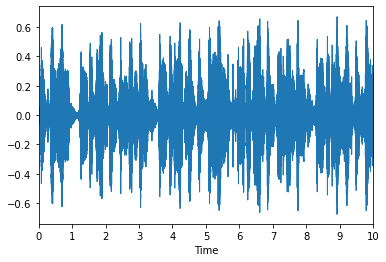

In [10]:
print(np.amax(sample), np.amin(sample))
## Waveplot
librosa.display.waveplot(sample[0], sr=SAMPLE_RATE)

In [11]:
# Read The Data
# TODO: save the TF DataSet!
X_train, y_train, X_test, y_test = data_utils.read_data(DATA_PATH, GENRES, sample_rate=SAMPLE_RATE, duration=DURATION, max_signal_len=MAX_SIGNAL_LEN)

Loading Audio files under Genere: metal
Loading Audio files under Genere: disco
Loading Audio files under Genere: classical
Loading Audio files under Genere: rock
Loading Audio files under Genere: jazz
Skipping file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00054.wav...
Loading Audio files under Genere: country
Loading Audio files under Genere: pop
Loading Audio files under Genere: blues
Loading Audio files under Genere: reggae
Loading Audio files under Genere: hiphop
Loading and Preprocessing Testing data......
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/rock/rock.00092.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/jazz/jazz.00016.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/disco/disco.00006.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/metal/metal.00021.wav...
(1, 1, 28160)
Loading audio file: GENERATIVE_DATA/GTZAN/genres_original/hiphop/hiphop.00063.wav...
(1, 1,

In [12]:
print(type(X_train), X_train.shape, X_test.shape, y_train.shape, X_test.shape)

print(y_train[:5])
print(set(y_train), set(y_test))

## Debug Inspect samples
### 2: classical, 9: hip-hop
hiphop_idx = np.where(y_train==2)[0]
print(hiphop_idx[:10])
ipd.Audio(X_train[hiphop_idx[2]], rate=SAMPLE_RATE)
# ipd.Audio(X_train[hiphop_idx[2]], rate=22050) # raw file

<class 'numpy.ndarray'> (899, 1, 28160) (100, 1, 28160) (899,) (100, 1, 28160)
[6 8 8 0 3]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[ 24  34  53  62  65  73  80  87  98 105]


In [13]:
X_train_T = X_train.transpose([0,2,1]) # (N, T, 1)
X_test_T = X_test.transpose([0, 2, 1])

In [14]:
print(X_train_T.shape, X_test_T.shape)
ipd.Audio(X_train_T[hiphop_idx[2]].flatten(), rate=SAMPLE_RATE)

(899, 28160, 1) (100, 28160, 1)


In [15]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_SIZE = 1000
NUM_GENERES = len(np.unique(y_train))

In [16]:
## Load to TF DataSet (numpy to TF Tensor)
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_T, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(BATCH_SIZE))
test_dataset = (tf.data.Dataset.from_tensor_slices((X_test_T, y_test))
                 .batch(BATCH_SIZE))

In [17]:
print(np.amax(X_train_T), np.amin(X_train_T))
# print(np.amax(list(train_dataset.as_numpy_iterator())))

1.25347 -1.2156466


In [18]:
### Example batch
sample_batch, sample_labels = next(iter(train_dataset))
print(sample_batch.shape)
print(sample_labels.shape, sample_labels)
print(sample_batch[0].numpy().squeeze())
print(tf.math.reduce_max(sample_batch).numpy(), tf.math.reduce_min(sample_batch).numpy(), )

(8, 28160, 1)
(8,) tf.Tensor([1 7 5 4 2 3 9 0], shape=(8,), dtype=int32)
[-0.25253022 -0.2786929  -0.09091578 ...  0.01791702 -0.00725984
 -0.06253158]
1.0524387 -1.0358212


#### DAta Distribution

Uniques in Train: [0 1 2 3 4 5 6 7 8 9], Unique in Test: [0 1 2 3 4 5 6 7 8 9]


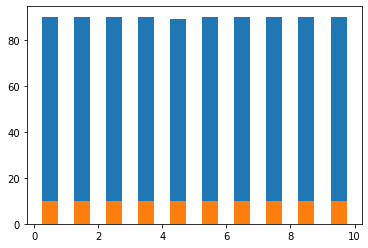

In [19]:
print(f"Uniques in Train: {np.unique(y_train)}, Unique in Test: {np.unique(y_test)}")
n_train, bins_train, _ = plt.hist(y_train, bins=np.arange(11), histtype='bar', rwidth=0.5)
n_test, bins_test, _ = plt.hist(y_test, bins=np.arange(11), histtype='bar', rwidth=0.5)

In [20]:
n_train

array([90., 90., 90., 90., 89., 90., 90., 90., 90., 90.])

In [21]:
n_test

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

####Training Data Samples (1 per genre)

In [22]:
## Multiple Genres Case
idx_to_genres = {v:k for (k, v) in GENRES.items()}
# create a dict of each unique entry and the associated indices
generes_train_idx = {v: np.where(y_train == v)[0].tolist()[:6] for v in np.unique(y_train)}

print(generes_train_idx)

train_samples = []

for i in range(NUM_GENERES):
  train_samples.append(X_train_T[int(generes_train_idx[i][0])])
  # Quantization Version
  # train_samples.append(X_train_Q[int(generes_train_idx[i][0])])

# Numpy Array
train_samples = np.stack(train_samples, axis=0)
print(train_samples.shape, train_samples[0])

{0: [3, 5, 18, 23, 25, 48], 1: [15, 27, 37, 39, 43, 46], 2: [24, 34, 53, 62, 65, 73], 3: [4, 30, 33, 40, 45, 55], 4: [6, 10, 12, 16, 20, 21], 5: [8, 9, 19, 41, 51, 81], 6: [0, 28, 35, 47, 56, 60], 7: [11, 13, 17, 22, 29, 38], 8: [1, 2, 7, 14, 42, 61], 9: [36, 44, 54, 67, 89, 106]}
(10, 28160, 1) [[-0.04690116]
 [-0.01698253]
 [-0.0486879 ]
 ...
 [-0.00471123]
 [-0.02285618]
 [-0.06057921]]


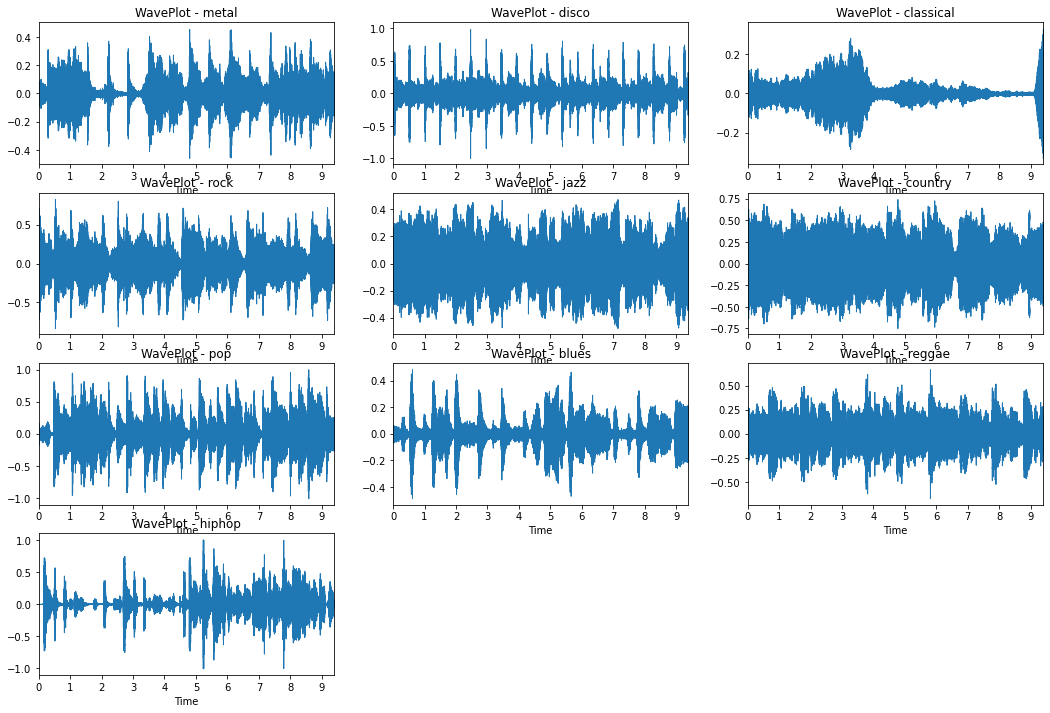

In [23]:
fig = plt.figure(figsize=(18, 12))

for i in range(train_samples.shape[0]):
    
  plt.subplot(4, 3, i + 1)

  librosa.display.waveplot(train_samples[i].squeeze(), sr=3000)

  plt.title(f"WavePlot - {idx_to_genres[i]}")
  # plt.tight_layout()
  
plt.show()

## Model Structure

### VQ

### Trainer

In [22]:
multi_head_attention.dummy_module()

'HHH'

In [23]:
# vqvae_trainer = VQVAETrainer(sample_batch.shape[1:], latent_dim=64, num_embeddings=512, depth=1, down_depth=[5], strides=[2]) # codebook size
# vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) #, run_eagerly=True) # eager mode for debug...
## Load From Module
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=1, latent_dim=64, num_embeddings=512, down_depth=[8], strides=[2], dilation_factor=3, residual_width=32) #  Debug when NT < K
# bottom-middle-top structure
vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=3, latent_dim=64, num_embeddings=512, down_depth=[3, 2, 2], strides=[2, 2, 2], dilation_factor=3, residual_width=32) # codebook size
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=2, latent_dim=64, num_embeddings=512, down_depth=[5, 3], strides=[2, 2], dilation_factor=3, residual_width=32) # codebook size
# vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=1, latent_dim=64, num_embeddings=512, down_depth=[5], strides=[2], dilation_factor=3)
# vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) #, run_eagerly=True) # eager mode for debug...

Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding EncoderConvBlock: 2
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 2
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0


In [ ]:
# vqvae_trainer.vqvae(sample_batch)
# vqvae_trainer.vqvae.summary()
for vqvae_ in vqvae_trainer.vqvaes:
  vqvae_.summary()

In [ ]:
# encdec.print_dec_layer(vqvae_trainer.decoder) # Check Dilation pattern

In [ ]:
print(vqvae_trainer.metrics)
# print(vqvae_trainer.vq.metrics)
for vq in vqvae_trainer.vqs:
  for m in vq.metrics:
    print(m.name) 
d = {m.name : m.result() for m in vqvae_trainer.vqs[0].metrics}
d

[<keras.metrics.Mean object at 0x000002013E0E3970>, <keras.metrics.Mean object at 0x000002013F3DF6D0>, <keras.metrics.Mean object at 0x000002013E234E20>, <keras.metrics.Mean object at 0x000002013E0D5610>, <keras.metrics.Mean object at 0x000002013E0000D0>, <keras.metrics.Mean object at 0x000002013E000910>, <keras.metrics.Mean object at 0x000002013E1E0E50>, <keras.metrics.Mean object at 0x000002013F2F8FD0>, <keras.metrics.Mean object at 0x000002013E216EE0>, <keras.metrics.Mean object at 0x000002013E216430>, <keras.metrics.Mean object at 0x000002013F3B6970>, <keras.metrics.Mean object at 0x000002013F3B6A00>, <keras.metrics.Mean object at 0x000002013E1D77F0>, <keras.metrics.Mean object at 0x000002013F2F6310>, <keras.metrics.Mean object at 0x0000020139662640>, <keras.metrics.Mean object at 0x0000020139662190>]
[0]batch_codebook_usage
[0]codebook_usage
[0]codebook_entropy
[1]batch_codebook_usage
[1]codebook_usage
[1]codebook_entropy
[2]batch_codebook_usage
[2]codebook_usage
[2]codebook_entro

{'[0]batch_codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 '[0]codebook_usage': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 '[0]codebook_entropy': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}

In [ ]:
dict(hhh=1.0, rere=2.0)

{'hhh': 1.0, 'rere': 2.0}

In [ ]:
#DEV VQ
# vqvae_trainer.get_quantizer().N_t
# print(vqvae_trainer.get_quantizer().embeddings)
# print(vqvae_trainer.get_quantizer().get_usage_count())
print(vqvae_trainer.vqs[0].trainable_variables)
# print(vqvae_trainer.vq.get_weights())
# for w, var in zip(vqvae_trainer.vq.get_weights(), vqvae_trainer.vq.variables):
#     print("Variable: "+var.name)
#     print(w.shape)
#     print(w)
# print(vqvae_trainer.vqvaes[0].trainable_variables)

[]


In [ ]:
print(sum([np.prod(var.numpy().shape) for var in vqvae_trainer.vqvaes[0].trainable_variables]))

186497


##### Validation

In [ ]:
#### Validation between Epoches TODO: move to module
'''
 sample latent z based on actual test data x
'''
def generate_and_save_waves(model, epoch, test_sample, if_quantized=False, channel_last=False, print_codebook_distribution=False):

  ## Codebook Vector usage (Put ahead reconstruction, given that vq preserve the last N_t for now)
  if print_codebook_distribution:
    vq_usage = model.get_quantizer().get_usage_count()
    print("Snapshot of Codebook Vector usage, Size(K/D, ): {}; SUM (last Batch size x latent_len){} ".format(tf.shape(vq_usage), tf.math.reduce_sum(vq_usage)))
    fig = plt.figure(figsize=(10, 5))
    plt.title("VQ Codebook Vector Usage Count")
    # plt.hist(vq_usage.numpy()) # should use bar...
    plt.bar(x=np.arange(len(vq_usage)), height=vq_usage.numpy())
    plt.show()

  print("[DEBUG] TOTAL Number of Trainable Weights for model: {}".format(sum([np.prod(var.numpy().shape) for var in model.trainable_variables])))

  # Direct Reconstruction (x -> x')
  input = test_sample
  if channel_last:
    input = np.transpose(test_sample, [0,2,1])
  predictions = model(input).numpy()
  print("Reconstructed Output: ", predictions.shape)
  fig = plt.figure(figsize=(18, 12))
  ret = []

  if if_quantized: # mu-law transformation
    # recover int waveform to float waveform
    # Greedy Sampling
    predictions = np.argmax(predictions, axis=-1)
    print("Sampled quantized: ", predictions.shape, predictions[0])

    predictions = mu_law_decode(predictions, QUANTIZATION_CHANNELS)

    print("Max: {}, Min: {}".format(np.amax(predictions), np.amin(predictions)))

  for i in range(predictions.shape[0]):
    waves = predictions[i]
    plt.subplot(4, 3, i + 1)

    if i==9:
      print("X': ", waves.squeeze())
      print(f"X range: [{np.amax(waves)}, {np.amin(waves)}]")

    librosa.display.waveplot(waves.squeeze(), sr=SAMPLE_RATE)
    plt.title(f"WavePlot - {idx_to_genres[i]}")
    # plt.tight_layout()
    ret.append(predictions[i])
    
  plt.show()


  return ret

In [ ]:
1e-4

0.0001

In [ ]:
# Callbacks
class VAEMonitor(tf.keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, **kwargs):
        super(VAEMonitor, self).__init__(**kwargs)

    def on_epoch_end(self, epoch, logs=None):
      ## DEBUG
      for level in range(self.model.levels):
        print("\n-------------------------Epoch: {}, Level: {}------------------------------".format(epoch, level))
        vq = self.model.vqs[level]
        codebook_usage = tf.reduce_sum(tf.cast(vq.get_usage_count() >= 1.0, dtype=tf.float32))
        collapsed_code = tf.reduce_sum(tf.cast(vq.get_usage_count() <= 0.0, dtype=tf.float32))
        print("\n[VQ DEBUG] Snap shot of N_t: {}; Code<=0... {}".format(codebook_usage, collapsed_code))
        # Reset the metrics!!!
        print("\nResetting the metrics...")
        for m in self.model.vqvaes[level].metrics:
          m.reset_state()
        for m in self.model.vqs[level].metrics:
          m.reset_state()

      # Periodic Inspect
      if epoch % 5 == 0:
        print("\n[DEBUG] This is Callback Monitor: End of Epoch", epoch)
        print("---------------------------Running Validation DataSet---------------------------")
        self.model.evaluate(test_dataset)
        for level in range(self.model.levels):
          print("-------------------------------ReConstruction of Training Samples for Level: {}-------------------------------".format(level))
          generate_and_save_waves(self.model.vqvaes[level], epoch, train_samples)
        # generate_and_save_waves(self.model, epoch, train_samples, if_quantized=True, channel_last=True)

vae_monitor = VAEMonitor()

In [ ]:
15e-5

0.00015

In [ ]:
# Callback 0: Learning Rate Scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=50, verbose=1, min_lr=0.0000001, min_delta=1.0)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam()) # 15e-5 for jukebox paper ('vqvae' model)

vqvae_trainer.fit(train_dataset, epochs=300, callbacks=[vae_monitor, reduce_lr])

In [ ]:
#### Inspect reconstructed sample
# recon_train_samples = generate_and_save_waves(vqvae_trainer, 0, train_samples) #TODO: need to assign which level of vqvae...
recon_train_samples_bottom = generate_and_save_waves(vqvae_trainer.vqvaes[0], 0, train_samples) #TODO: need to assign which level of vqvae...

In [ ]:
### Middle Level (TODO)
recon_train_samples_mid = generate_and_save_waves(vqvae_trainer.vqvaes[1], 0, train_samples) #TODO: need to assign which level of vqvae...

In [ ]:
### TOP Leve
recon_train_samples_top = generate_and_save_waves(vqvae_trainer.vqvaes[-1], 0, train_samples) #TODO: need to assign which level of vqvae...

In [ ]:
ipd.Audio(train_samples[2].squeeze(), rate=SAMPLE_RATE)

In [ ]:
ipd.Audio(recon_train_samples_bottom[9].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
ipd.Audio(recon_train_samples_mid[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
ipd.Audio(recon_train_samples_top[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

## Storage, Checkpointing...

In [24]:
VERSION = "double_separate_vqvae" #"3_levels_322_separate_vqvae" #
local_storage_path = './colab_storage/VQVAE/cp/{}/'.format(VERSION)

In [ ]:
# vqvae_trainer.save(local_storage_path)
for level in range(vqvae_trainer.levels):
    # vqvae_trainer.encoders[level].save_weights("{}{}/{}".format(local_storage_path, "encoder", level))
    # vqvae_trainer.decoders[level].save_weights("{}{}/{}".format(local_storage_path, "decoder", level))
    # vqvae_trainer.vqs[level].save_weights("{}{}/{}".format(local_storage_path, "vq", level))
    vqvae_trainer.vqvaes[level].save_weights("{}{}/{}".format(local_storage_path, "vqvae", level))

In [25]:
loaded_vqvae_trainer = vqvae.VQVAE(sample_batch.shape[1:], levels=2, latent_dim=64, num_embeddings=512, down_depth=[5, 3], strides=[2, 2], dilation_factor=3, residual_width=32) # Two Level VQ-VAEs codebook size

Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 0
Adding EncoderConvBlock: 1
Adding DecoderConvBlock: 0
Adding DecoderConvBlock: 1
Adding DecoderConvBlock: 0


In [26]:
loaded_vqvae_trainer.vqs[0].N_t
# Validation
initial_codebook = loaded_vqvae_trainer.vqs[0].embeddings.numpy()
initial_enc_weights = loaded_vqvae_trainer.encoders[0].get_weights() # already NP arr[w.numpy() for w in loaded_vqvae_trainer.encoders[0].get_weights()]
initial_dec_weights = loaded_vqvae_trainer.decoders[0].get_weights() #[w.numpy() for w in loaded_vqvae_trainer.decoders[0].get_weights()]

In [26]:
for level in range(loaded_vqvae_trainer.levels):
    # vqvae_trainer.encoders[level].save_weights("{}{}/{}".format(local_storage_path, "encoder", level))
    # vqvae_trainer.decoders[level].save_weights("{}{}/{}".format(local_storage_path, "decoder", level))
    # vqvae_trainer.vqs[level].save_weights("{}{}/{}".format(local_storage_path, "vq", level))
    print("--------- Loading Models from Level: {}".format(level))
    loaded_vqvae_trainer.vqvaes[level].load_weights("{}{}/{}".format(local_storage_path, "vqvae", level))

--------- Loading Models from Level: 0
--------- Loading Models from Level: 1


In [27]:
# loaded_codebook = loaded_vqvae_trainer.vqs[0].embeddings
# print(loaded_codebook == initial_codebook)
# loaded_enc_weights = loaded_vqvae_trainer.encoders[0].get_weights()
# for w1, w2 in zip(initial_enc_weights, loaded_enc_weights):
#   print(w1==w2)

In [ ]:
## Resume Training
loaded_vqvae_trainer.compile(optimizer=keras.optimizers.Adam(15e-5)) # 15e-5 for jukebox paper ('vqvae' model)

loaded_vqvae_trainer.fit(train_dataset, epochs=100, callbacks=[vae_monitor, reduce_lr])

[DEBUG] TOTAL Number of Trainable Weights for model: 496705
Reconstructed Output:  (10, 28160, 1)
X':  [-0.00379573 -0.00370539  0.0009532  ... -0.00791227 -0.00150955
  0.00578699]
X range: [0.7862967848777771, -0.9045540690422058]


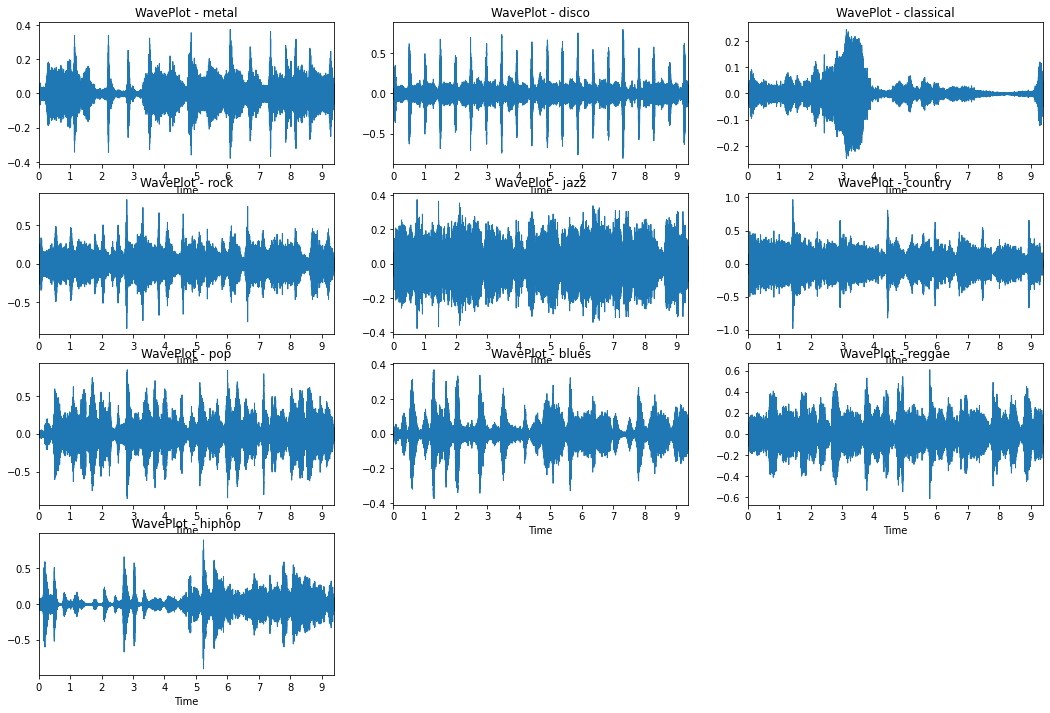

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


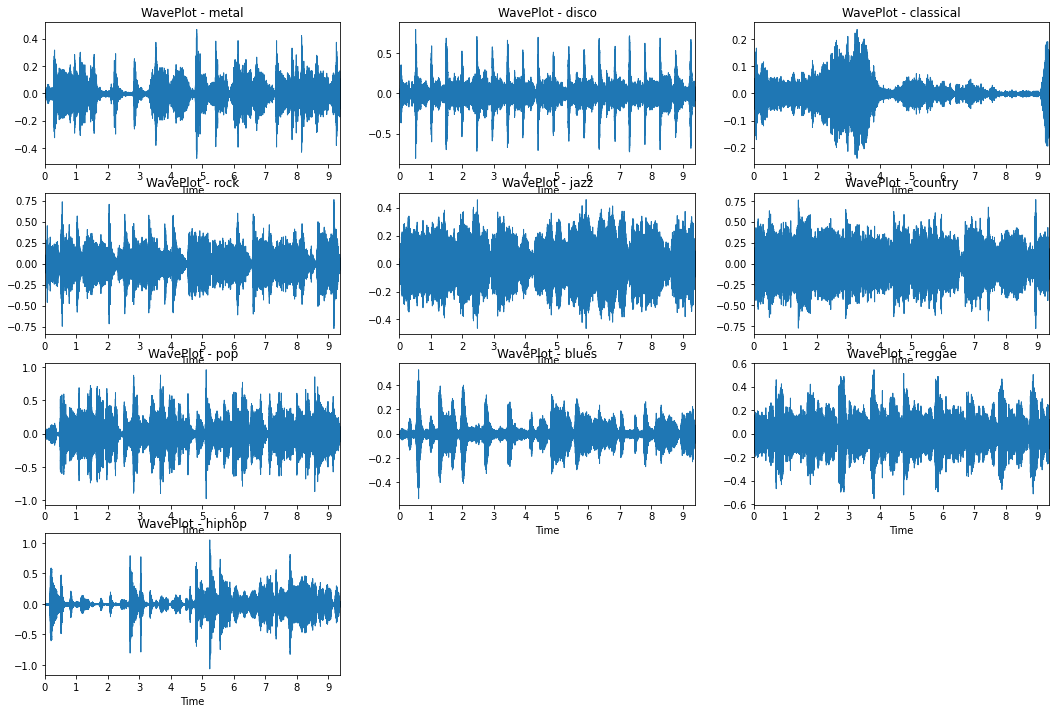

In [31]:
recon_train_samples_top_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=1) #TODO: need to assign which level of vqvae...
recon_train_samples_bottom_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=0) #TODO: need to assign which level of vqvae...

In [32]:
ipd.Audio(recon_train_samples_top_[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [33]:
ipd.Audio(recon_train_samples_bottom_[2].squeeze(), rate=SAMPLE_RATE) # Metal Recon

## Prior and Up-Sampler

#### Multi-Head Attention (Self-Attention if no lyric conditioning...)

## Factorized Attention

In [ ]:
np.set_printoptions(precision=2)

# Sequence of length 16
query = tf.random.normal([4, 16, 12])
key = tf.random.normal([4, 16, 12])
value = tf.random.normal([4, 16, 12])

attn_mask = multi_head_attention.create_look_ahead_mask(query.shape[1], key.shape[1])

print("Attention Mask(Auto-Regressive): ", attn_mask)

mha = layers.MultiHeadAttention(num_heads=4, key_dim=4, value_dim=4) # key_dim == query_dim

query_input = tf.keras.Input(shape=[8, 12])
value_input = tf.keras.Input(shape=[4, 12])
output, attn_w = mha(query_input, value_input, return_attention_scores=True)
# B, T, E (E being the output dimension of the query if output_shape not specified)
print(output.shape) # (B, Tq, E(query_dim))
print(attn_w.shape) # (B, H, Tq, Tkv)

mha_out, mha_attn = mha(query=query, key=key,
                        value=value, return_attention_scores=True, attention_mask=attn_mask)

print(mha_attn[0][0].numpy()) # (pick first attention Head
# print(mha_attn[1][0].numpy()) # Validate batch dim...

## Block Attention: Reshape sequence into attention block (b x l)
L = tf.shape(query)[1]
b = 4
l = L // b
query_block = tf.reshape(query, [tf.shape(query)[0] * b, l, tf.shape(query)[-1]]) # extend blocks to batch dimension
key_block = tf.reshape(key, [tf.shape(query)[0] * b, l, tf.shape(query)[-1]])
value_block = tf.reshape(value, [tf.shape(query)[0] * b, l, tf.shape(query)[-1]])

attn_mask_block = multi_head_attention.create_look_ahead_mask(query_block.shape[1], key_block.shape[1])

mha_out_block, mha_attn_block = mha(query=query_block, key=key_block,
                        value=value_block, return_attention_scores=True, attention_mask=attn_mask_block)

print(mha_out_block.shape)
print(mha_attn_block.shape, mha_attn_block[0][0].numpy()) # attention within each attn block

In [ ]:
## Take the first Head
ah = mha_attn_block[:, 1, ...]
for i in tf.range(ah.shape[0]):
  print(ah[i].numpy())

In [ ]:
ah.get_shape().as_list()

[16, 4, 4]

## Latent Code Generation

In [34]:
from utils import tf_utils
import time
from src.transformer import transformer
from src.transformer import multi_head_attention
from src.transformer import factorized_attention
import autoregressive


importlib.reload(autoregressive)
importlib.reload(data_utils)
importlib.reload(tf_utils)
importlib.reload(multi_head_attention)
importlib.reload(factorized_attention)
importlib.reload(transformer)
importlib.reload(autoregressive_fmha)

<module 'src.autoregressive.autoregressive_fmha' from 'C:\\Users\\Zeyu Sun\\Documents\\GitHub\\VAE-based-Music--Deep-Generative-Models\\src\\autoregressive\\autoregressive_fmha.py'>

#### Bottom Level CODE
TODO: Move this to be modular

In [35]:
X_train_T.shape
sample_batch.shape
LEVEL=0 # 0 for bottom

In [36]:
ini_emb = loaded_vqvae_trainer.vqs[0].embeddings.numpy()

In [37]:
def get_latent_codes(vqvae, x, level=0):
  enc_outputs = vqvae.encoders[level](x, training=False) # (N, T_downsampled, C)
  latent_dim = tf.shape(enc_outputs)[-1]
  # print(enc_outputs.shape)
  # latent_output, latent_codes = vqvae.vqs[level](tf.reshape(enc_outputs, [-1, latent_dim]), training=False)
  latent_output, latent_codes = vqvae.vqs[level](enc_outputs, training=False)
  # print(latent_output.shape, latent_codes.shape)
  latent_codes = tf.reshape(latent_codes, tf.shape(enc_outputs)[:-1])
  # print(latent_codes.shape, latent_codes.dtype)
  return latent_output, latent_codes

In [38]:
# vq_out_bottom, latent_codes_bottom = get_latent_codes(loaded_vqvae_trainer, X_train_T, level=0)
# (N, T, C); (N, T)
sample_vq_out_bottom, sample_latent_codes_bottom = get_latent_codes(loaded_vqvae_trainer, sample_batch, level=0)

In [39]:
## Top Level, extra 2^3=8 hoplength (32*8 = 256)
sample_vq_out_top, sample_latent_codes_top = get_latent_codes(loaded_vqvae_trainer, sample_batch, level=1)

In [40]:
## Make Sure No More Update/Training of vqs' embeddings!
print(tf.reduce_sum(tf.cast(loaded_vqvae_trainer.vqs[0].embeddings != ini_emb, tf.float32)))

tf.Tensor(0.0, shape=(), dtype=float32)


In [41]:
# Validate if the latent codes is legit...
vq = loaded_vqvae_trainer.vqs[0]
quantized = tf.matmul(tf.one_hot(sample_latent_codes_bottom, vq.num_embeddings), vq.embeddings, transpose_b=True)
# print(quantized != tf.reshape(sample_vq_out_bottom, quantized.shape))
# print(tf_utils.compare_t(quantized, sample_vq_out_bottom)) # still diff... due to precision?
## Reconstruction from latent codes
recon = loaded_vqvae_trainer.decoders[0](quantized).numpy() # (N, T, 1)
ipd.Audio(recon[0].squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
recon = loaded_vqvae_trainer.decode(sample_latent_codes_bottom, level=0) # (N, T, 1)
ipd.Audio(recon[0].numpy().squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
# Original
ipd.Audio(sample_batch[0].numpy().squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
# VQ-VAE E2E pass through
e2e_recon = loaded_vqvae_trainer.vqvaes[0](sample_batch, training=False)
ipd.Audio(e2e_recon[0].numpy().squeeze(), rate=SAMPLE_RATE) # Metal Recon

In [ ]:
tf_utils.compare_t(loaded_vqvae_trainer.vqs[0].embeddings, ini_emb) # Extra Paranoid...

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(64, 512), dtype=float32, numpy=
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>)

In [ ]:
_, train_samples_latent_bottom = get_latent_codes(loaded_vqvae_trainer, train_samples, level=0)
print(train_samples_latent_bottom.shape) # (10, T_l)
_, train_samples_latent_top = get_latent_codes(loaded_vqvae_trainer, train_samples, level=1)
print(train_samples_latent_top.shape)

(10, 880)
(10, 110)


In [ ]:
## Plot the recon result
_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=0, if_decode=True, latent_code=train_samples_latent_bottom)

In [ ]:
_ = tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=1, if_decode=True, latent_code=train_samples_latent_top)

### Prior Training

In [60]:
EPOCHS = 1000
CODEBOOK_SIZE = 512 + 1 # Trick, let start token being 512
MHA_HEADS = 1 #4
MHA_MODEL =  256 #128
MHA_DEPTH = 18 #6
MAXIMUM_POS_ENCODING = 1000

ATTN_STACKS = 1 # (row, col, prev_row)
BLOCKS = 55  # For bottom: 880 = 55 * 16
DROP_OUT_RATE=0.0

Text(0.5, 0, 'Train Step')

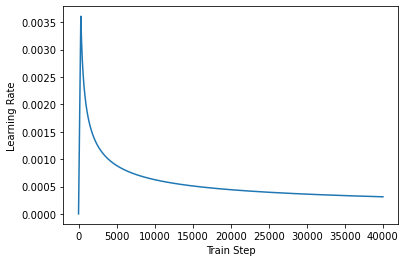

In [61]:
temp_learning_rate_schedule = multi_head_attention.CustomSchedule(MHA_MODEL, warmup_steps=300)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [62]:
# automha_optimizer = keras.optimizers.Adam(1e-3) # TODO: LR Schedule
learning_rate = multi_head_attention.CustomSchedule(MHA_MODEL, warmup_steps=4000)

automha_optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
ent_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [63]:
sample_latent_codes_bottom.shape[1:]

TensorShape([880])

In [64]:
# del automha
# sample_in = tf.random.uniform((32, 4), dtype=tf.int64, minval=1, maxval=200)
# print(sample_in)
# For Bottom Level VQ-VAE
# automha = autoregressive.MHABasedAutoregressiveModel(context_length=sample_latent_codes_bottom.shape[1:], target_vocab_size=CODEBOOK_SIZE, width=MHA_MODEL, depth=MHA_DEPTH,
#                                           heads=MHA_HEADS, maximum_pos_encoding=MAXIMUM_POS_ENCODING)
## Factorized Transformer Based Prior

automha = autoregressive_fmha.FMHABasedAutoregressiveModel(context_length=sample_latent_codes_bottom.shape[1:], target_vocab_size=CODEBOOK_SIZE, width=MHA_MODEL,depth=MHA_DEPTH, heads=MHA_HEADS, blocks=BLOCKS, attn_stacks=ATTN_STACKS, drop_out_rate=DROP_OUT_RATE) # drop_out_rate=0.0) # NO DropOut

sample_out, sample_attn = automha(sample_latent_codes_bottom)
# Top Level VQ-VAE
# automha = autoregressive.MHABasedAutoregressiveModel(context_length=sample_latent_codes_top.shape[1:], target_vocab_size=CODEBOOK_SIZE, width=MHA_MODEL, depth=MHA_DEPTH,
#                                           heads=MHA_HEADS, maximum_pos_encoding=MAXIMUM_POS_ENCODING, pos_emb=False)
# sample_out, sample_attn = automha(sample_latent_codes_top)

## Factorized Transformer Based Prior



[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention
[DEBUG] CAUSAL CONV1D, with No Mask pre-row attention


In [65]:
print(sample_out.shape)
automha.summary()
print([(v.name, w.shape) for v, w in zip(automha.trainable_variables, automha.get_weights())])
# print([w.shape for w in automha.get_weights()])
print(automha.context_length)

(8, 880, 513)
Model: "fmha_based_autoregressive_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  131328    
                                                                 
 positional_embedding_1 (Pos  multiple                 225280    
 itionalEmbedding)                                               
                                                                 
 factorized_transformer_1 (F  multiple                 4459392   
 actorizedTransformer)                                           
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 dense_73 (Dense)            multiple                  131841    
                                                                 
Total params: 4,947

In [66]:
## Inspect Attention Stacks
for layer in automha.transformer.model.layers:
    print(layer.attn_func, layer.fmha.attn_type)

0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row
0 row
1 col
2 prev row


In [67]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [68]:
(None, *sample_batch.shape[1:])

(None, 28160, 1)

In [69]:
"""
"factorizedAttnBasedPriorForBottomWithPosEmbedding_CAUSALCONV1D_noDropOut" #"factorizedAttnBasedPriorForBottomWithPosEmbedding_test" #"factorizedAttnBasedPriorForBottomWithPosEmbedding_NoConv1DQKV" #"multiheadAttnBasedPriorForTopWithPosEncoding"
factorizedAttnBasedPriorForBottomWithPosEmbedding_DenseDQKV_noDropOut
'factorizedAttnBasedPriorForBottomWithPosEmbedding_CAUSALCONV1D'
"""

PRIOR_VERSION= 'Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row' #
HYPER_PARAMS = '_HEADS={}_WIDTH={}_DEPTH={}_BLOCKS=_{}_DROP-OUT_{}'.format(MHA_HEADS, MHA_MODEL, MHA_DEPTH, BLOCKS, DROP_OUT_RATE)
prior_model_path = './colab_storage/VQVAE/cp/{}/{}/'.format("prior", PRIOR_VERSION+HYPER_PARAMS)
print(prior_model_path)

ckpt = tf.train.Checkpoint(transformer=automha,
                           optimizer=automha_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, prior_model_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/


##### Attention(s) Plot

In [70]:
def plot_attention_head(attention_mat, in_tokens=None, translated_tokens=None):
  """
  The plot is of the attention when a token was generated.
  The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]
  """

  ax = plt.gca()
  ax.matshow(attention_mat)
  # ax.set_xticks(range(len(in_tokens)))
  # ax.set_yticks(range(len(translated_tokens)))

  # labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  # ax.set_xticklabels(
  #     labels, rotation=90)

  # labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  # ax.set_yticklabels(labels)

def plot_attention_weights(attention_heads, name="MultiHeadAttention", sentence=None, translated_tokens=None):
  '''
    Plot attention matrix for multi-head attentions
  '''
  # in_tokens = tf.convert_to_tensor([sentence])
  # in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  # in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  # in_tokens

  fig = plt.figure(figsize=(12, 6))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  # plt.title(name)
  plt.show()

In [71]:
# # sample_attn
# # shape: (batch=, num_heads, seq_len_q, seq_len_k)
# ex_attention_heads_first = sample_attn['decoder_layer{}_attention'.format(1)] # Last encoder block

# ex_attention_heads_last = sample_attn['decoder_layer{}_attention'.format(MHA_DEPTH)] # Self attention block


# # 
# print(ex_attention_heads_first.shape)

# # plot_attention_head(ex_attention_heads_first[0][0])
# plot_attention_weights(ex_attention_heads_first[0])
# plot_attention_weights(ex_attention_heads_last[0])
LEVEL

0

transformer_layer_0_attention
(440, 1, 16, 16)


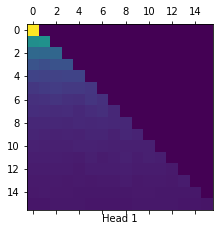

transformer_layer_17_attention
(440, 1, 16, 16)


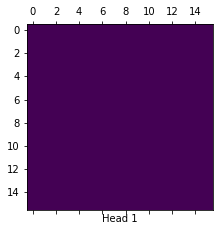

In [72]:
 for k, v in sample_attn.items():
  print(k)
  print(v.shape)
  tf_utils.plot_attention_weights(v[0])

In [76]:
train_step_signature = [
    tf.TensorSpec(shape=(None, *sample_batch.shape[1:]), dtype=tf.float32),
    # tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    # tf.TensorSpec(shape=(), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inputs):
  """
    :param inputs: (N, T, 1) the raw audio waveform!
  """

  # TODO, move this to 'encode' function
  quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, inputs, level=LEVEL) # (N, T_compressed)

  # latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=0) # TODO: this is temporary, using the label token embeddings instead!
  latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
  # print(latent_input.numpy(), latent_codes.shape)
  target = latent_codes

  with tf.GradientTape() as tape:
    pred_logits, attn_weights = automha(latent_input, training=True)

    loss = autoregressive.loss_function(target, pred_logits, loss_fn=ent_loss_fn) # loss per token

  gradients = tape.gradient(loss, automha.trainable_variables)
  automha_optimizer.apply_gradients(zip(gradients, automha.trainable_variables))

  train_loss(loss)
  train_accuracy(autoregressive.accuracy_function(target, pred_logits))

  return attn_weights

In [77]:
def test_step(inputs, epoch=0):
  # Test Data Set
  train_loss.reset_state()
  train_accuracy.reset_state()
  for (batch, (X, Y)) in enumerate(test_dataset):
    # print(batch)
    quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, X, level=LEVEL) # (N, T_compressed)

    latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
    target = latent_codes

    pred_logits, attn_weights = automha(latent_input, training=False)

    loss = autoregressive.loss_function(target, pred_logits, loss_fn=ent_loss_fn) 
    train_loss.update_state(loss)
    train_accuracy.update_state(autoregressive.accuracy_function(target, pred_logits))

  print(f'Testing performance: Loss {train_loss.result():.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(train_loss.result()):.5f}; Accuracy {train_accuracy.result():.4f}')
  
  # Training Samples
  quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, inputs, level=LEVEL) # (N, T_compressed)

  latent_input = tf.pad(latent_codes[:, :-1], paddings=[[0,0],[1,0]], mode='CONSTANT', constant_values=CODEBOOK_SIZE-1) # TODO: this is temporary, using the label token embeddings instead!
  # print(latent_input.numpy())
  target = latent_codes

  pred_logits, attn_weights = automha(latent_input, training=False)

  loss = autoregressive.loss_function(target, pred_logits, loss_fn=ent_loss_fn) # loss per token

  # Plot Attentions
  for k, v in attn_weights.items():
    print(k)
    print(v.shape)
    tf_utils.plot_attention_weights(v[0])
  # ex_attention_heads_first = sample_attn['decoder_layer{}_attention'.format(1)] # Last encoder block

  # ex_attention_heads_last = sample_attn['decoder_layer{}_attention'.format(MHA_DEPTH)] # Self attention block

  # 
  # print(ex_attention_heads_first.shape)

  # plot_attention_weights(ex_attention_heads_first[0])
  # plot_attention_weights(ex_attention_heads_last[0])

  # Reconstruction and comparison
  # Greedy Sampling also
  if epoch % 20 ==0:
    # Sampling is a bit costy....
    tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=LEVEL, if_decode=True, latent_code=tf.argmax(pred_logits, axis=-1), if_sample=True, prior_model=automha)
  else:
    tf_utils.generate_and_save_waves(loaded_vqvae_trainer, 0, train_samples, level=LEVEL, if_decode=True, latent_code=tf.argmax(pred_logits, axis=-1), if_sample=False)

  return pred_logits, attn_weights


In [75]:
## [DEBUG] Positional Embedding learning
ini_pos_embeddings = automha.x_pos_embedding.embeddings.numpy()
print(ini_pos_embeddings, ini_pos_embeddings.shape)
print(automha.x_pos_embedding.get_weights()[0])
ini_emb = automha.x_embedding.get_weights()[0]
ini_emb.shape

[[ 0.00815679  0.04509789  0.03398507 ... -0.02445765  0.02000317
  -0.03914829]
 [-0.04277742  0.04594009 -0.02467835 ...  0.01140376  0.00314715
  -0.01325138]
 [ 0.02891136 -0.02924432  0.00097545 ... -0.02193621  0.03243795
  -0.00464924]
 ...
 [-0.00196409  0.00023179  0.02166622 ... -0.02411786  0.04272598
  -0.02061279]
 [-0.00145556  0.00731059  0.0296816  ... -0.00858511  0.00056704
   0.04205089]
 [ 0.03338108  0.04119735  0.02002629 ...  0.01347185 -0.00735992
  -0.00627832]] (880, 256)
[[ 0.00815679  0.04509789  0.03398507 ... -0.02445765  0.02000317
  -0.03914829]
 [-0.04277742  0.04594009 -0.02467835 ...  0.01140376  0.00314715
  -0.01325138]
 [ 0.02891136 -0.02924432  0.00097545 ... -0.02193621  0.03243795
  -0.00464924]
 ...
 [-0.00196409  0.00023179  0.02166622 ... -0.02411786  0.04272598
  -0.02061279]
 [-0.00145556  0.00731059  0.0296816  ... -0.00858511  0.00056704
   0.04205089]
 [ 0.03338108  0.04119735  0.02002629 ...  0.01347185 -0.00735992
  -0.00627832]]


(513, 256)

In [223]:
# train_step(sample_latent_codes_bottom)
_ = train_step(sample_batch)

In [ ]:
# [DEBUG] Checking the Positional Embeddings is getting learned
updated_pos_emb = automha.x_pos_embedding.embeddings.numpy()
tf_utils.compare_t(updated_pos_emb, ini_pos_embeddings)
# print(updated_pos_emb)

In [ ]:
_ = test_step(train_samples)

In [78]:
prior_train_dataset = (tf.data.Dataset.from_tensor_slices((X_train_T, y_train))
                 .shuffle(TRAIN_SHUFFLE_SIZE)
                 .batch(8))
print(next(iter(prior_train_dataset))[0].shape)

(8, 28160, 1)


Epoch 1 Loss 10.4858; Perplexity (exp of loss_per_word): 35804.61719; Accuracy 0.0098
Time taken for 1 epoch: 55.83 secs

Saving checkpoint for epoch 1 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-1
---------------------------Epoch: 0 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 8.9874; Perplexity (exp of loss_per_word): 8001.51953; Accuracy 0.0142
transformer_layer_0_attention
(550, 1, 16, 16)


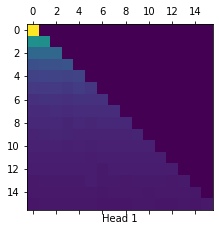

transformer_layer_17_attention
(550, 1, 16, 16)


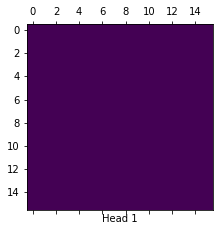

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


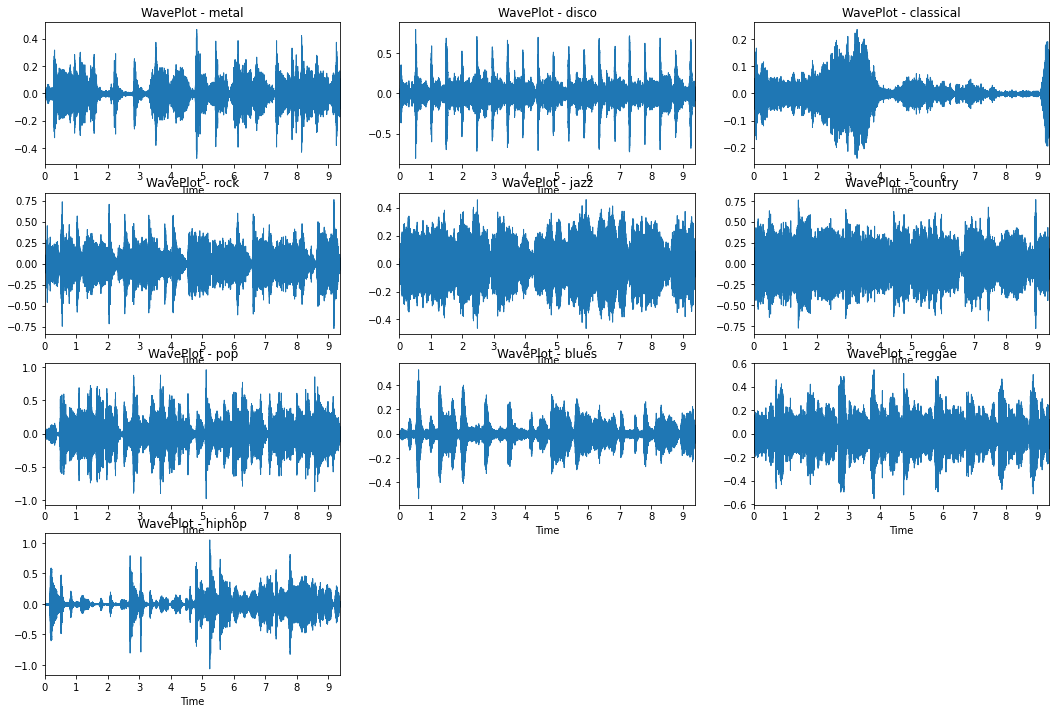

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [-0.00175376 -0.00253344  0.0144415  ... -0.00809437 -0.0104525
 -0.00376903]
X range: [0.7273527383804321, -0.8722003102302551]


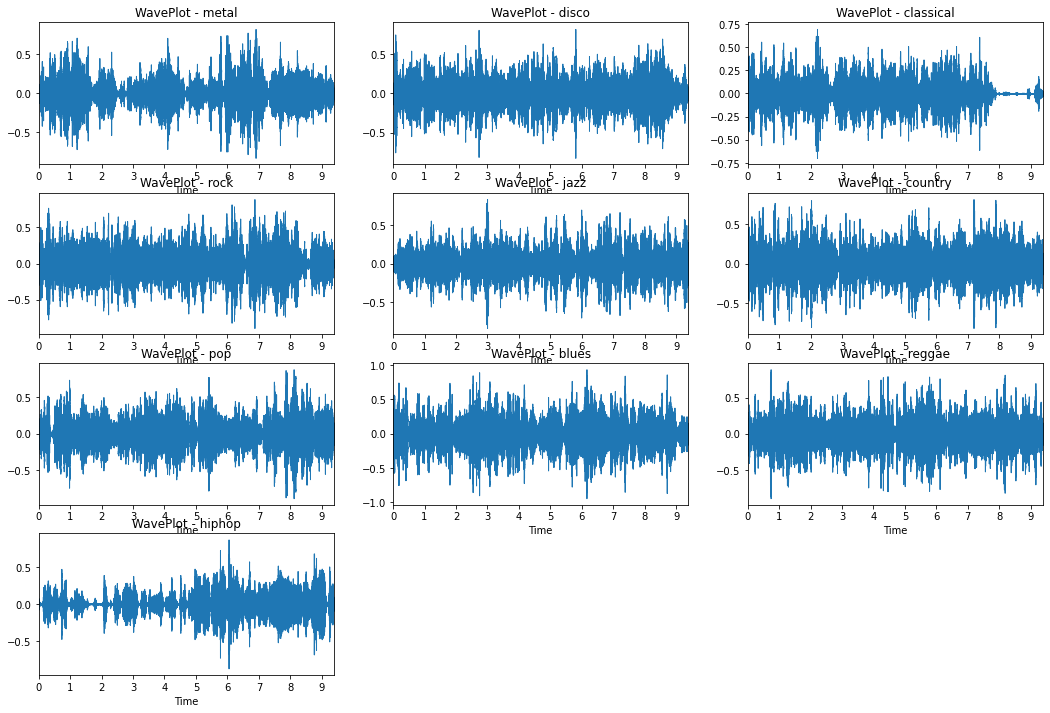

------------------------------- Auto-regressive Sampling in process..........-----------------------------
Sampled output shape: [  4 881] (with Start Token...)
tf.Tensor(
[[512 453 476 ... 411 411 411]
 [512 453 476 ... 411 411 411]
 [512 453 476 ... 411 411 411]
 [512 453 476 ... 411 411 411]], shape=(4, 881), dtype=int64)
(4, 28160, 1)
-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------
X':  [-0.03914925 -0.0010142   0.04457306 ... -0.00341901 -0.00954305
  0.00404466]
X range: [0.7217187881469727, -0.8354530334472656]


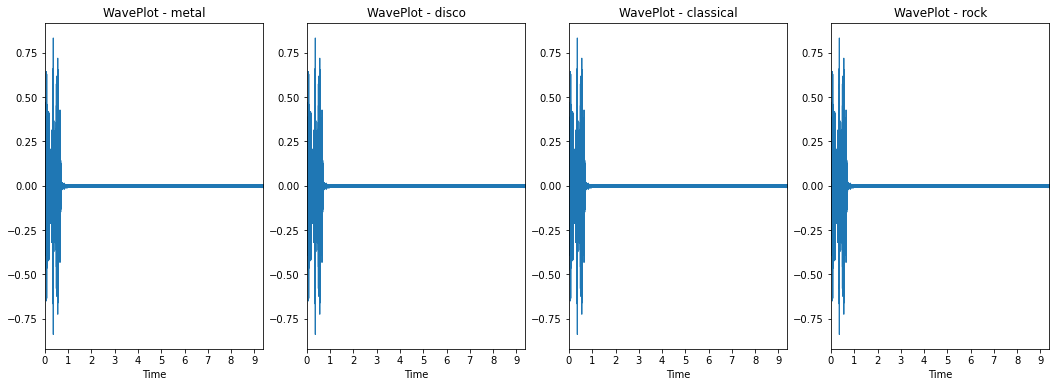

Epoch 2 Loss 7.6202; Perplexity (exp of loss_per_word): 2038.89929; Accuracy 0.0391
Time taken for 1 epoch: 17.02 secs

Epoch 3 Loss 6.0396; Perplexity (exp of loss_per_word): 419.70444; Accuracy 0.0656
Time taken for 1 epoch: 17.07 secs

Epoch 4 Loss 5.3379; Perplexity (exp of loss_per_word): 208.06731; Accuracy 0.0781
Time taken for 1 epoch: 17.06 secs

Epoch 5 Loss 5.0137; Perplexity (exp of loss_per_word): 150.45697; Accuracy 0.0859
Time taken for 1 epoch: 17.04 secs

Epoch 6 Loss 4.8473; Perplexity (exp of loss_per_word): 127.39627; Accuracy 0.0926
Time taken for 1 epoch: 17.06 secs

Saving checkpoint for epoch 6 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-2
---------------------------Epoch: 5 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 4.9514; Perp

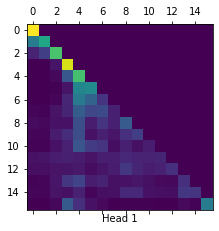

transformer_layer_17_attention
(550, 1, 16, 16)


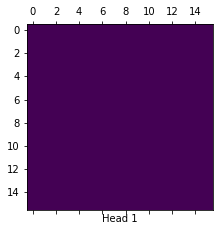

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


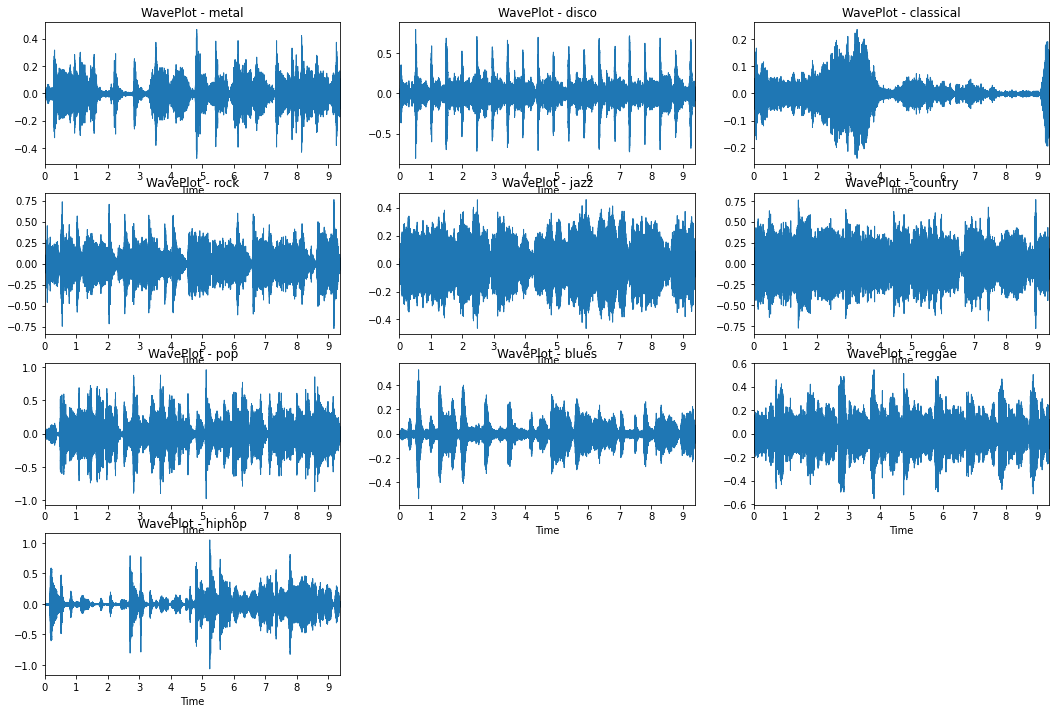

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00523169  0.00278058 -0.00291809 ... -0.01380943 -0.02077539
  0.00360125]
X range: [0.69957435131073, -0.7694277167320251]


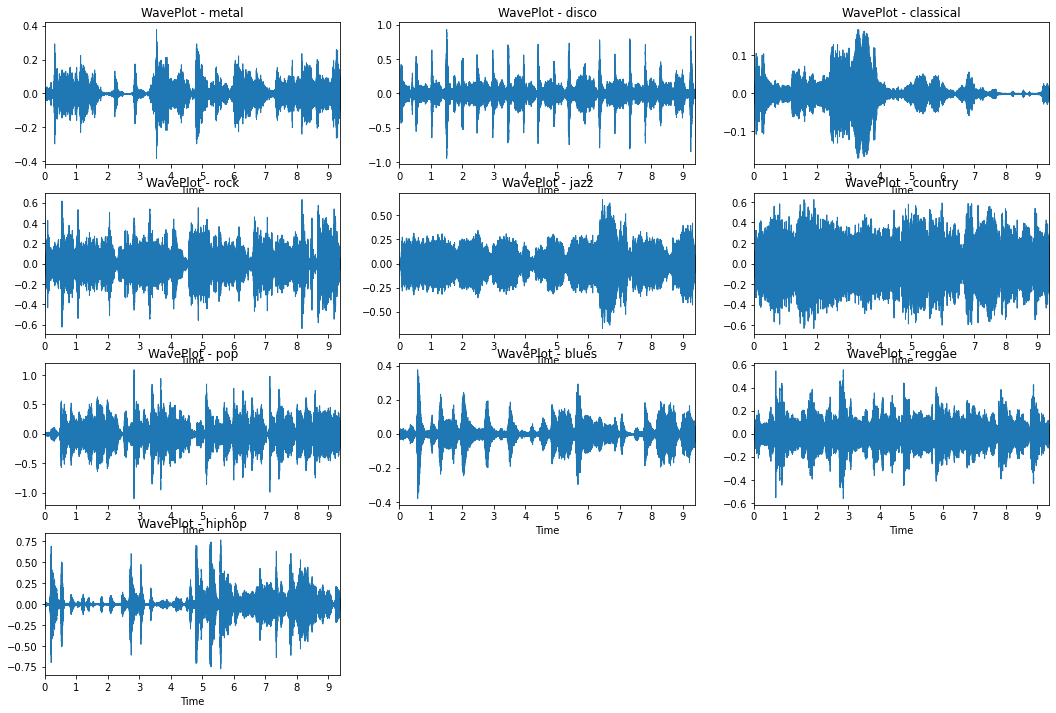

Epoch 7 Loss 4.7491; Perplexity (exp of loss_per_word): 115.47609; Accuracy 0.0979
Time taken for 1 epoch: 17.44 secs

Epoch 8 Loss 4.6865; Perplexity (exp of loss_per_word): 108.47504; Accuracy 0.1021
Time taken for 1 epoch: 16.45 secs

Epoch 9 Loss 4.6364; Perplexity (exp of loss_per_word): 103.17105; Accuracy 0.1064
Time taken for 1 epoch: 16.40 secs

Epoch 10 Loss 4.6031; Perplexity (exp of loss_per_word): 99.79151; Accuracy 0.1090
Time taken for 1 epoch: 16.39 secs

Epoch 11 Loss 4.5674; Perplexity (exp of loss_per_word): 96.28933; Accuracy 0.1118
Time taken for 1 epoch: 16.45 secs

Saving checkpoint for epoch 11 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-3
---------------------------Epoch: 10 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 4.8127; Per

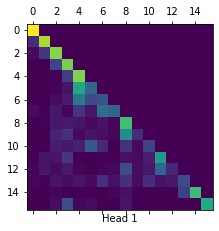

transformer_layer_17_attention
(550, 1, 16, 16)


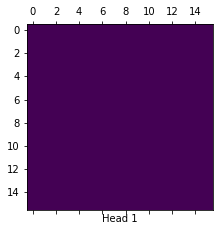

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


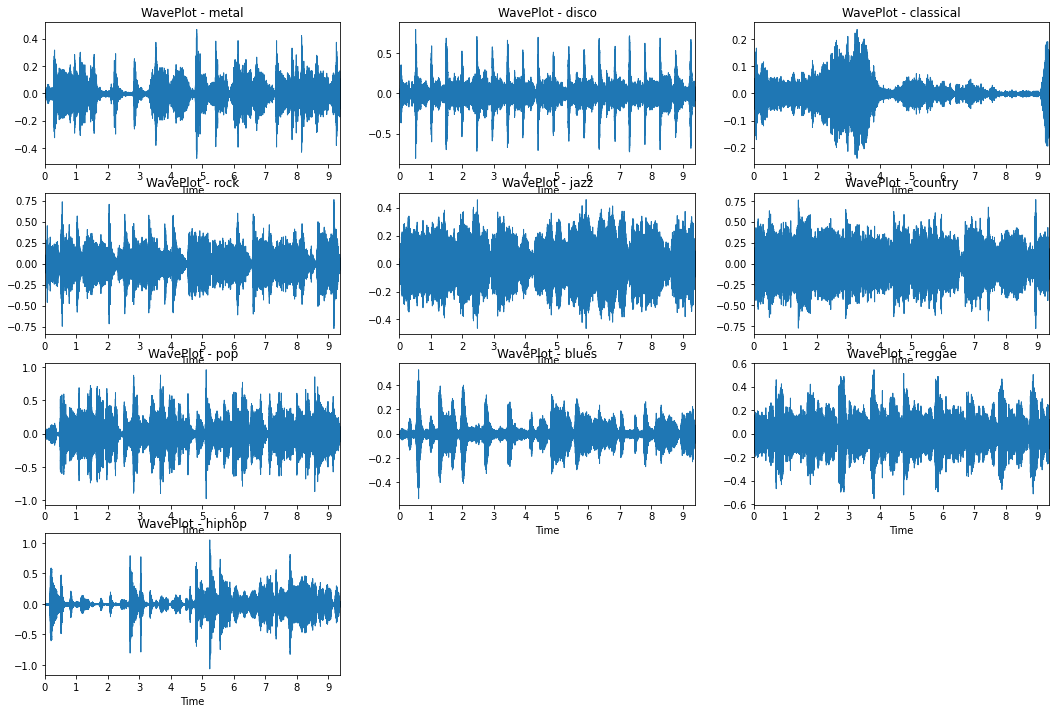

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00565018  0.00426031 -0.00127654 ... -0.00864205 -0.03504159
 -0.02838302]
X range: [1.0023951530456543, -1.1173410415649414]


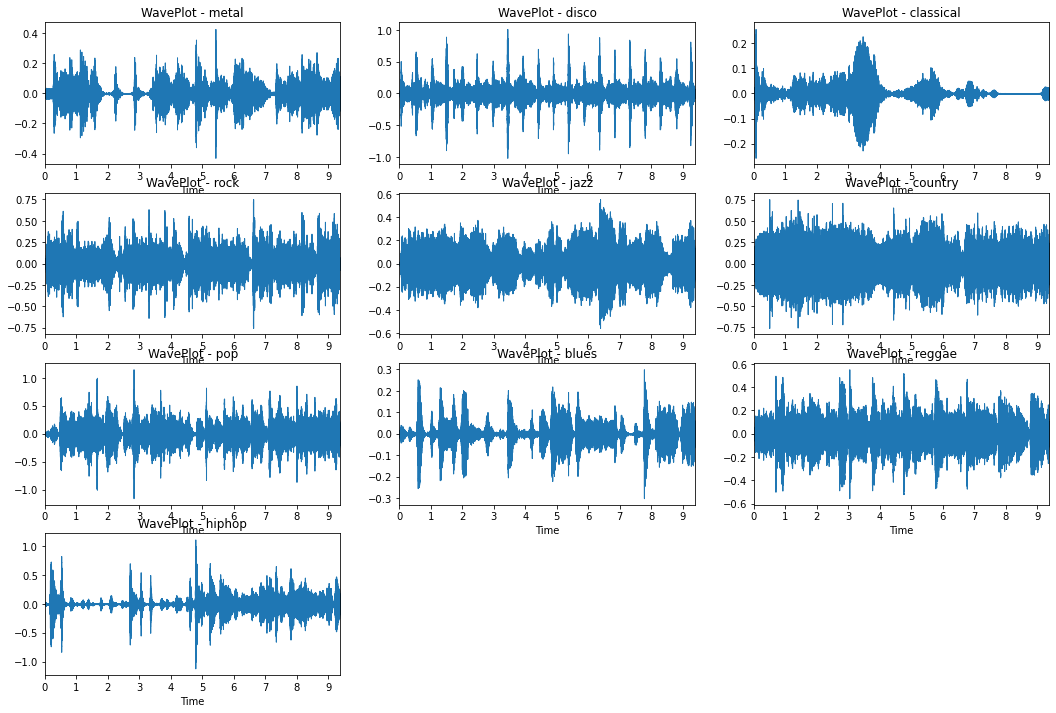

Epoch 12 Loss 4.5402; Perplexity (exp of loss_per_word): 93.70603; Accuracy 0.1145
Time taken for 1 epoch: 17.26 secs

Epoch 13 Loss 4.5098; Perplexity (exp of loss_per_word): 90.90805; Accuracy 0.1172
Time taken for 1 epoch: 17.05 secs

Epoch 14 Loss 4.4845; Perplexity (exp of loss_per_word): 88.62911; Accuracy 0.1196
Time taken for 1 epoch: 17.05 secs

Epoch 15 Loss 4.4616; Perplexity (exp of loss_per_word): 86.62797; Accuracy 0.1221
Time taken for 1 epoch: 17.06 secs

Epoch 16 Loss 4.4282; Perplexity (exp of loss_per_word): 83.78233; Accuracy 0.1251
Time taken for 1 epoch: 17.10 secs

Saving checkpoint for epoch 16 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-4
---------------------------Epoch: 15 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 4.7704; Per

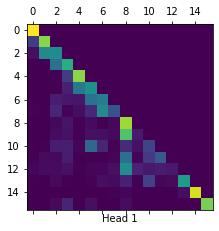

transformer_layer_17_attention
(550, 1, 16, 16)


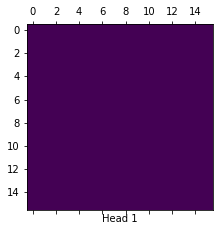

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


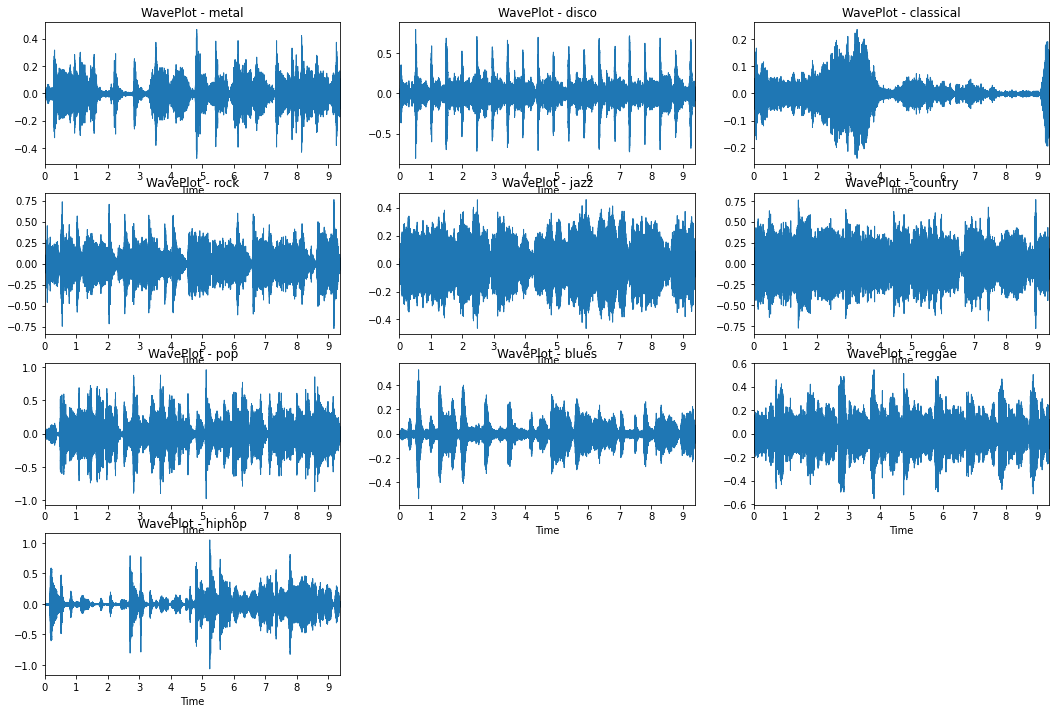

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00491769  0.00079466 -0.00472181 ... -0.00976524 -0.02779662
 -0.00414588]
X range: [0.9517748355865479, -0.8081738352775574]


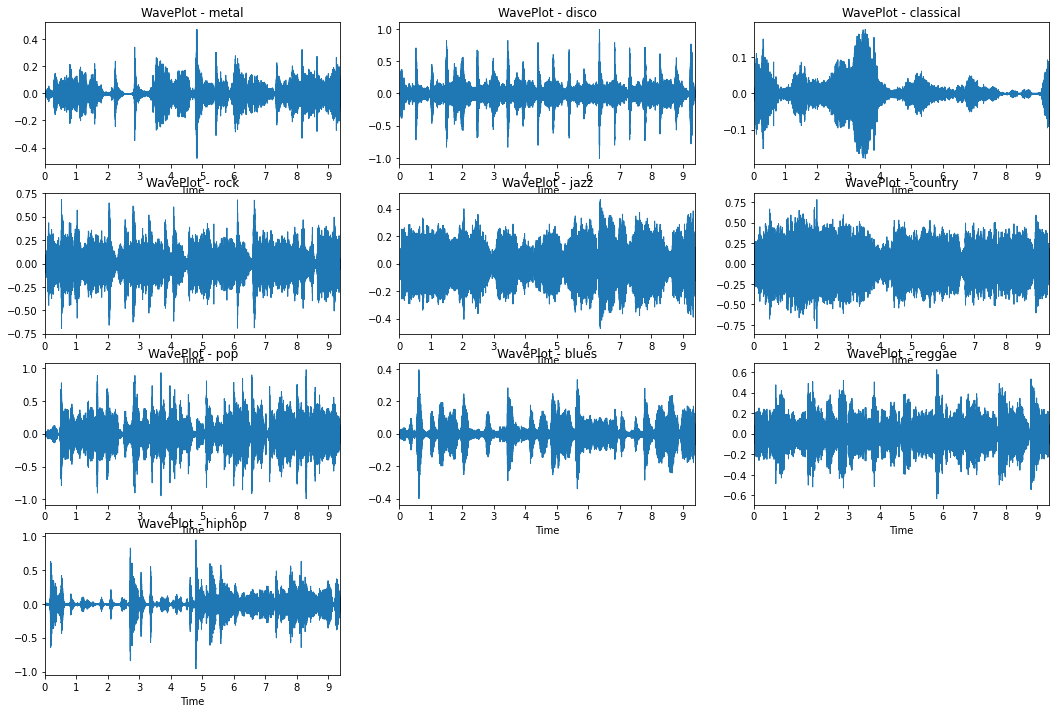

Epoch 17 Loss 4.4032; Perplexity (exp of loss_per_word): 81.70808; Accuracy 0.1278
Time taken for 1 epoch: 17.20 secs

Epoch 18 Loss 4.3721; Perplexity (exp of loss_per_word): 79.20824; Accuracy 0.1310
Time taken for 1 epoch: 17.06 secs

Epoch 19 Loss 4.3499; Perplexity (exp of loss_per_word): 77.47059; Accuracy 0.1341
Time taken for 1 epoch: 17.09 secs

Epoch 20 Loss 4.3096; Perplexity (exp of loss_per_word): 74.41270; Accuracy 0.1381
Time taken for 1 epoch: 17.08 secs

Epoch 21 Loss 4.2835; Perplexity (exp of loss_per_word): 72.49664; Accuracy 0.1415
Time taken for 1 epoch: 17.08 secs

Saving checkpoint for epoch 21 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-5
---------------------------Epoch: 20 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 4.7749; Per

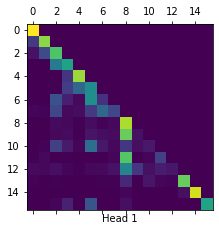

transformer_layer_17_attention
(550, 1, 16, 16)


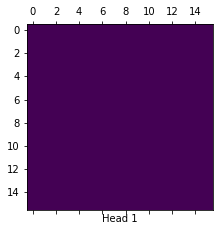

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


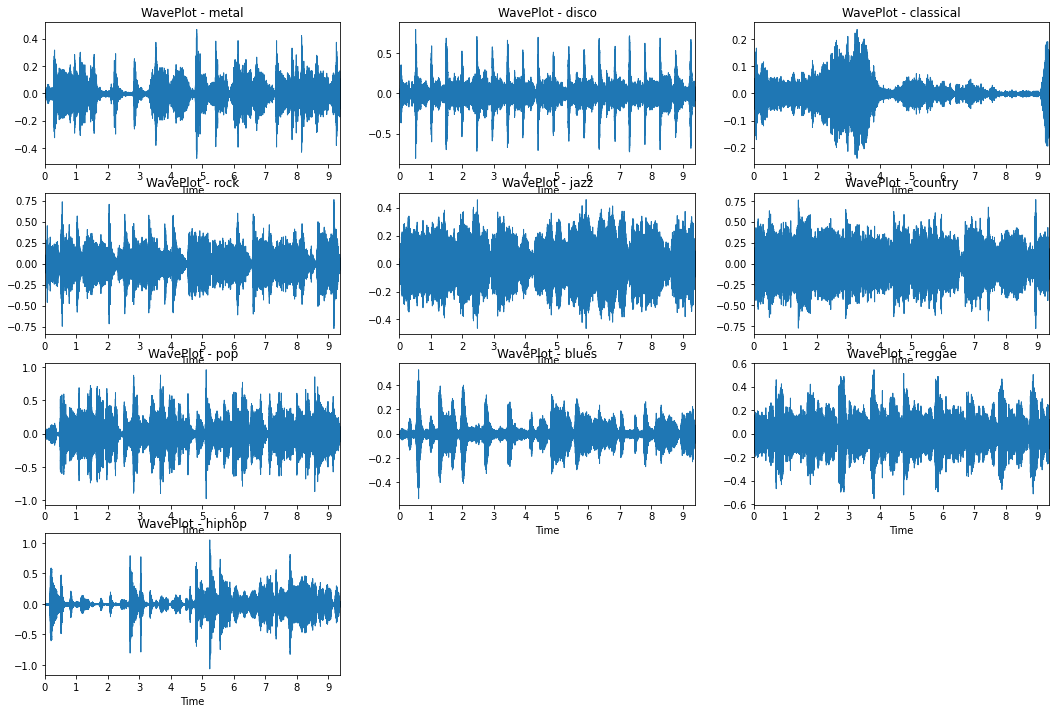

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00689101  0.00198435 -0.001896   ... -0.01340805 -0.02507939
 -0.01258906]
X range: [1.060357928276062, -0.9288843274116516]


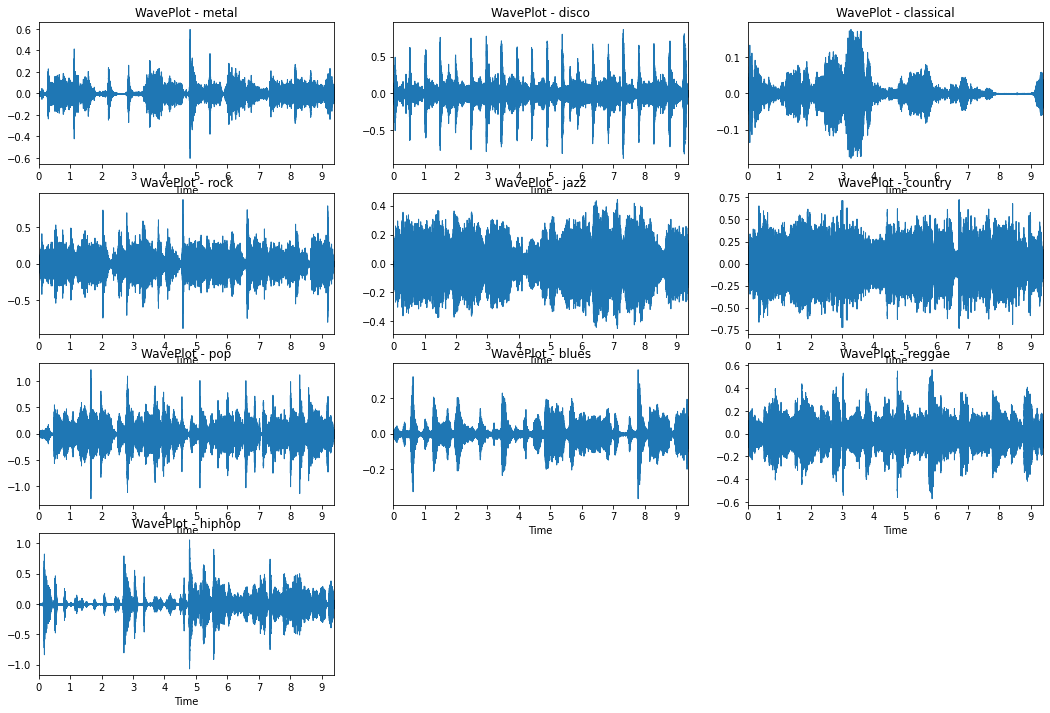

------------------------------- Auto-regressive Sampling in process..........-----------------------------
Sampled output shape: [  4 881] (with Start Token...)
tf.Tensor(
[[512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]], shape=(4, 881), dtype=int64)
(4, 28160, 1)
-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------
X':  [ 0.00831394 -0.00053046 -0.00568363 ... -0.00341901 -0.00954305
  0.00404466]
X range: [0.01038975641131401, -0.009543051943182945]


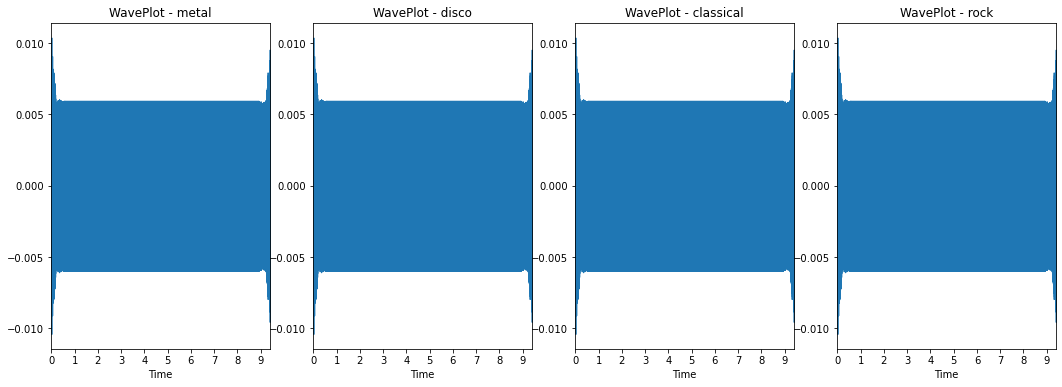

Epoch 22 Loss 4.2460; Perplexity (exp of loss_per_word): 69.82401; Accuracy 0.1447
Time taken for 1 epoch: 17.04 secs

Epoch 23 Loss 4.2109; Perplexity (exp of loss_per_word): 67.41486; Accuracy 0.1488
Time taken for 1 epoch: 17.04 secs

Epoch 24 Loss 4.1781; Perplexity (exp of loss_per_word): 65.24328; Accuracy 0.1534
Time taken for 1 epoch: 17.07 secs

Epoch 25 Loss 4.1432; Perplexity (exp of loss_per_word): 63.00389; Accuracy 0.1569
Time taken for 1 epoch: 17.08 secs

Epoch 26 Loss 4.1192; Perplexity (exp of loss_per_word): 61.50756; Accuracy 0.1608
Time taken for 1 epoch: 17.05 secs

Saving checkpoint for epoch 26 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-6
---------------------------Epoch: 25 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 4.7618; Per

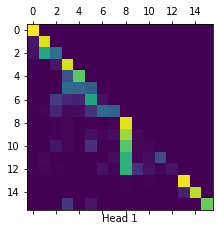

transformer_layer_17_attention
(550, 1, 16, 16)


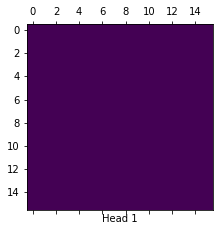

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


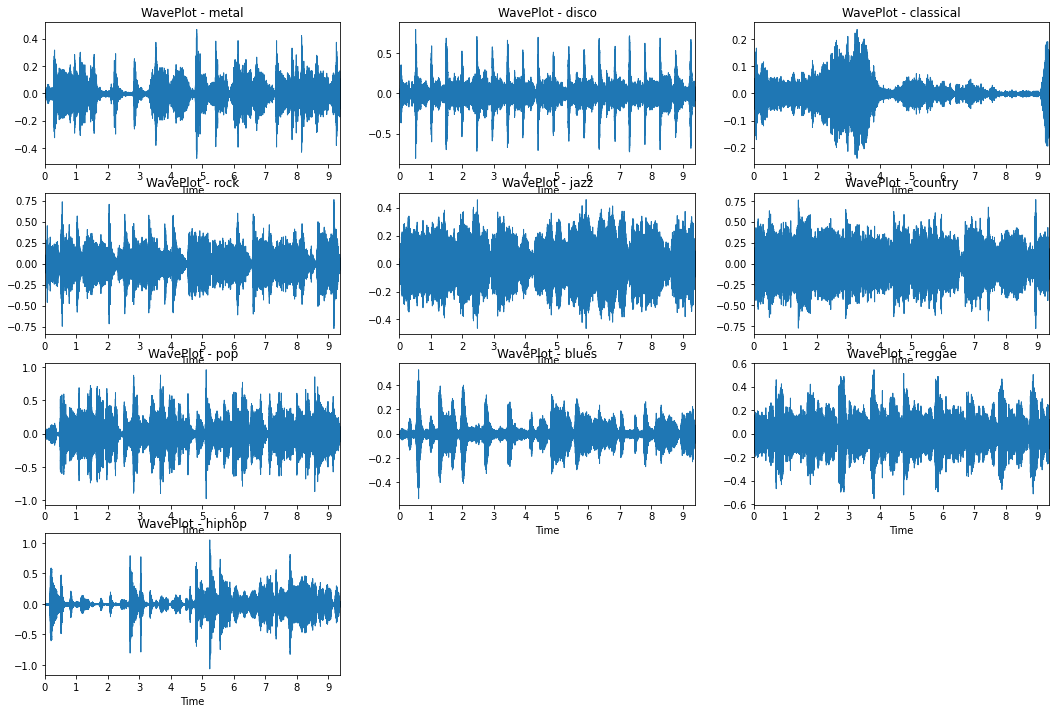

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00681055  0.00071549 -0.00523533 ... -0.01821021 -0.02341885
 -0.00345474]
X range: [1.064063310623169, -1.008206844329834]


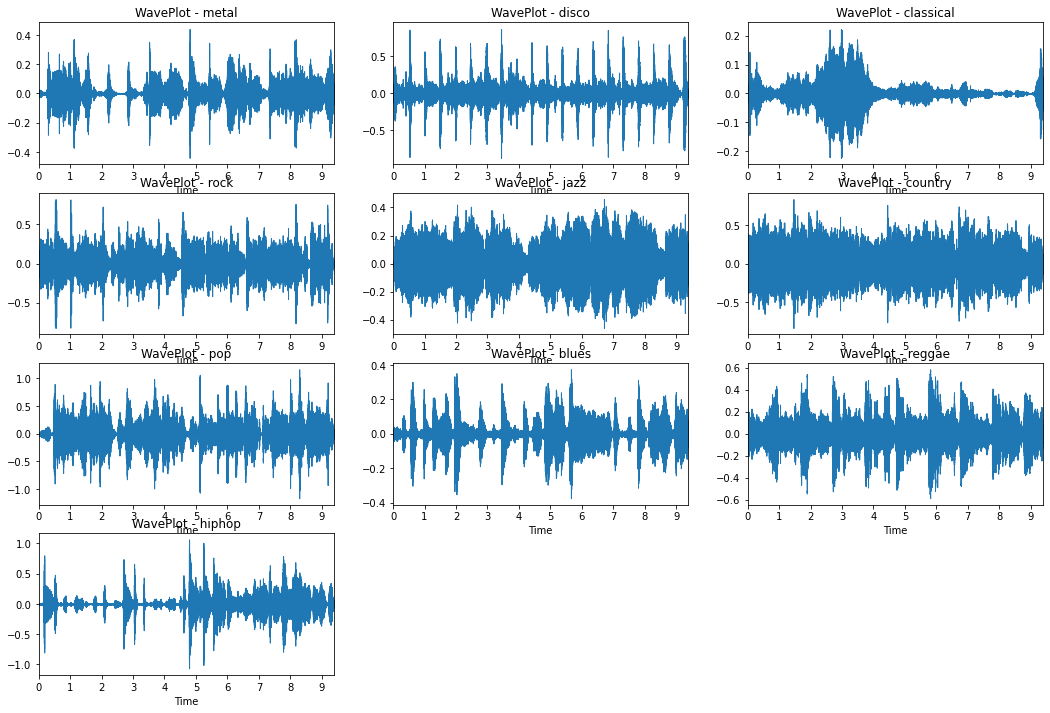

Epoch 27 Loss 4.0672; Perplexity (exp of loss_per_word): 58.39539; Accuracy 0.1659
Time taken for 1 epoch: 17.29 secs

Epoch 28 Loss 4.0419; Perplexity (exp of loss_per_word): 56.93402; Accuracy 0.1693
Time taken for 1 epoch: 17.07 secs

Epoch 29 Loss 4.0132; Perplexity (exp of loss_per_word): 55.32451; Accuracy 0.1731
Time taken for 1 epoch: 17.08 secs

Epoch 30 Loss 3.9642; Perplexity (exp of loss_per_word): 52.67857; Accuracy 0.1799
Time taken for 1 epoch: 17.06 secs

Epoch 31 Loss 3.9343; Perplexity (exp of loss_per_word): 51.12828; Accuracy 0.1824
Time taken for 1 epoch: 17.20 secs

Saving checkpoint for epoch 31 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-7
---------------------------Epoch: 30 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 4.7988; Per

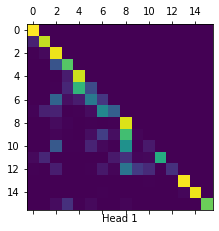

transformer_layer_17_attention
(550, 1, 16, 16)


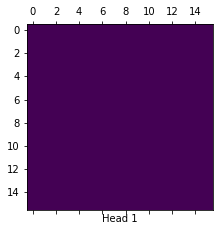

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


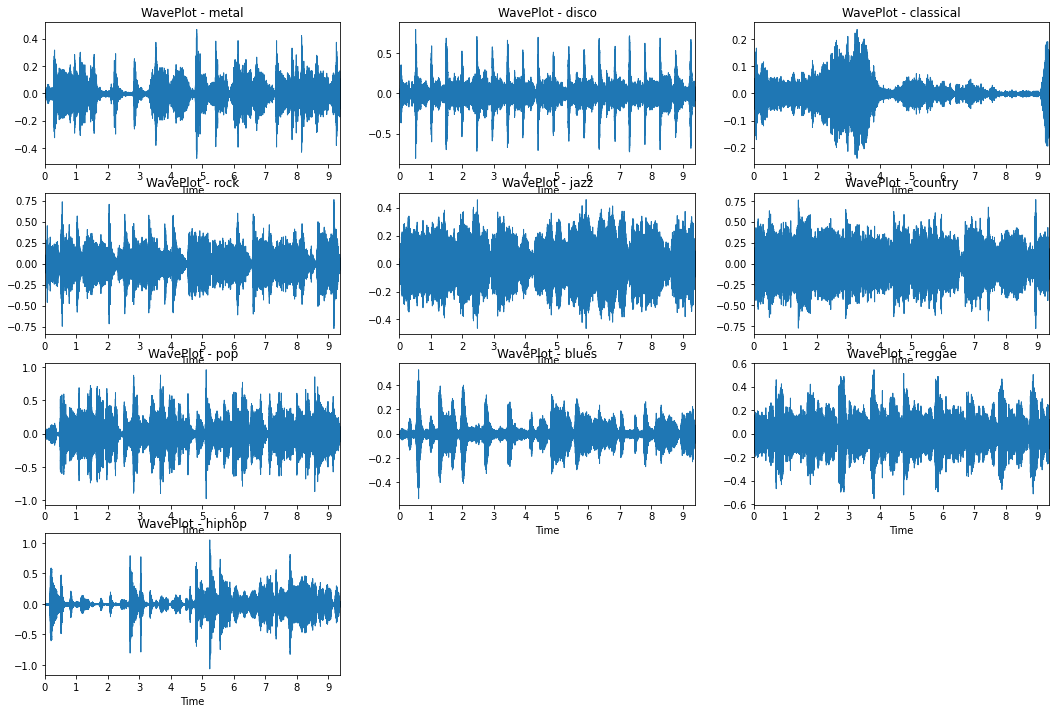

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00674349  0.00187939 -0.00218529 ... -0.01222343 -0.02334505
 -0.01001958]
X range: [0.9502501487731934, -0.9101366400718689]


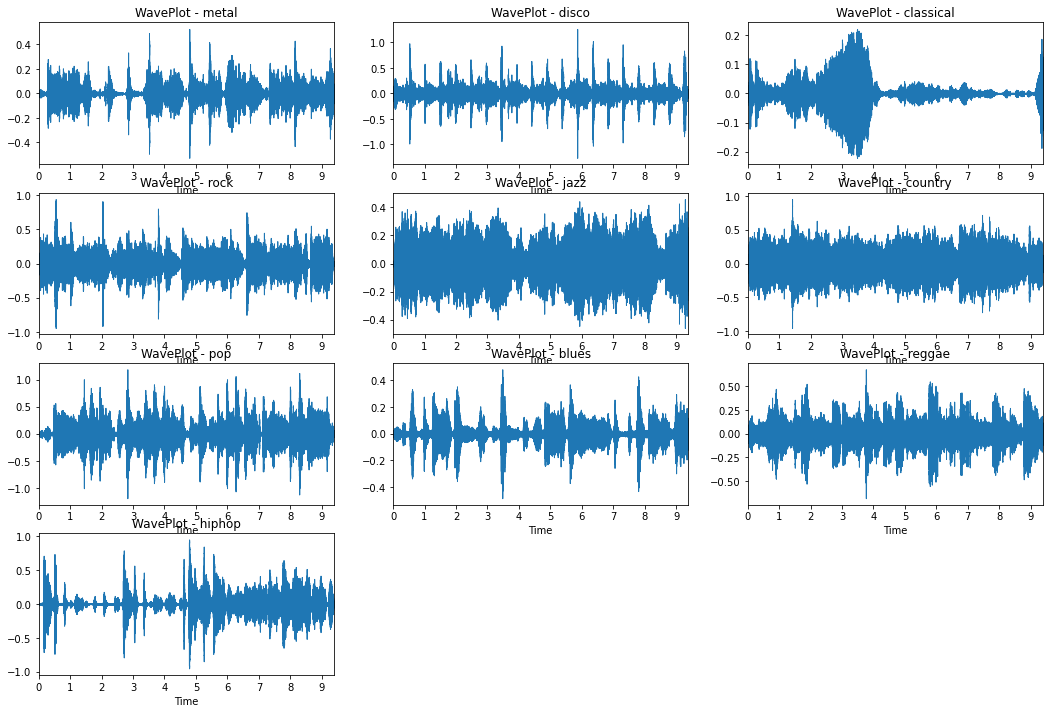

Epoch 32 Loss 3.9029; Perplexity (exp of loss_per_word): 49.54559; Accuracy 0.1872
Time taken for 1 epoch: 17.16 secs

Epoch 33 Loss 3.8719; Perplexity (exp of loss_per_word): 48.03584; Accuracy 0.1914
Time taken for 1 epoch: 16.35 secs

Epoch 34 Loss 3.8370; Perplexity (exp of loss_per_word): 46.38685; Accuracy 0.1950
Time taken for 1 epoch: 17.01 secs

Epoch 35 Loss 3.8052; Perplexity (exp of loss_per_word): 44.93351; Accuracy 0.1996
Time taken for 1 epoch: 17.08 secs

Epoch 36 Loss 3.7715; Perplexity (exp of loss_per_word): 43.44638; Accuracy 0.2040
Time taken for 1 epoch: 17.08 secs

Saving checkpoint for epoch 36 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-8
---------------------------Epoch: 35 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 4.8740; Per

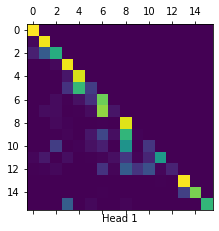

transformer_layer_17_attention
(550, 1, 16, 16)


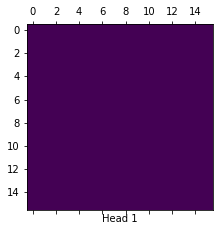

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


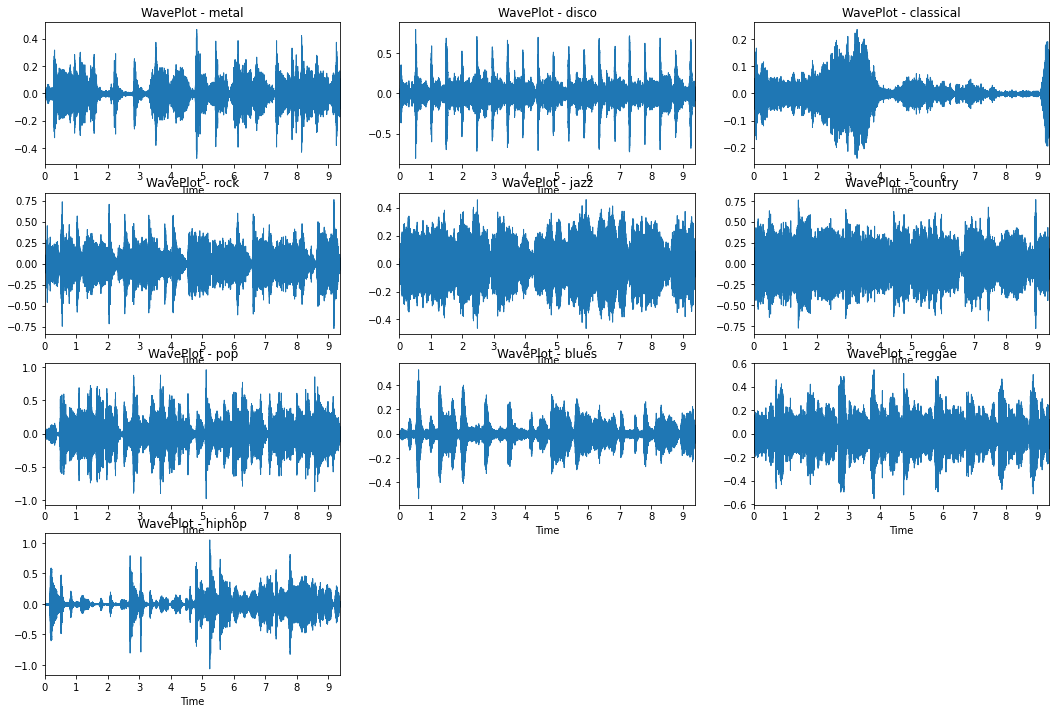

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.005859    0.00321027  0.00044577 ... -0.02288334 -0.02784456
 -0.0044072 ]
X range: [1.0060992240905762, -0.998707115650177]


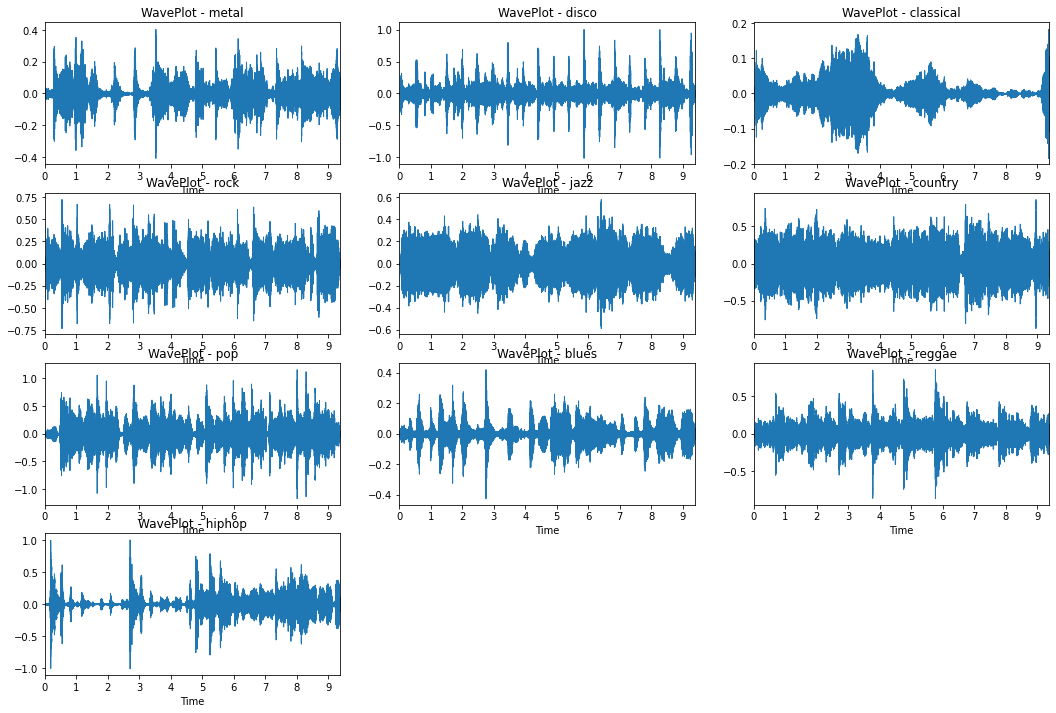

Epoch 37 Loss 3.7291; Perplexity (exp of loss_per_word): 41.64338; Accuracy 0.2102
Time taken for 1 epoch: 17.22 secs

Epoch 38 Loss 3.6710; Perplexity (exp of loss_per_word): 39.29182; Accuracy 0.2183
Time taken for 1 epoch: 17.10 secs

Epoch 39 Loss 3.6174; Perplexity (exp of loss_per_word): 37.23889; Accuracy 0.2250
Time taken for 1 epoch: 17.10 secs

Epoch 40 Loss 3.5599; Perplexity (exp of loss_per_word): 35.15865; Accuracy 0.2344
Time taken for 1 epoch: 17.15 secs

Epoch 41 Loss 3.5124; Perplexity (exp of loss_per_word): 33.52702; Accuracy 0.2407
Time taken for 1 epoch: 17.06 secs

Saving checkpoint for epoch 41 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-9
---------------------------Epoch: 40 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 5.0154; Per

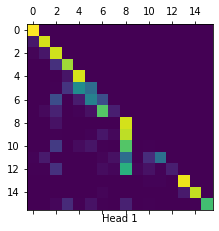

transformer_layer_17_attention
(550, 1, 16, 16)


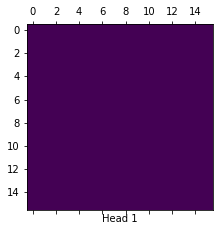

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


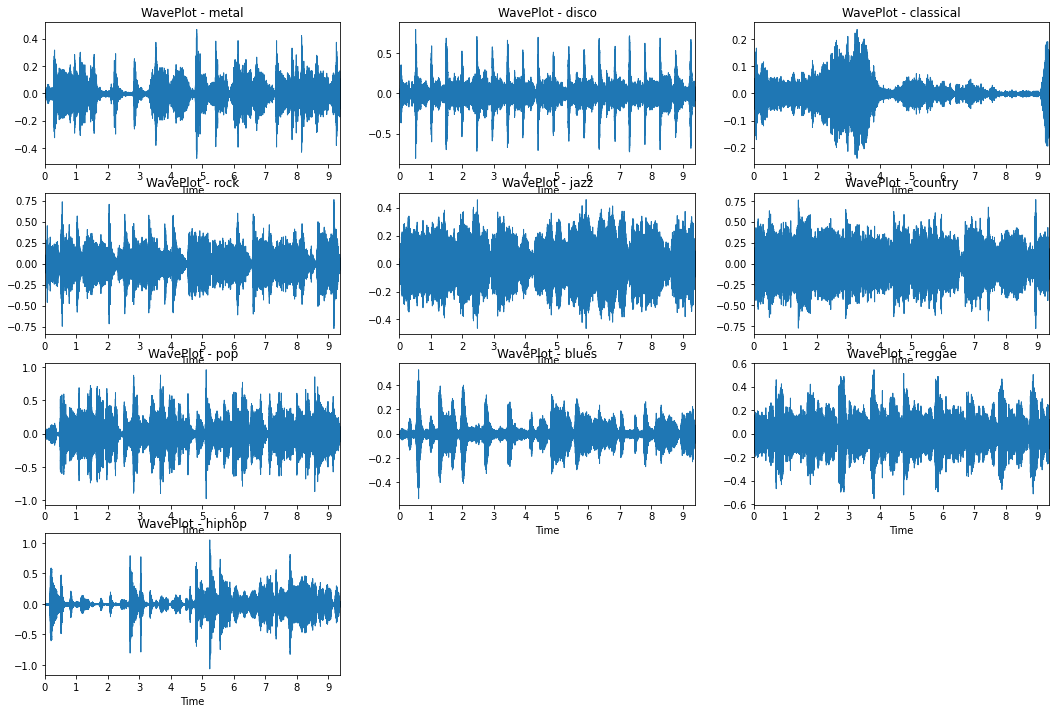

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00336768  0.00251979 -0.00426282 ... -0.0147259  -0.01544798
 -0.00338601]
X range: [0.9086717367172241, -1.0529824495315552]


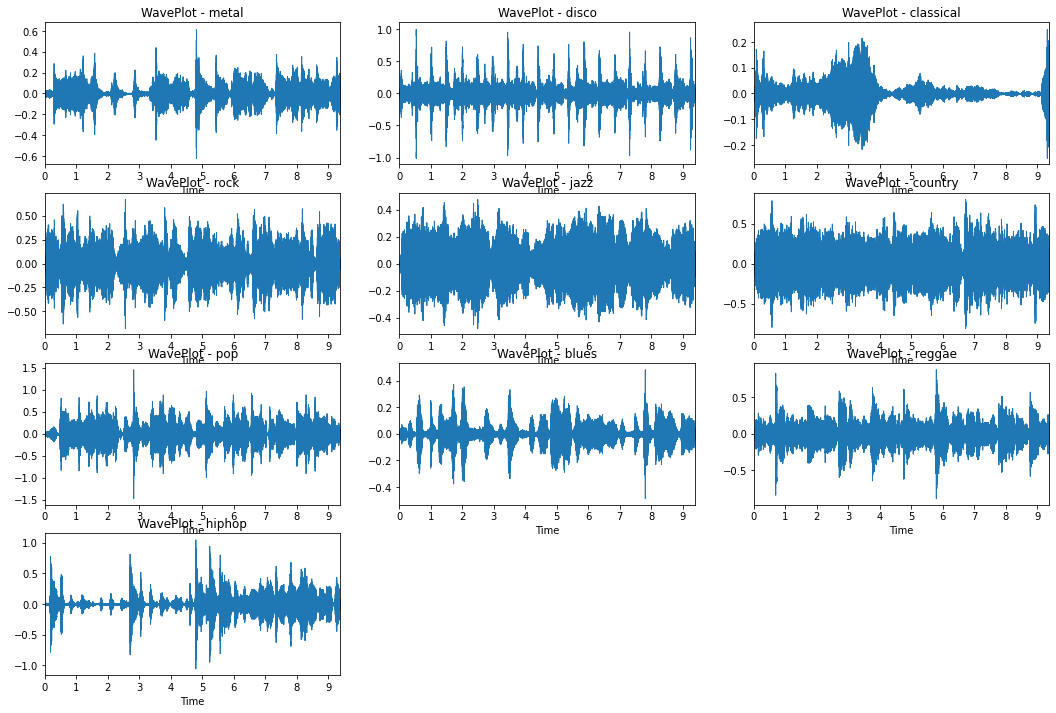

------------------------------- Auto-regressive Sampling in process..........-----------------------------
Sampled output shape: [  4 881] (with Start Token...)
tf.Tensor(
[[512  32  32 ...  32  32  32]
 [512  32  32 ...  32  32  32]
 [512  32  32 ...  32  32  32]
 [512  32  32 ...  32  32  32]], shape=(4, 881), dtype=int64)
(4, 28160, 1)
-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------
X':  [ 0.0099448   0.00454166 -0.00331039 ... -0.00705973 -0.01008597
  0.00133421]
X range: [0.03767743706703186, -0.043433062732219696]


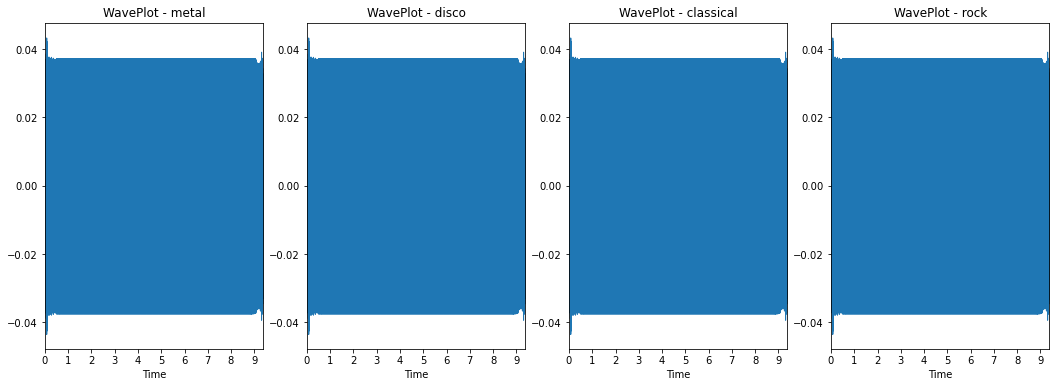

Epoch 42 Loss 3.4574; Perplexity (exp of loss_per_word): 31.73591; Accuracy 0.2490
Time taken for 1 epoch: 16.53 secs

Epoch 43 Loss 3.4012; Perplexity (exp of loss_per_word): 29.99983; Accuracy 0.2573
Time taken for 1 epoch: 17.21 secs

Epoch 44 Loss 3.3529; Perplexity (exp of loss_per_word): 28.58448; Accuracy 0.2652
Time taken for 1 epoch: 17.03 secs

Epoch 45 Loss 3.2949; Perplexity (exp of loss_per_word): 26.97462; Accuracy 0.2736
Time taken for 1 epoch: 16.99 secs

Epoch 46 Loss 3.2514; Perplexity (exp of loss_per_word): 25.82662; Accuracy 0.2802
Time taken for 1 epoch: 16.99 secs

Saving checkpoint for epoch 46 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-10
---------------------------Epoch: 45 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 5.2393; Pe

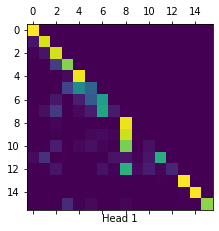

transformer_layer_17_attention
(550, 1, 16, 16)


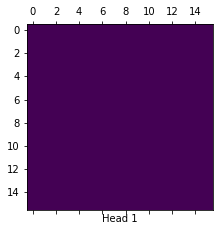

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


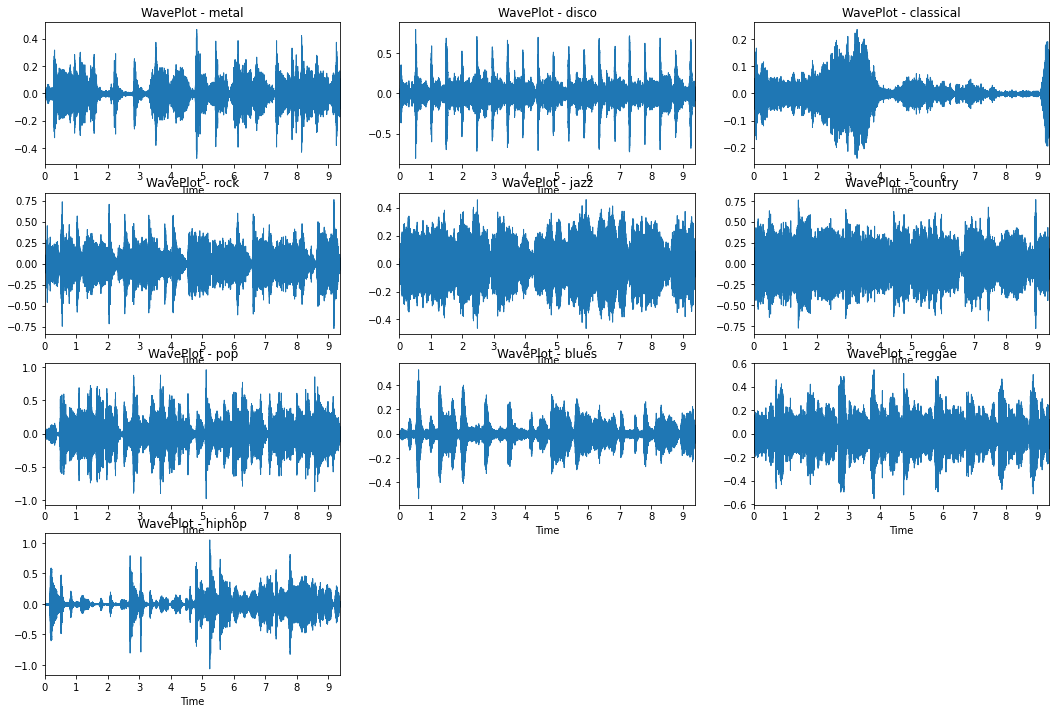

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00714763  0.00168032 -0.00354576 ... -0.00596525 -0.00992931
  0.00698367]
X range: [0.9217360019683838, -0.9948375225067139]


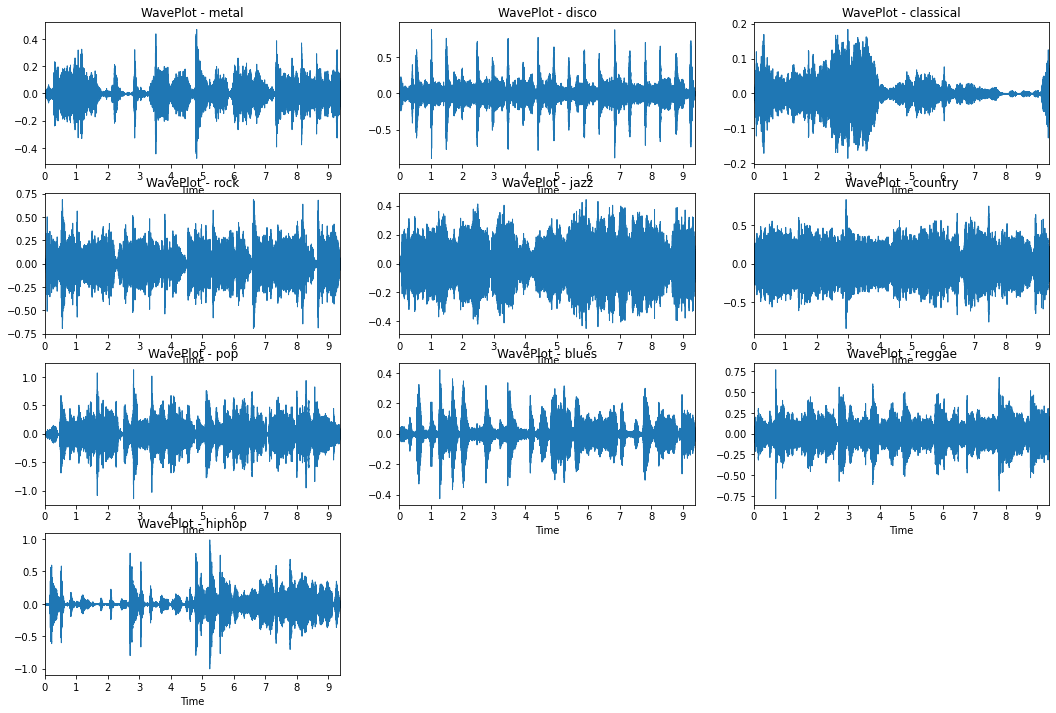

Epoch 47 Loss 3.1995; Perplexity (exp of loss_per_word): 24.52055; Accuracy 0.2884
Time taken for 1 epoch: 17.23 secs

Epoch 48 Loss 3.1502; Perplexity (exp of loss_per_word): 23.34114; Accuracy 0.2972
Time taken for 1 epoch: 17.05 secs

Epoch 49 Loss 3.1006; Perplexity (exp of loss_per_word): 22.21128; Accuracy 0.3040
Time taken for 1 epoch: 17.07 secs

Epoch 50 Loss 3.0486; Perplexity (exp of loss_per_word): 21.08507; Accuracy 0.3127
Time taken for 1 epoch: 16.99 secs

Epoch 51 Loss 3.0120; Perplexity (exp of loss_per_word): 20.32837; Accuracy 0.3190
Time taken for 1 epoch: 17.03 secs

Saving checkpoint for epoch 51 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-11
---------------------------Epoch: 50 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 5.4799; Pe

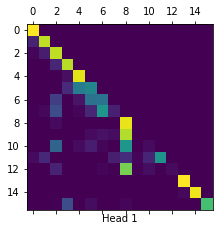

transformer_layer_17_attention
(550, 1, 16, 16)


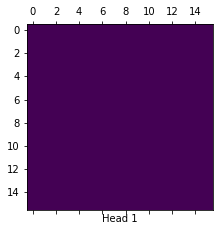

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


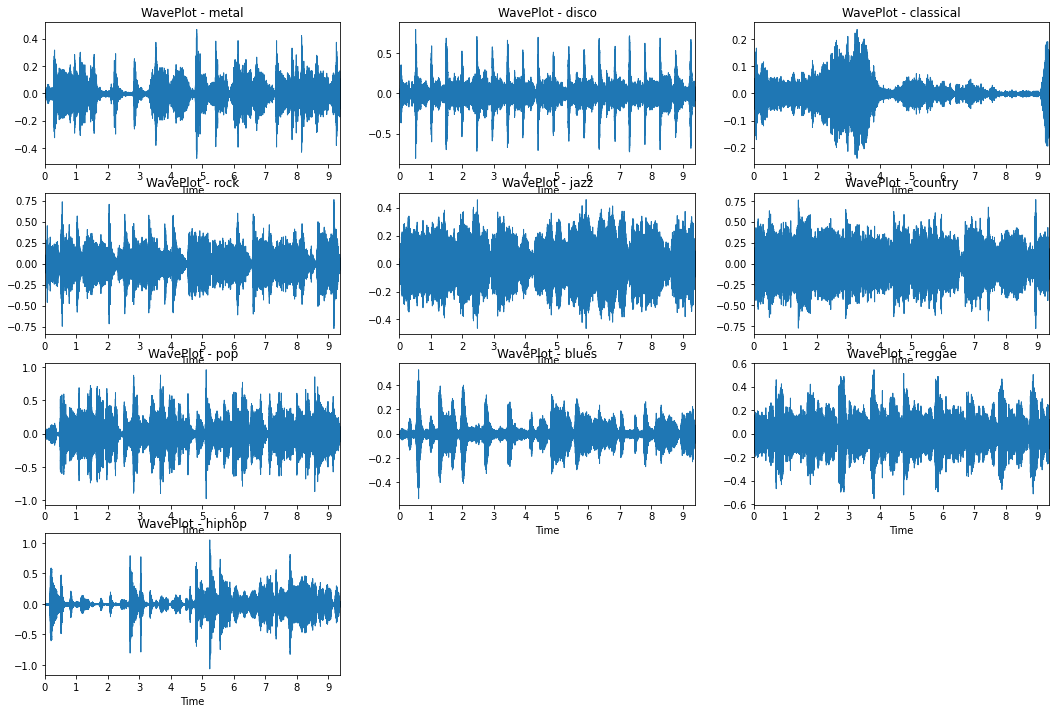

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00606081  0.00234644 -0.00308259 ... -0.00572843 -0.00846499
  0.00612832]
X range: [0.8627088665962219, -0.9327267408370972]


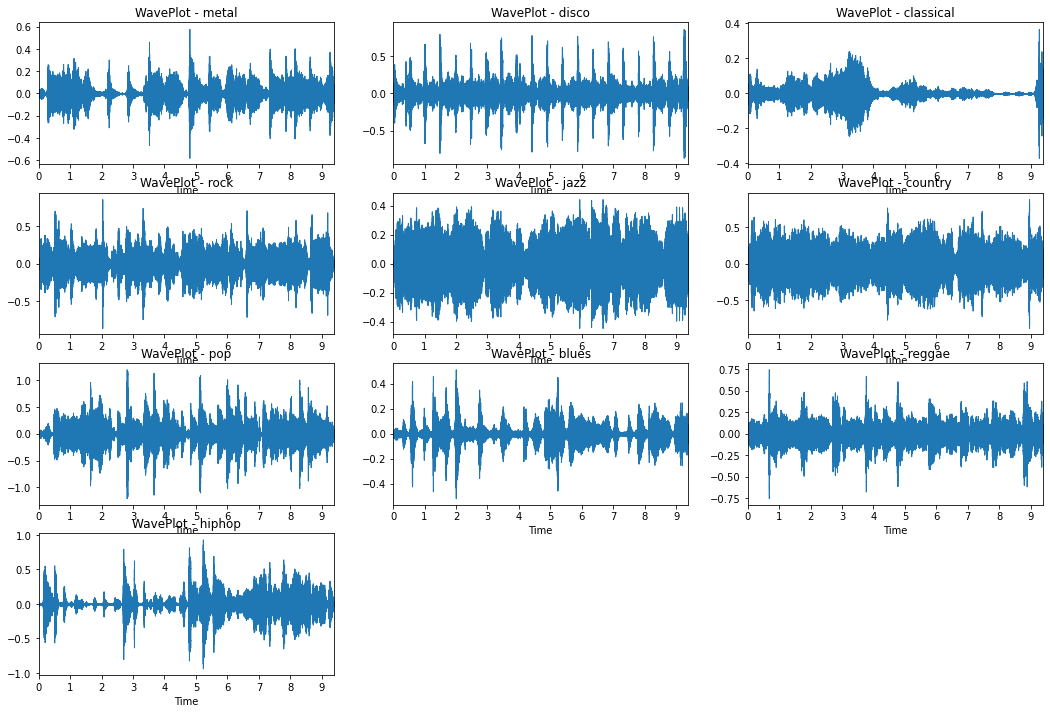

Epoch 52 Loss 2.9652; Perplexity (exp of loss_per_word): 19.39877; Accuracy 0.3259
Time taken for 1 epoch: 17.15 secs

Epoch 53 Loss 2.9190; Perplexity (exp of loss_per_word): 18.52345; Accuracy 0.3333
Time taken for 1 epoch: 17.00 secs

Epoch 54 Loss 2.8786; Perplexity (exp of loss_per_word): 17.78898; Accuracy 0.3401
Time taken for 1 epoch: 17.00 secs

Epoch 55 Loss 2.8366; Perplexity (exp of loss_per_word): 17.05706; Accuracy 0.3473
Time taken for 1 epoch: 17.00 secs

Epoch 56 Loss 2.7954; Perplexity (exp of loss_per_word): 16.36999; Accuracy 0.3549
Time taken for 1 epoch: 17.13 secs

Saving checkpoint for epoch 56 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-12
---------------------------Epoch: 55 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 5.7556; Pe

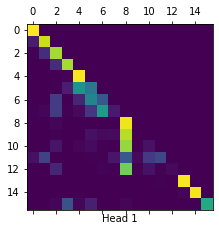

transformer_layer_17_attention
(550, 1, 16, 16)


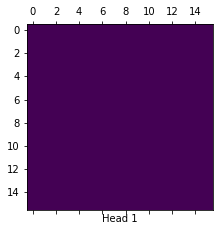

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


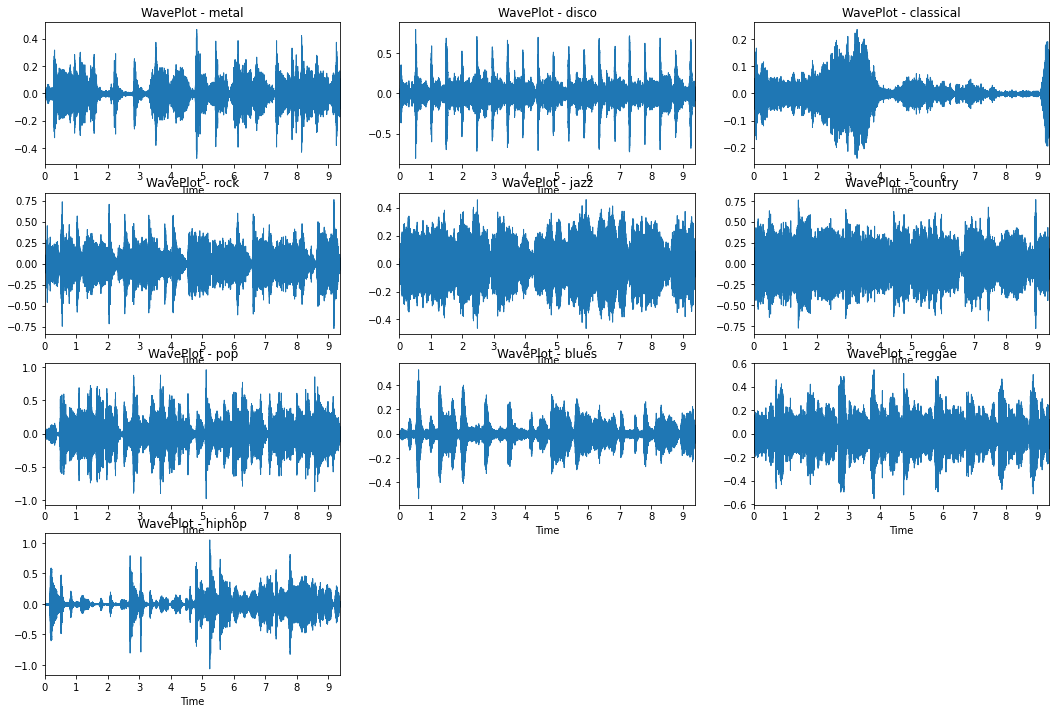

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00369363  0.0021833  -0.00425821 ... -0.01170916 -0.01204392
 -0.01124144]
X range: [1.0902135372161865, -1.0685490369796753]


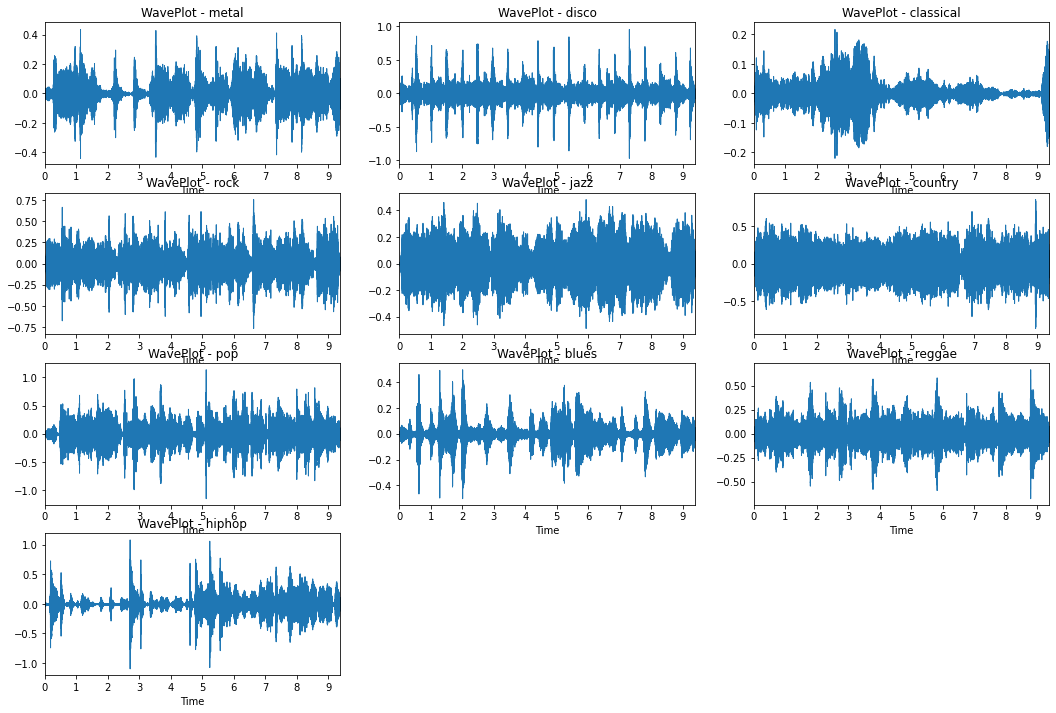

Epoch 57 Loss 2.7488; Perplexity (exp of loss_per_word): 15.62420; Accuracy 0.3623
Time taken for 1 epoch: 17.40 secs

Epoch 58 Loss 2.7075; Perplexity (exp of loss_per_word): 14.99195; Accuracy 0.3696
Time taken for 1 epoch: 17.67 secs

Epoch 59 Loss 2.6760; Perplexity (exp of loss_per_word): 14.52653; Accuracy 0.3748
Time taken for 1 epoch: 17.01 secs

Epoch 60 Loss 2.6359; Perplexity (exp of loss_per_word): 13.95643; Accuracy 0.3813
Time taken for 1 epoch: 17.03 secs

Epoch 61 Loss 2.6003; Perplexity (exp of loss_per_word): 13.46786; Accuracy 0.3875
Time taken for 1 epoch: 17.01 secs

Saving checkpoint for epoch 61 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-13
---------------------------Epoch: 60 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 6.0769; Pe

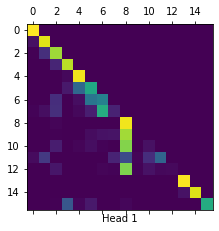

transformer_layer_17_attention
(550, 1, 16, 16)


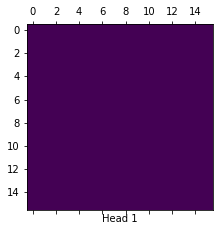

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


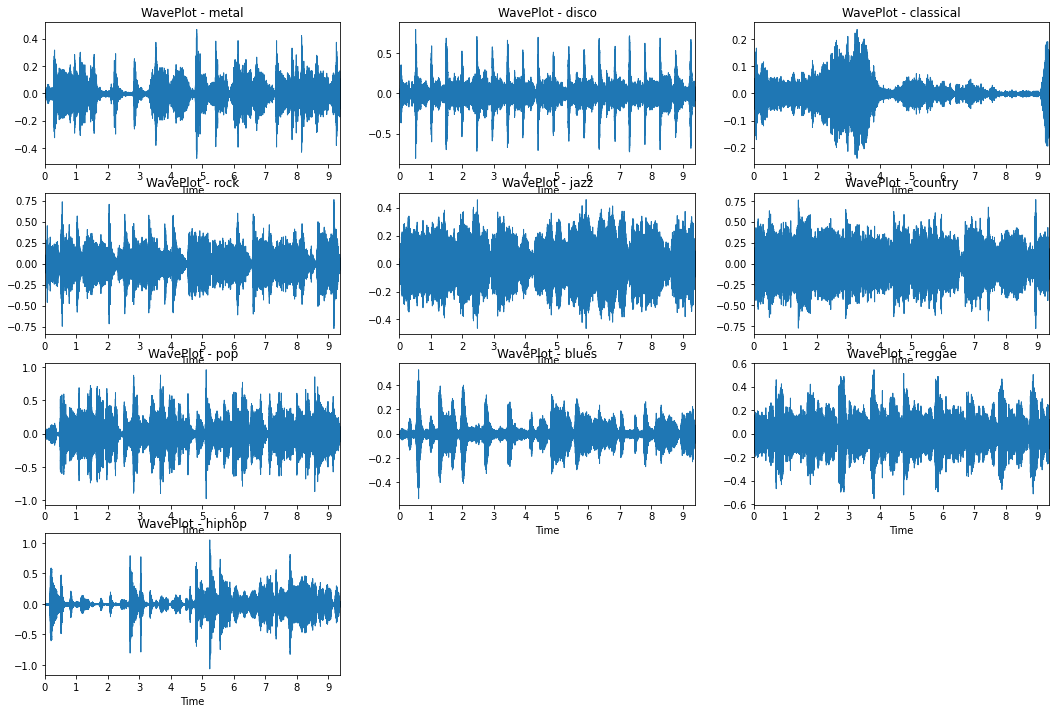

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00531159  0.0026449  -0.00366065 ... -0.01094344 -0.01381521
 -0.0056904 ]
X range: [0.9221586585044861, -0.9963966012001038]


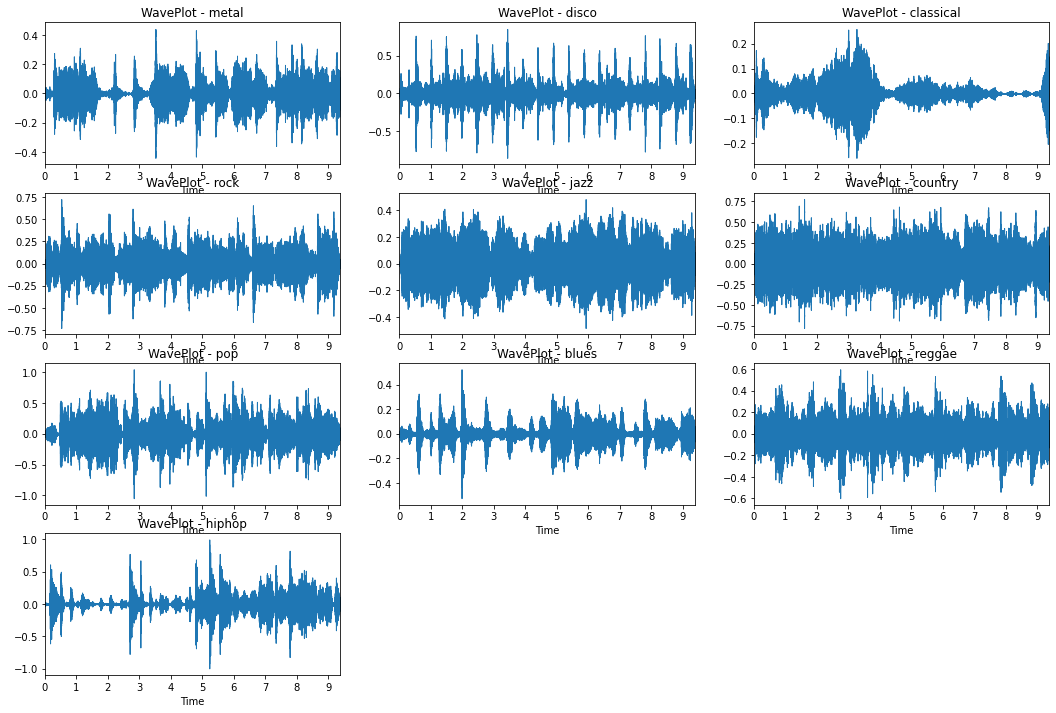

------------------------------- Auto-regressive Sampling in process..........-----------------------------
Sampled output shape: [  4 881] (with Start Token...)
tf.Tensor(
[[512  32  32 ...  32  32  32]
 [512  32  32 ...  32  32  32]
 [512  32  32 ...  32  32  32]
 [512  32  32 ...  32  32  32]], shape=(4, 881), dtype=int64)
(4, 28160, 1)
-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------
X':  [ 0.0099448   0.00454166 -0.00331039 ... -0.00705973 -0.01008597
  0.00133421]
X range: [0.03767743706703186, -0.043433062732219696]


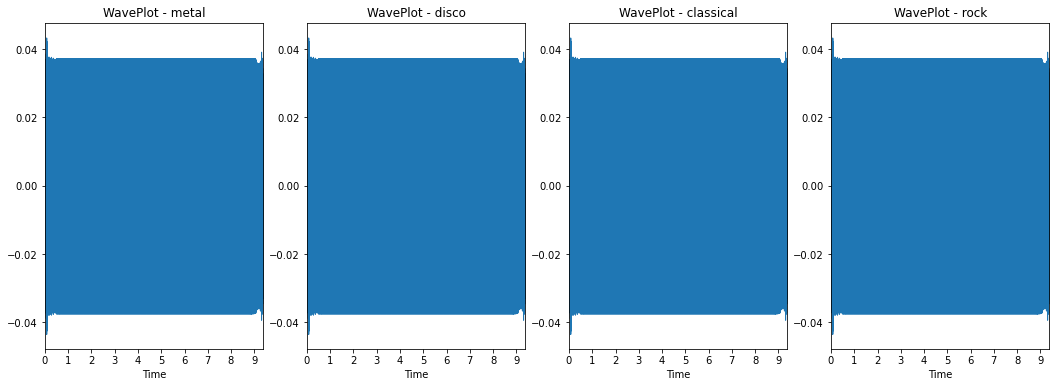

Epoch 62 Loss 2.5628; Perplexity (exp of loss_per_word): 12.97271; Accuracy 0.3943
Time taken for 1 epoch: 17.13 secs

Epoch 63 Loss 2.5266; Perplexity (exp of loss_per_word): 12.51147; Accuracy 0.4002
Time taken for 1 epoch: 17.02 secs

Epoch 64 Loss 2.4895; Perplexity (exp of loss_per_word): 12.05566; Accuracy 0.4071
Time taken for 1 epoch: 17.01 secs

Epoch 65 Loss 2.4630; Perplexity (exp of loss_per_word): 11.73948; Accuracy 0.4112
Time taken for 1 epoch: 17.00 secs

Epoch 66 Loss 2.4206; Perplexity (exp of loss_per_word): 11.25207; Accuracy 0.4196
Time taken for 1 epoch: 17.02 secs

Saving checkpoint for epoch 66 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-14
---------------------------Epoch: 65 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 6.3595; Pe

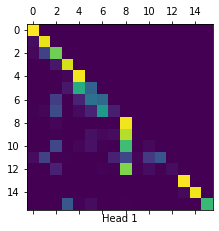

transformer_layer_17_attention
(550, 1, 16, 16)


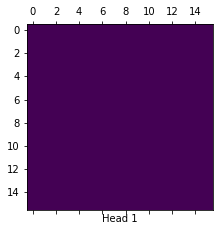

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


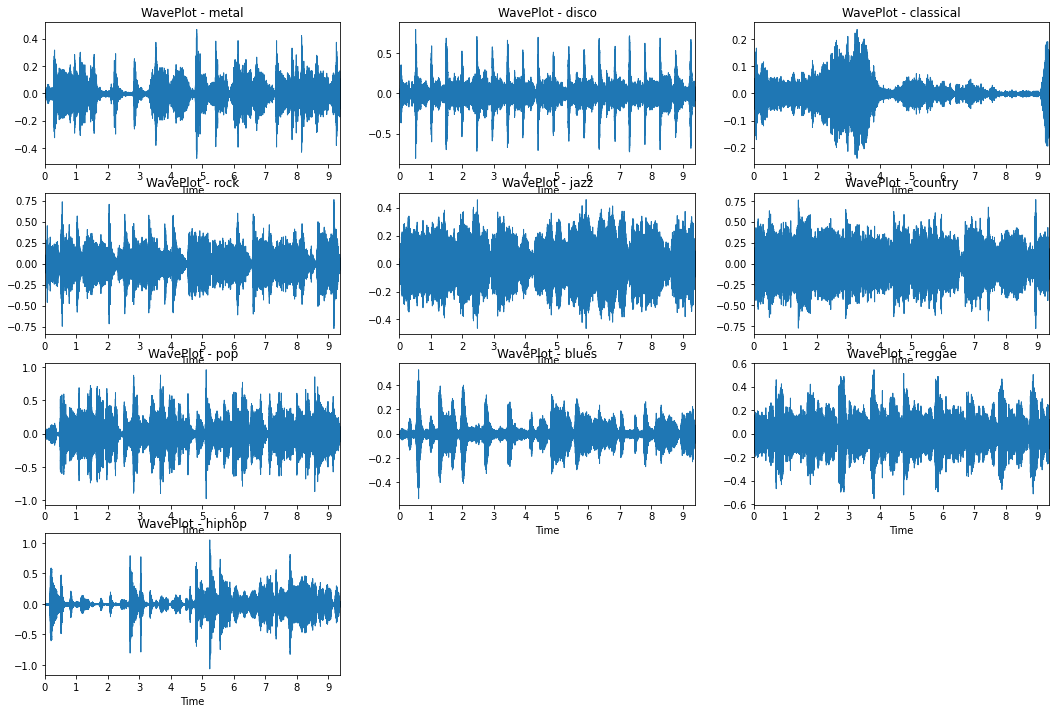

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00748258  0.00150214 -0.00184984 ... -0.0062016  -0.01054775
  0.00074597]
X range: [0.9666018486022949, -1.0497097969055176]


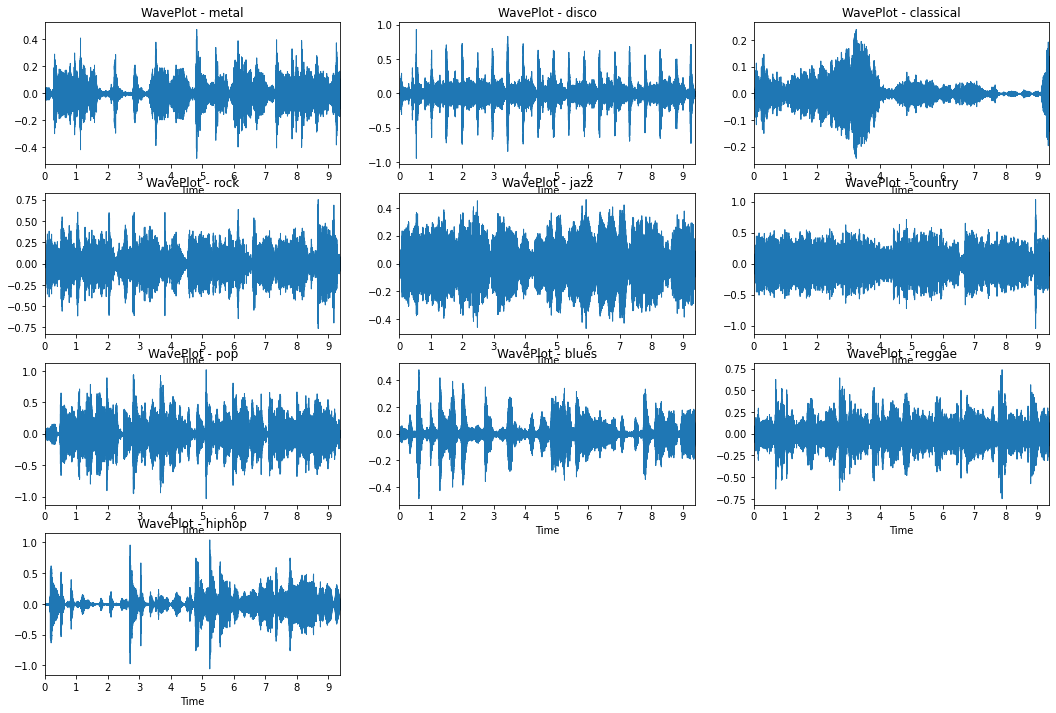

Epoch 67 Loss 2.3899; Perplexity (exp of loss_per_word): 10.91287; Accuracy 0.4250
Time taken for 1 epoch: 17.19 secs

Epoch 68 Loss 2.3584; Perplexity (exp of loss_per_word): 10.57399; Accuracy 0.4307
Time taken for 1 epoch: 17.02 secs

Epoch 69 Loss 2.3284; Perplexity (exp of loss_per_word): 10.26155; Accuracy 0.4355
Time taken for 1 epoch: 17.01 secs

Epoch 70 Loss 2.3008; Perplexity (exp of loss_per_word): 9.98245; Accuracy 0.4403
Time taken for 1 epoch: 17.04 secs

Epoch 71 Loss 2.2723; Perplexity (exp of loss_per_word): 9.70201; Accuracy 0.4462
Time taken for 1 epoch: 17.02 secs

Saving checkpoint for epoch 71 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-15
---------------------------Epoch: 70 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 6.6379; Perp

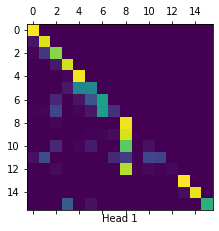

transformer_layer_17_attention
(550, 1, 16, 16)


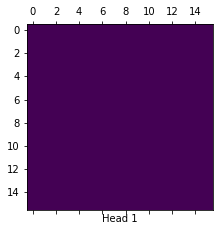

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


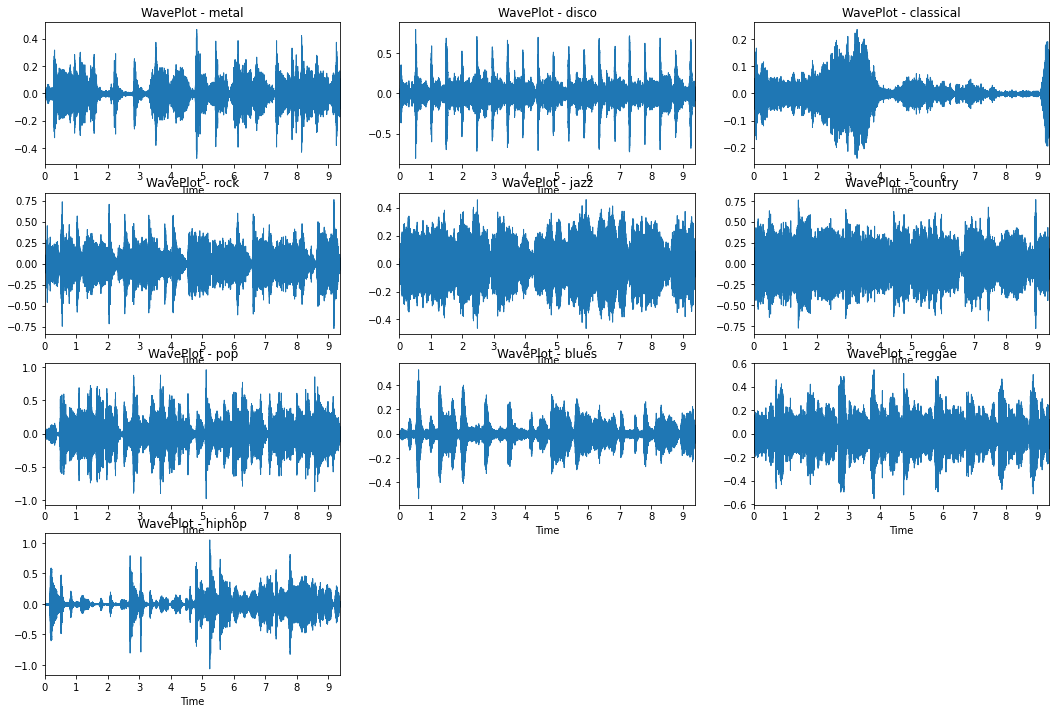

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00721822  0.00159218 -0.00277706 ... -0.01029154 -0.01471193
  0.00243731]
X range: [0.9037153124809265, -1.0558117628097534]


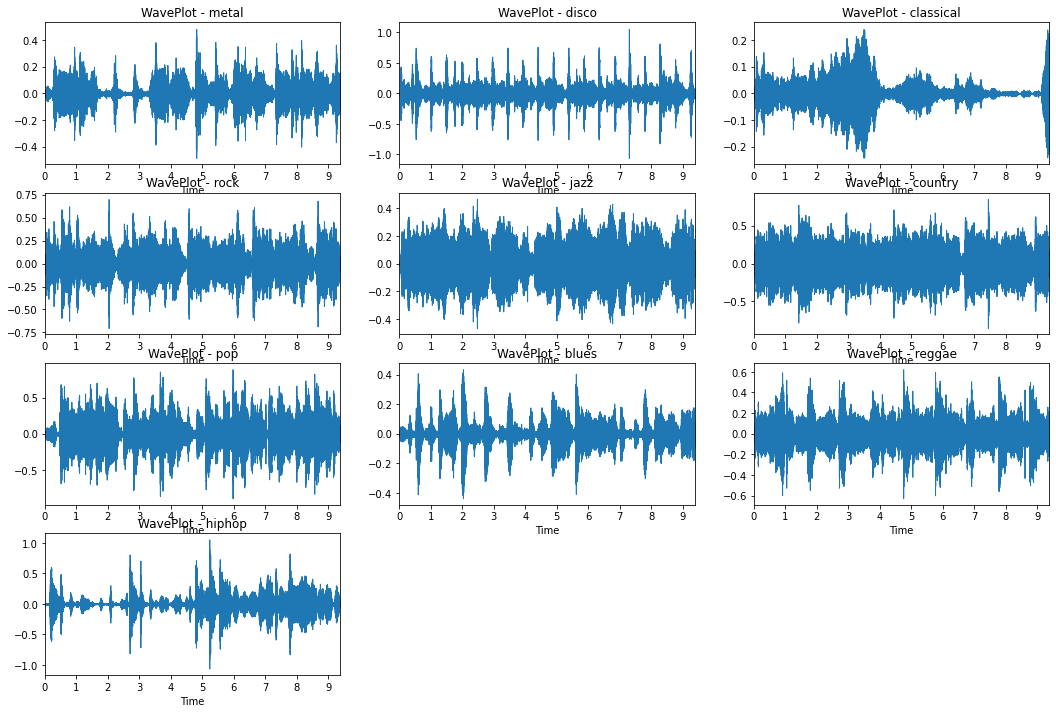

Epoch 72 Loss 2.2402; Perplexity (exp of loss_per_word): 9.39540; Accuracy 0.4518
Time taken for 1 epoch: 17.16 secs

Epoch 73 Loss 2.2156; Perplexity (exp of loss_per_word): 9.16721; Accuracy 0.4563
Time taken for 1 epoch: 17.01 secs

Epoch 74 Loss 2.1774; Perplexity (exp of loss_per_word): 8.82338; Accuracy 0.4632
Time taken for 1 epoch: 17.02 secs

Epoch 75 Loss 2.1546; Perplexity (exp of loss_per_word): 8.62472; Accuracy 0.4672
Time taken for 1 epoch: 17.01 secs

Epoch 76 Loss 2.1249; Perplexity (exp of loss_per_word): 8.37201; Accuracy 0.4731
Time taken for 1 epoch: 17.00 secs

Saving checkpoint for epoch 76 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-16
---------------------------Epoch: 75 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 6.9367; Perplex

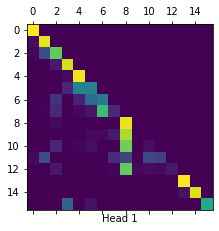

transformer_layer_17_attention
(550, 1, 16, 16)


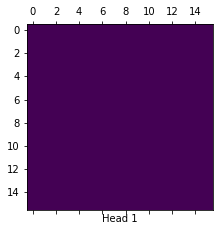

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


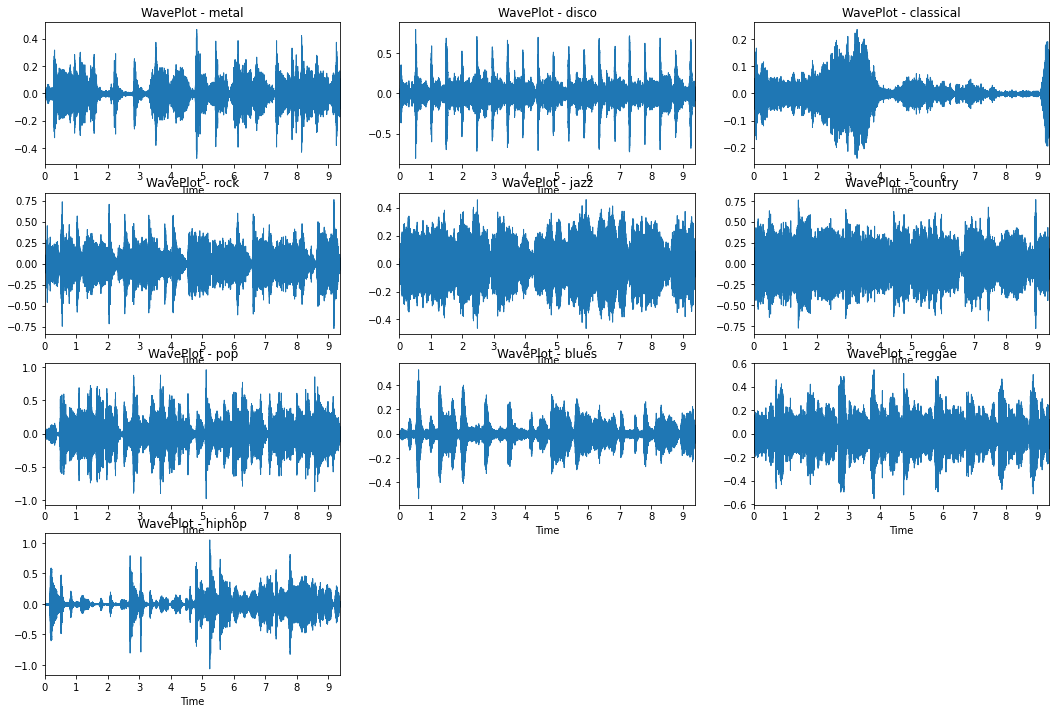

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00794007  0.00106445 -0.00223156 ... -0.00852355 -0.00935174
  0.00327428]
X range: [0.8917063474655151, -1.0365095138549805]


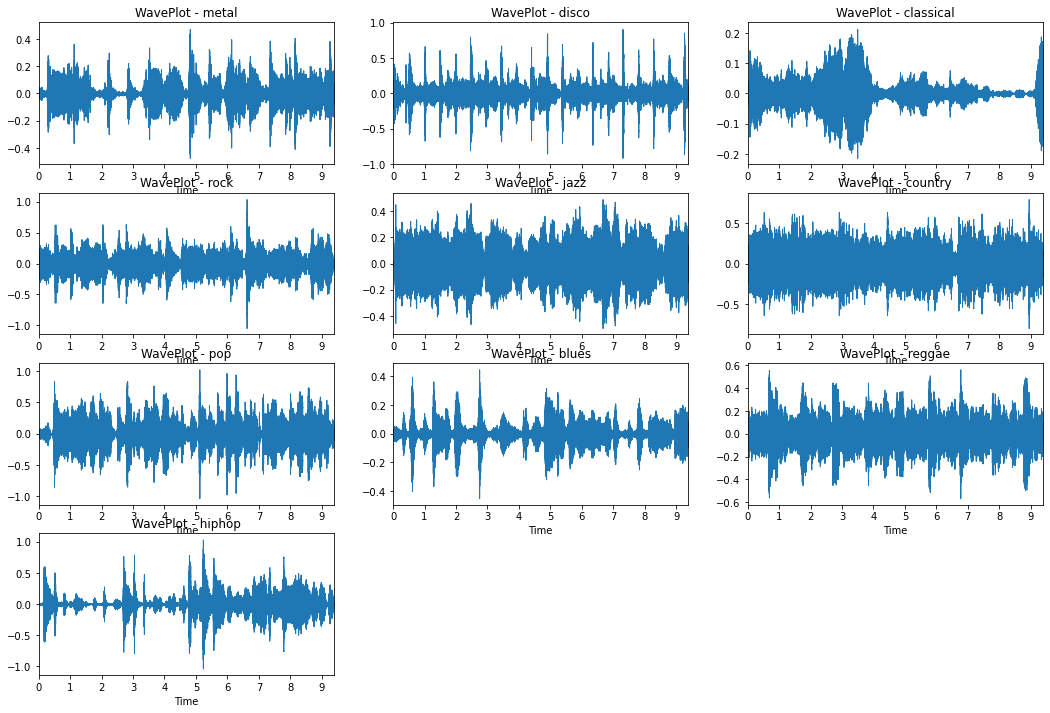

Epoch 77 Loss 2.1030; Perplexity (exp of loss_per_word): 8.19088; Accuracy 0.4769
Time taken for 1 epoch: 16.94 secs

Epoch 78 Loss 2.0723; Perplexity (exp of loss_per_word): 7.94297; Accuracy 0.4832
Time taken for 1 epoch: 16.36 secs

Epoch 79 Loss 2.0507; Perplexity (exp of loss_per_word): 7.77301; Accuracy 0.4869
Time taken for 1 epoch: 16.67 secs

Epoch 80 Loss 2.0237; Perplexity (exp of loss_per_word): 7.56591; Accuracy 0.4925
Time taken for 1 epoch: 17.80 secs

Epoch 81 Loss 1.9957; Perplexity (exp of loss_per_word): 7.35749; Accuracy 0.4980
Time taken for 1 epoch: 17.11 secs

Saving checkpoint for epoch 81 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-17
---------------------------Epoch: 80 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 7.2136; Perplex

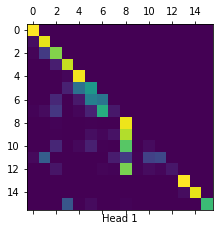

transformer_layer_17_attention
(550, 1, 16, 16)


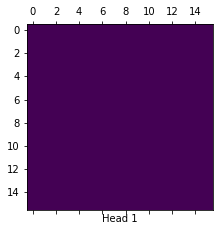

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


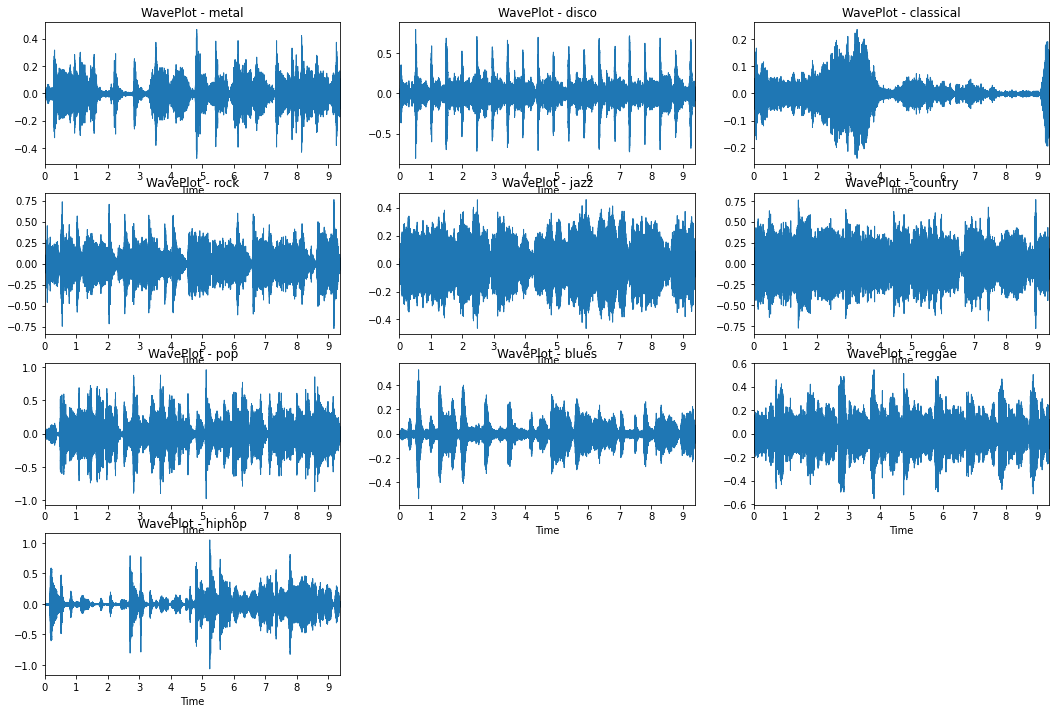

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00838393  0.0011283  -0.00284212 ... -0.0074891  -0.00881064
  0.00212645]
X range: [0.8616258502006531, -1.0074609518051147]


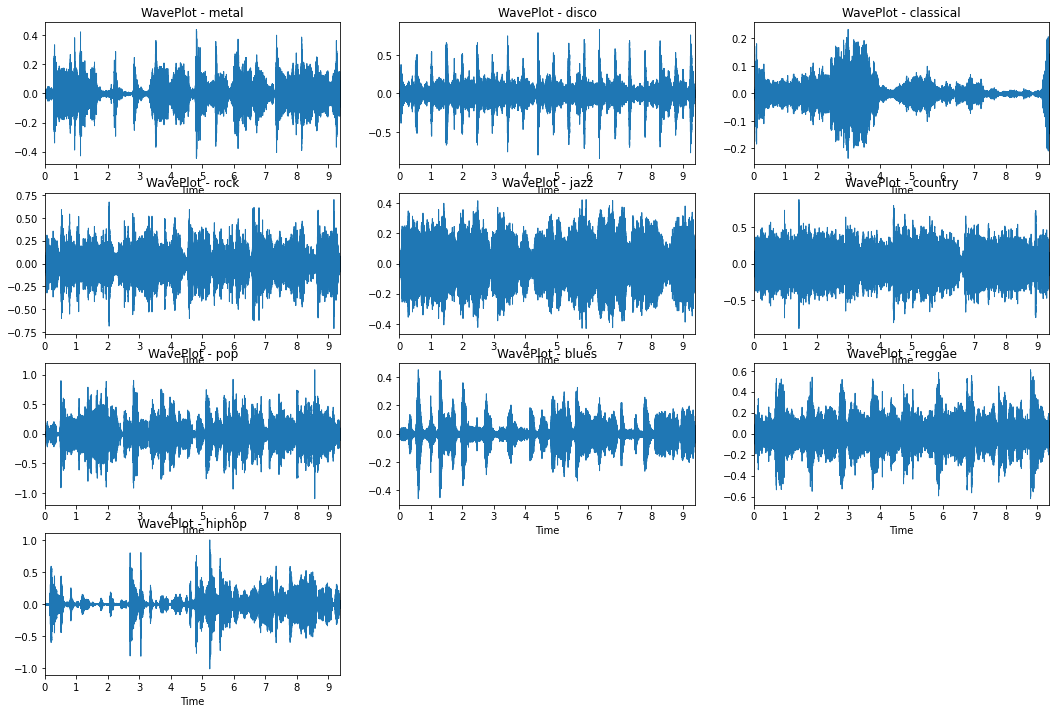

------------------------------- Auto-regressive Sampling in process..........-----------------------------
Sampled output shape: [  4 881] (with Start Token...)
tf.Tensor(
[[512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]], shape=(4, 881), dtype=int64)
(4, 28160, 1)
-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------
X':  [ 0.00831394 -0.00053046 -0.00568363 ... -0.00341901 -0.00954305
  0.00404466]
X range: [0.01038975641131401, -0.009543051943182945]


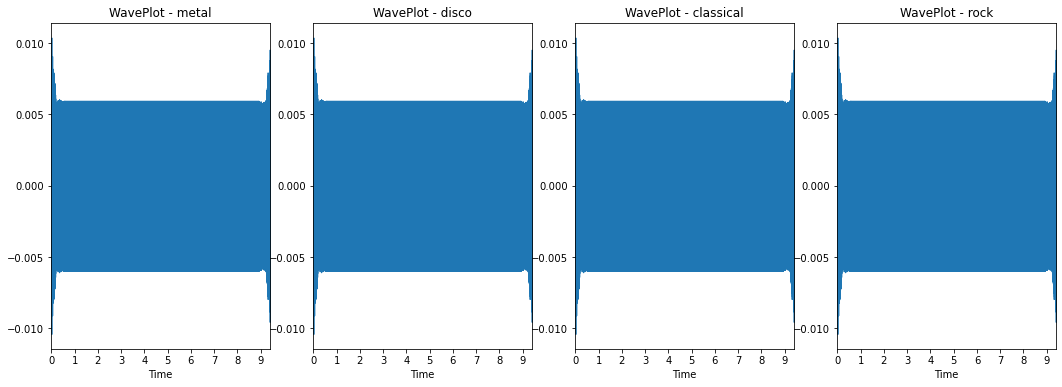

Epoch 82 Loss 1.9777; Perplexity (exp of loss_per_word): 7.22640; Accuracy 0.5011
Time taken for 1 epoch: 17.04 secs

Epoch 83 Loss 1.9524; Perplexity (exp of loss_per_word): 7.04589; Accuracy 0.5055
Time taken for 1 epoch: 17.02 secs

Epoch 84 Loss 1.9330; Perplexity (exp of loss_per_word): 6.91044; Accuracy 0.5102
Time taken for 1 epoch: 17.07 secs

Epoch 85 Loss 1.9083; Perplexity (exp of loss_per_word): 6.74195; Accuracy 0.5147
Time taken for 1 epoch: 17.06 secs

Epoch 86 Loss 1.8855; Perplexity (exp of loss_per_word): 6.58945; Accuracy 0.5190
Time taken for 1 epoch: 17.18 secs

Saving checkpoint for epoch 86 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-18
---------------------------Epoch: 85 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 7.4863; Perplex

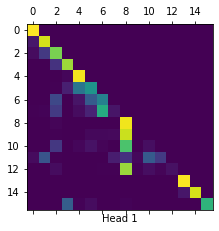

transformer_layer_17_attention
(550, 1, 16, 16)


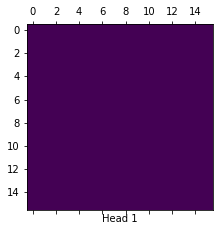

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


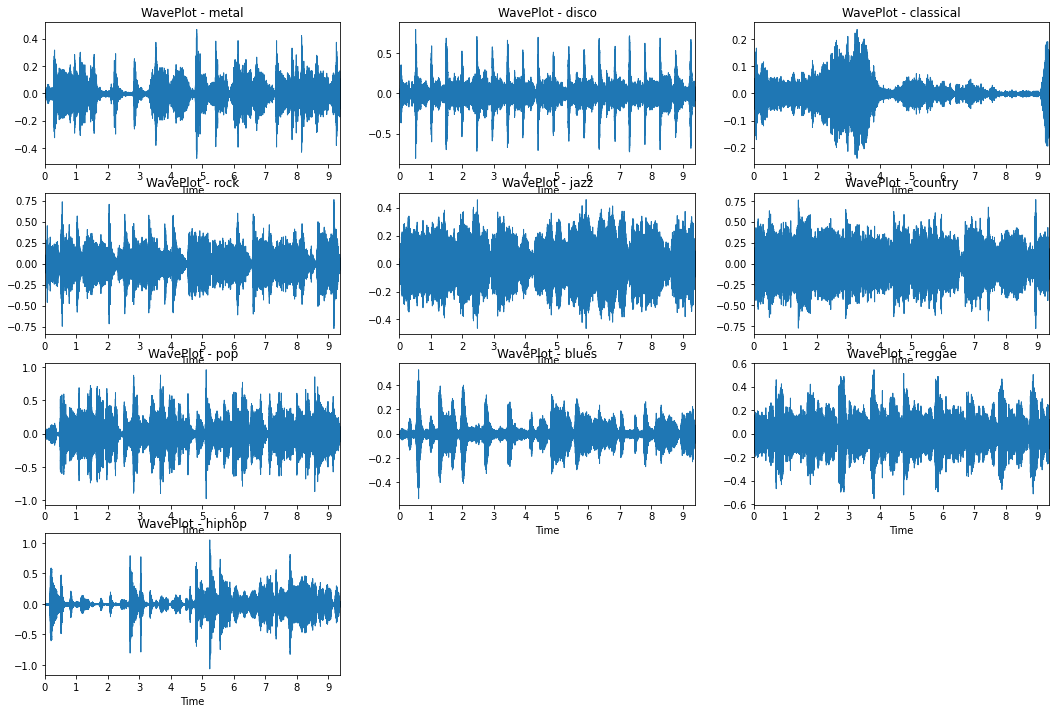

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00790153  0.00088755 -0.00304164 ... -0.00770512 -0.01274827
  0.00366141]
X range: [0.9070882797241211, -1.0617518424987793]


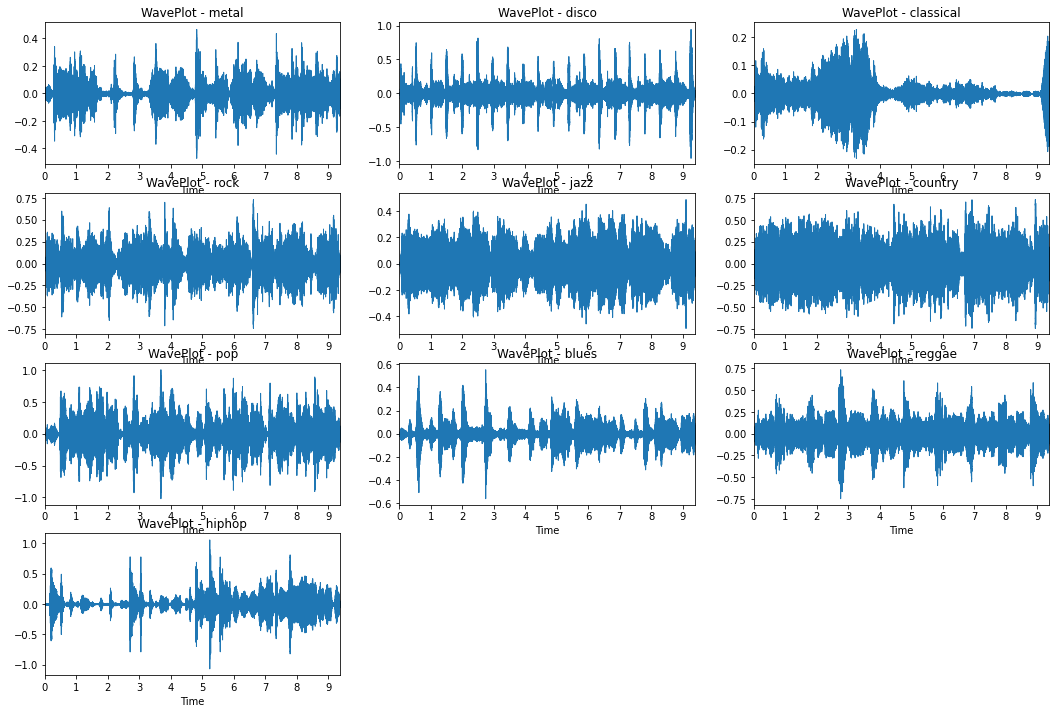

Epoch 87 Loss 1.8602; Perplexity (exp of loss_per_word): 6.42482; Accuracy 0.5232
Time taken for 1 epoch: 17.13 secs

Epoch 88 Loss 1.8431; Perplexity (exp of loss_per_word): 6.31582; Accuracy 0.5274
Time taken for 1 epoch: 16.52 secs

Epoch 89 Loss 1.8167; Perplexity (exp of loss_per_word): 6.15122; Accuracy 0.5322
Time taken for 1 epoch: 16.53 secs

Epoch 90 Loss 1.7972; Perplexity (exp of loss_per_word): 6.03281; Accuracy 0.5372
Time taken for 1 epoch: 16.54 secs

Epoch 91 Loss 1.7787; Perplexity (exp of loss_per_word): 5.92231; Accuracy 0.5399
Time taken for 1 epoch: 16.46 secs

Saving checkpoint for epoch 91 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-19
---------------------------Epoch: 90 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 7.7897; Perplex

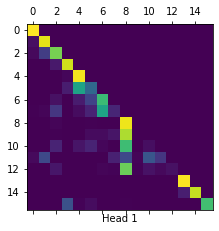

transformer_layer_17_attention
(550, 1, 16, 16)


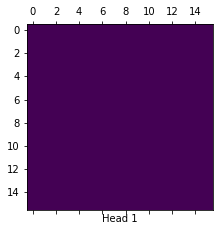

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


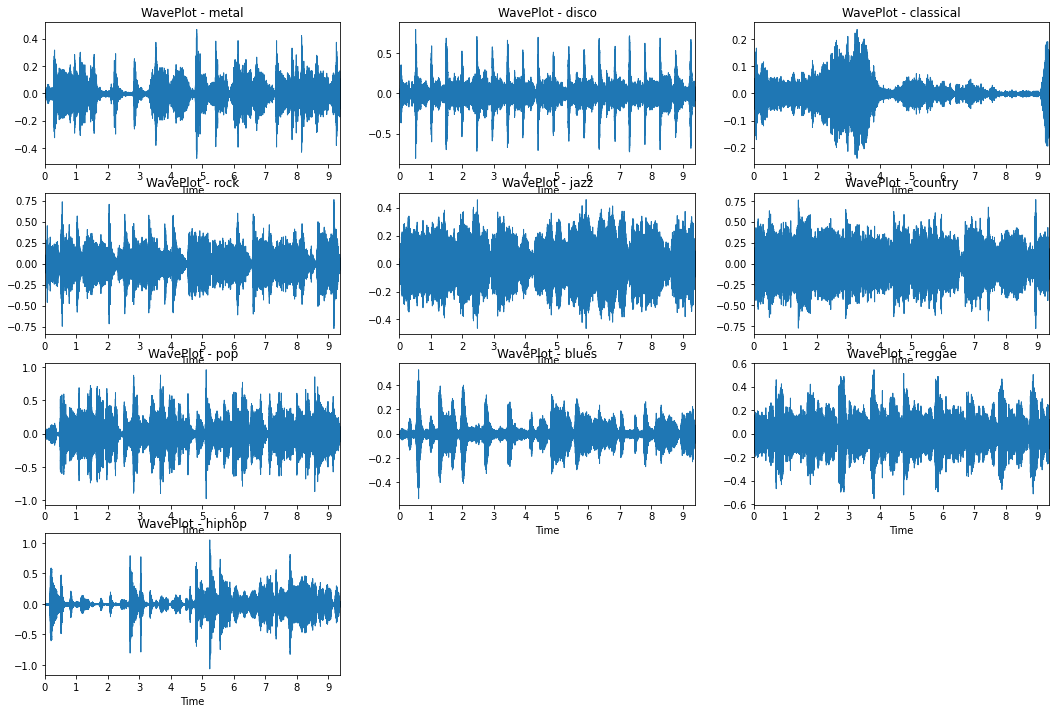

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00722918  0.00155214 -0.00283112 ... -0.0106923  -0.0145961
  0.00333177]
X range: [0.9146234393119812, -1.0407613515853882]


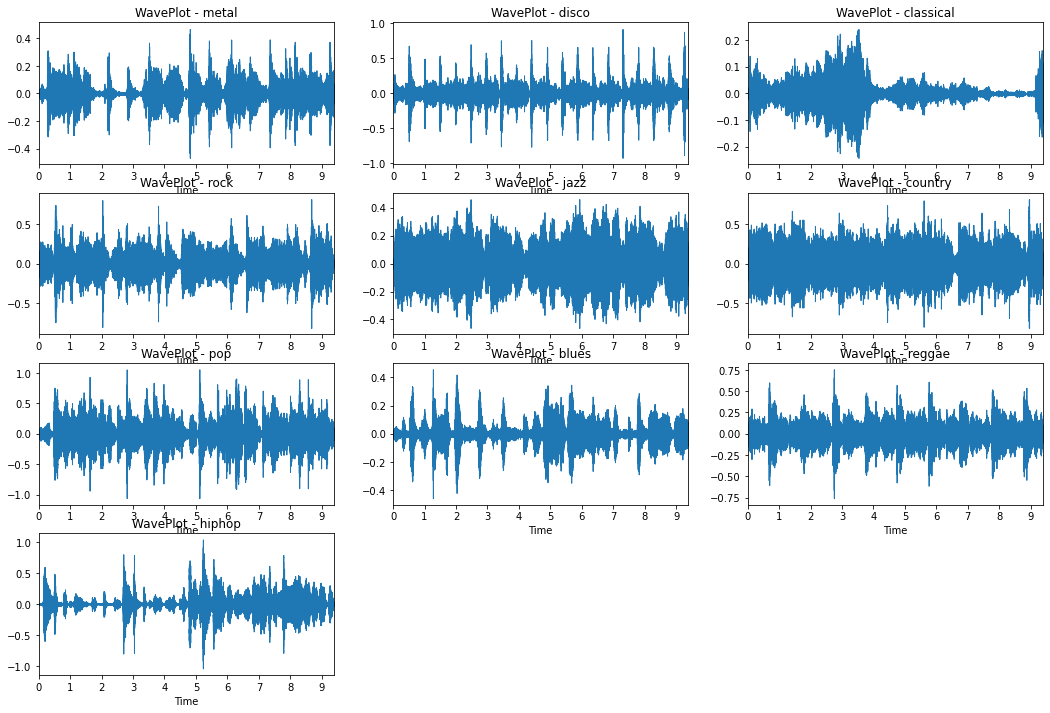

Epoch 92 Loss 1.7553; Perplexity (exp of loss_per_word): 5.78507; Accuracy 0.5445
Time taken for 1 epoch: 16.50 secs

Epoch 93 Loss 1.7382; Perplexity (exp of loss_per_word): 5.68702; Accuracy 0.5485
Time taken for 1 epoch: 16.38 secs

Epoch 94 Loss 1.7190; Perplexity (exp of loss_per_word): 5.57898; Accuracy 0.5524
Time taken for 1 epoch: 16.39 secs

Epoch 95 Loss 1.7013; Perplexity (exp of loss_per_word): 5.48120; Accuracy 0.5556
Time taken for 1 epoch: 16.40 secs

Epoch 96 Loss 1.6789; Perplexity (exp of loss_per_word): 5.35963; Accuracy 0.5597
Time taken for 1 epoch: 16.35 secs

Saving checkpoint for epoch 96 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-20
---------------------------Epoch: 95 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 8.0976; Perplex

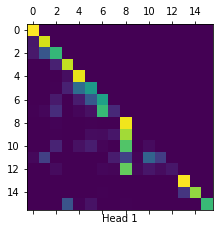

transformer_layer_17_attention
(550, 1, 16, 16)


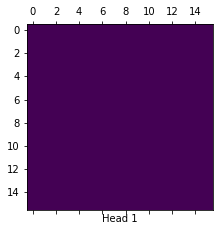

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


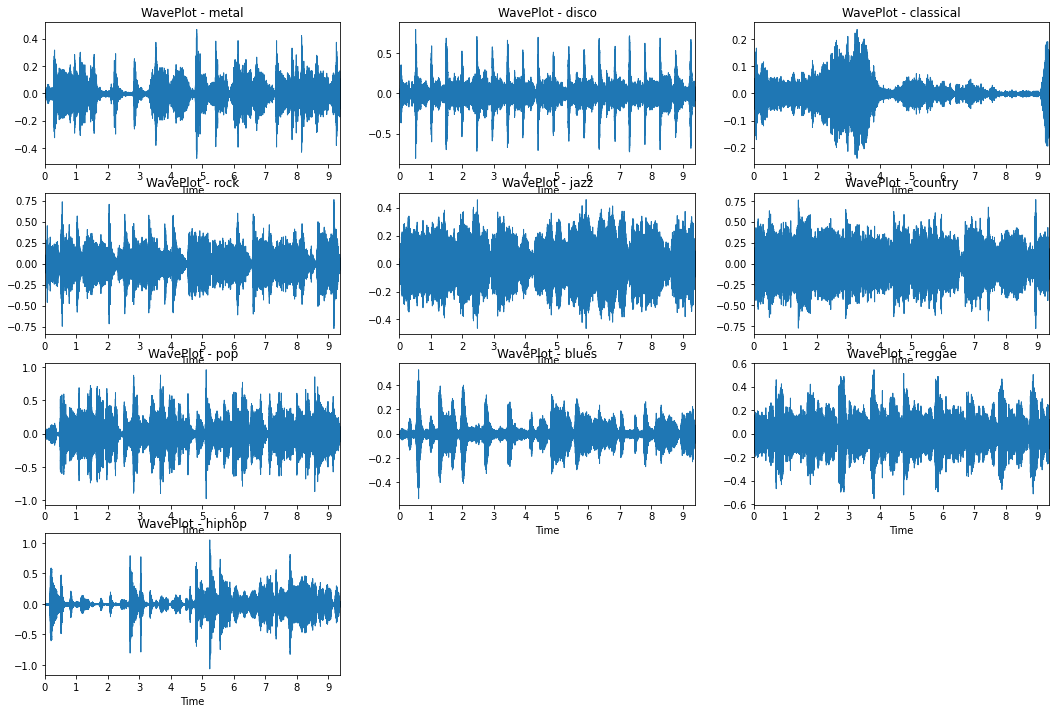

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.0081505   0.00082961 -0.00393377 ... -0.01126782 -0.01403626
  0.001696  ]
X range: [0.9035996794700623, -1.0410280227661133]


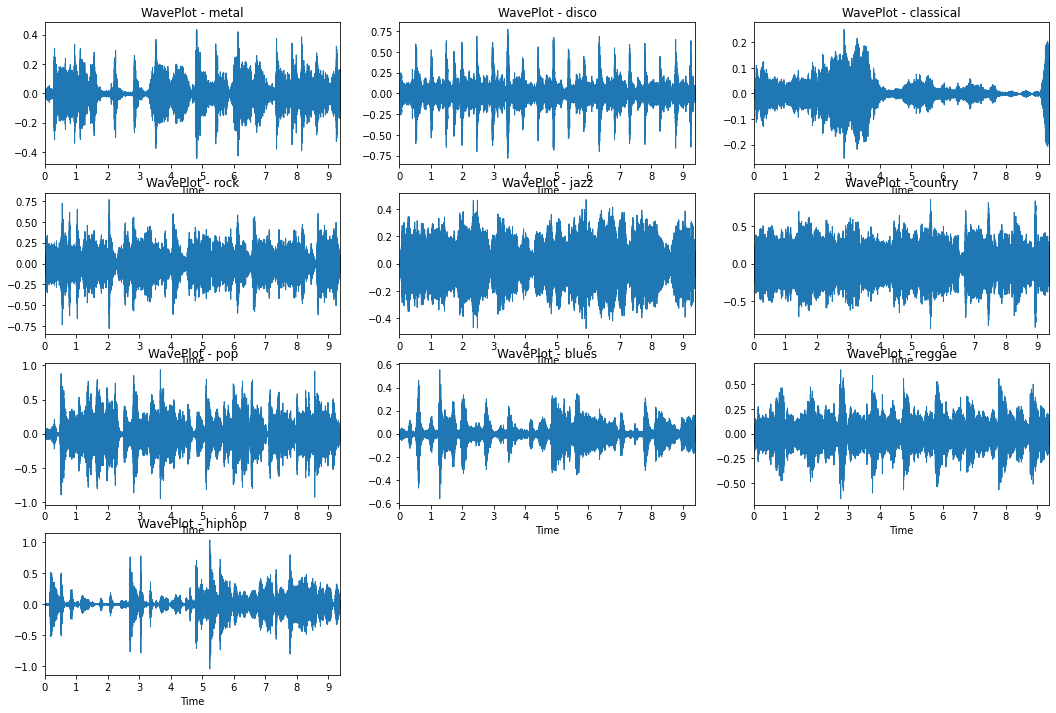

Epoch 97 Loss 1.6653; Perplexity (exp of loss_per_word): 5.28742; Accuracy 0.5632
Time taken for 1 epoch: 16.55 secs

Epoch 98 Loss 1.6477; Perplexity (exp of loss_per_word): 5.19482; Accuracy 0.5667
Time taken for 1 epoch: 16.80 secs

Epoch 99 Loss 1.6253; Perplexity (exp of loss_per_word): 5.08014; Accuracy 0.5711
Time taken for 1 epoch: 17.10 secs

Epoch 100 Loss 1.6039; Perplexity (exp of loss_per_word): 4.97238; Accuracy 0.5752
Time taken for 1 epoch: 17.07 secs

Epoch 101 Loss 1.5922; Perplexity (exp of loss_per_word): 4.91441; Accuracy 0.5784
Time taken for 1 epoch: 17.10 secs

Saving checkpoint for epoch 101 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-21
---------------------------Epoch: 100 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 8.4235; Per

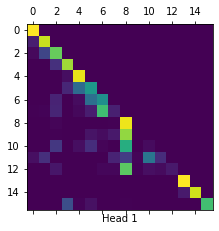

transformer_layer_17_attention
(550, 1, 16, 16)


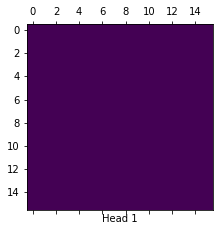

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


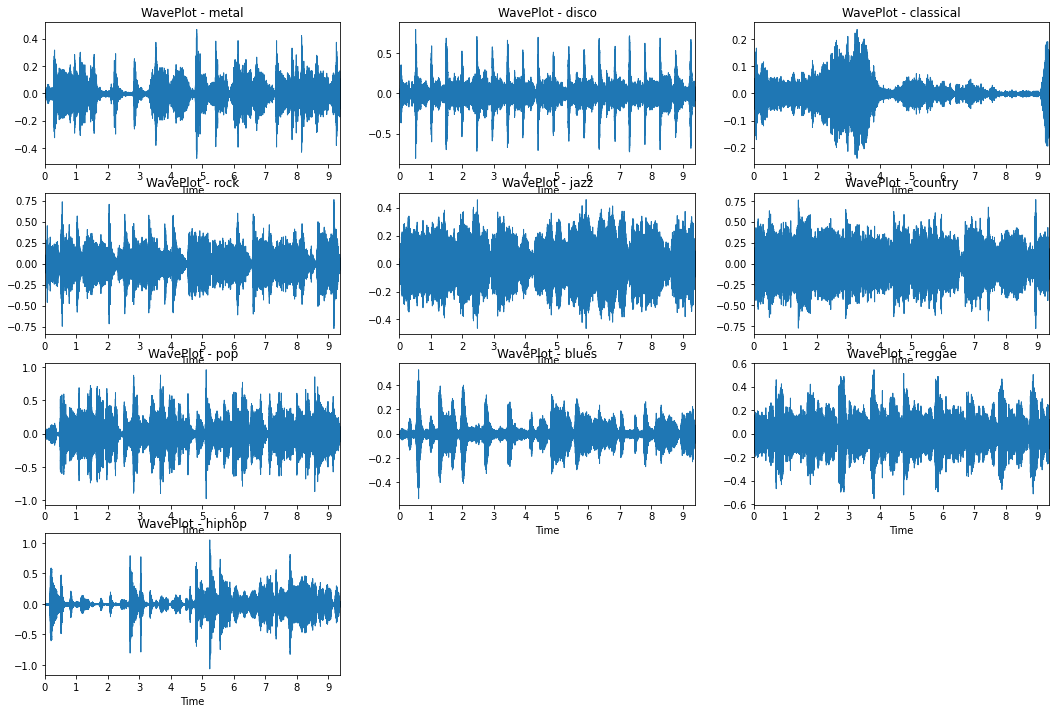

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00738022  0.00146089 -0.00358895 ... -0.00912799 -0.01454167
  0.00268285]
X range: [0.8622052073478699, -0.7812607884407043]


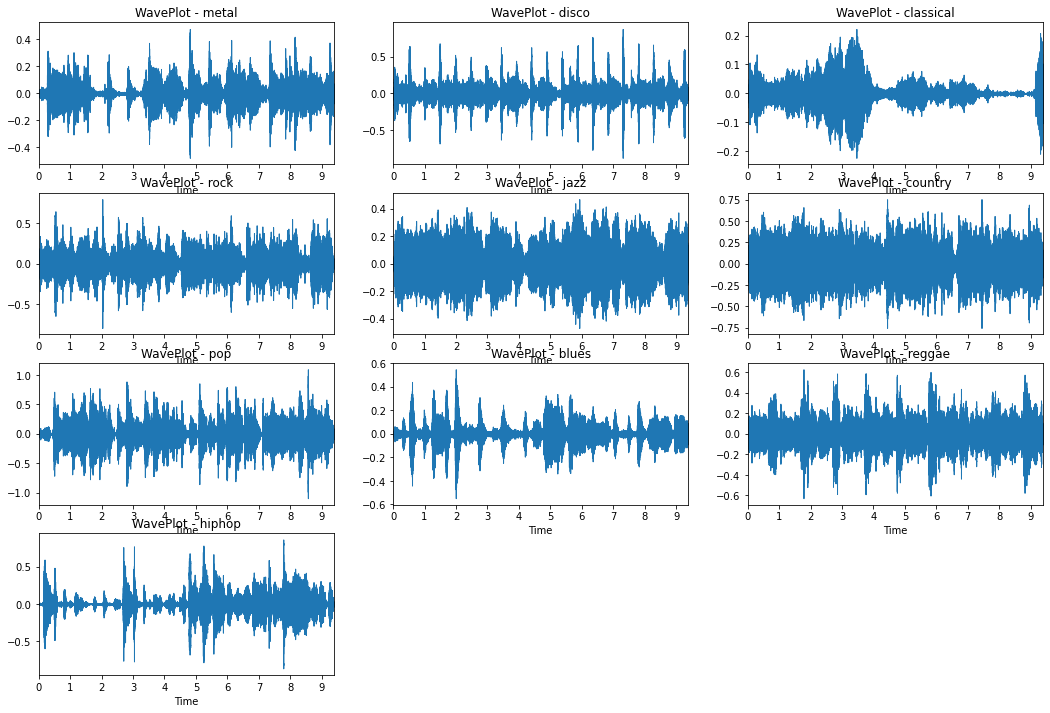

------------------------------- Auto-regressive Sampling in process..........-----------------------------
Sampled output shape: [  4 881] (with Start Token...)
tf.Tensor(
[[512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]
 [512 411 411 ... 411 411 411]], shape=(4, 881), dtype=int64)
(4, 28160, 1)
-------------------------------- Reconstruction from Prior Sampling (non-prime)... --------------------------
X':  [ 0.00831394 -0.00053046 -0.00568363 ... -0.00341901 -0.00954305
  0.00404466]
X range: [0.01038975641131401, -0.009543051943182945]


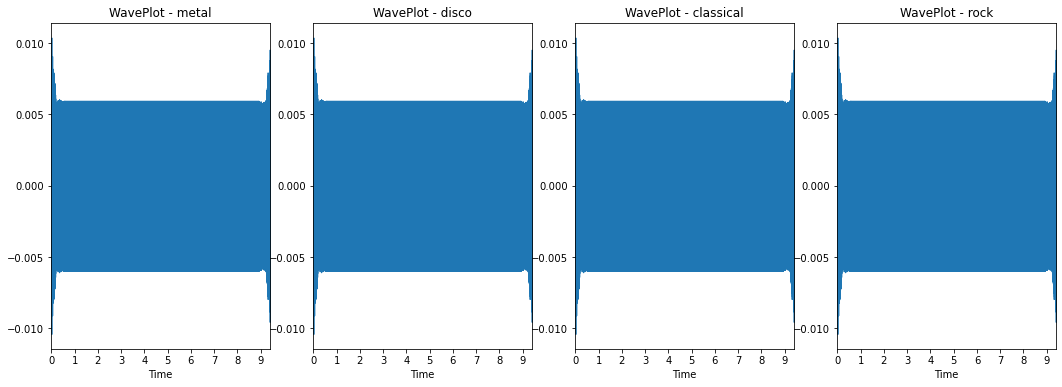

Epoch 102 Loss 1.5702; Perplexity (exp of loss_per_word): 4.80779; Accuracy 0.5827
Time taken for 1 epoch: 17.06 secs

Epoch 103 Loss 1.5565; Perplexity (exp of loss_per_word): 4.74220; Accuracy 0.5857
Time taken for 1 epoch: 17.09 secs

Epoch 104 Loss 1.5376; Perplexity (exp of loss_per_word): 4.65339; Accuracy 0.5895
Time taken for 1 epoch: 17.08 secs

Epoch 105 Loss 1.5226; Perplexity (exp of loss_per_word): 4.58416; Accuracy 0.5926
Time taken for 1 epoch: 17.17 secs

Epoch 106 Loss 1.5081; Perplexity (exp of loss_per_word): 4.51793; Accuracy 0.5959
Time taken for 1 epoch: 17.20 secs

Saving checkpoint for epoch 106 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-22
---------------------------Epoch: 105 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 8.7226; 

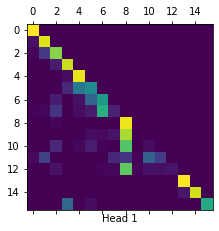

transformer_layer_17_attention
(550, 1, 16, 16)


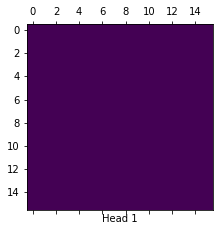

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


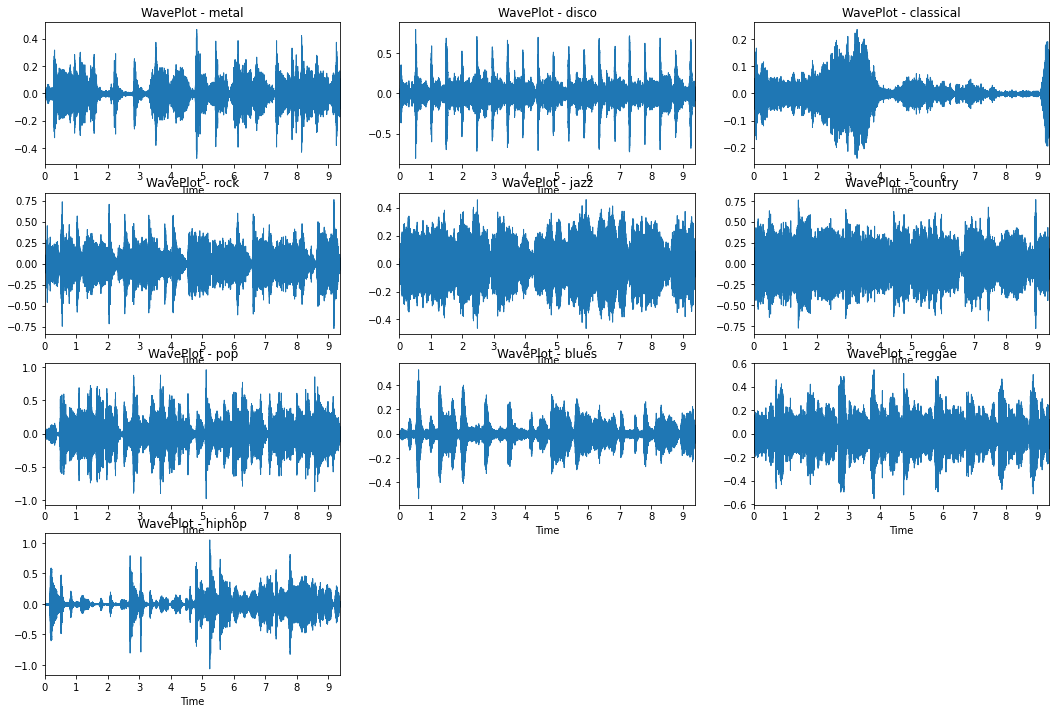

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00552841  0.00143319 -0.00293131 ... -0.01031879 -0.01480275
  0.00242792]
X range: [0.95296710729599, -1.0512537956237793]


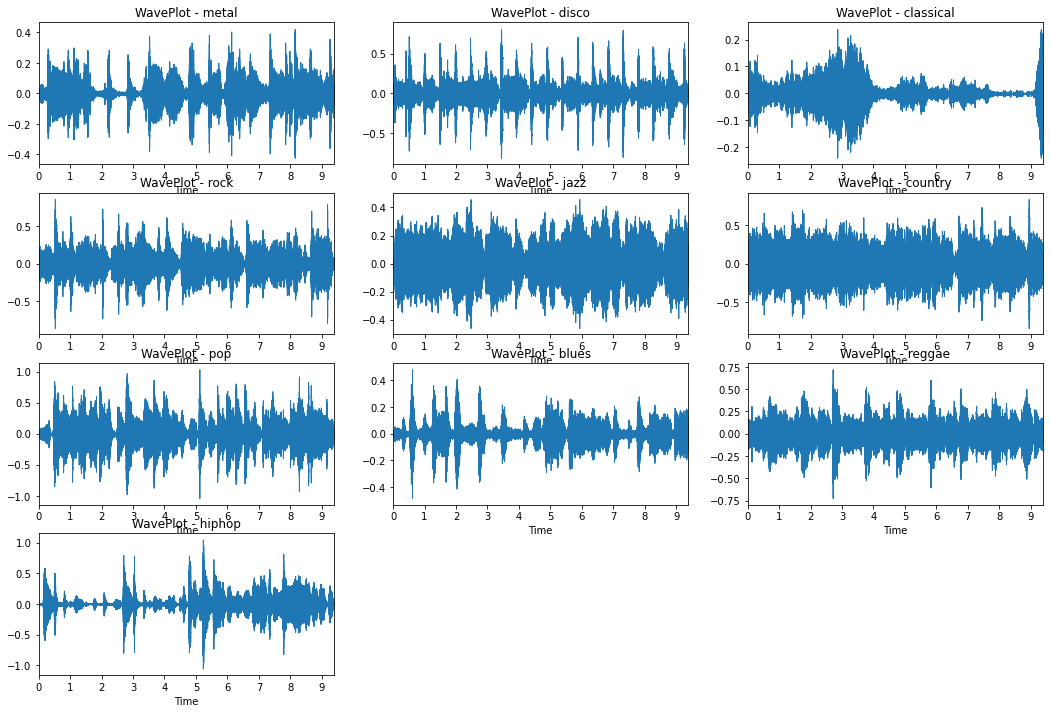

Epoch 107 Loss 1.4894; Perplexity (exp of loss_per_word): 4.43443; Accuracy 0.5997
Time taken for 1 epoch: 17.24 secs

Epoch 108 Loss 1.4762; Perplexity (exp of loss_per_word): 4.37638; Accuracy 0.6026
Time taken for 1 epoch: 17.05 secs

Epoch 109 Loss 1.4597; Perplexity (exp of loss_per_word): 4.30459; Accuracy 0.6062
Time taken for 1 epoch: 17.09 secs

Epoch 110 Loss 1.4480; Perplexity (exp of loss_per_word): 4.25443; Accuracy 0.6087
Time taken for 1 epoch: 17.09 secs

Epoch 111 Loss 1.4299; Perplexity (exp of loss_per_word): 4.17829; Accuracy 0.6126
Time taken for 1 epoch: 17.06 secs

Saving checkpoint for epoch 111 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-23
---------------------------Epoch: 110 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 9.0686; 

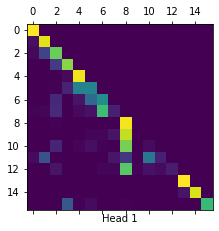

transformer_layer_17_attention
(550, 1, 16, 16)


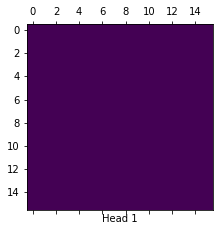

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


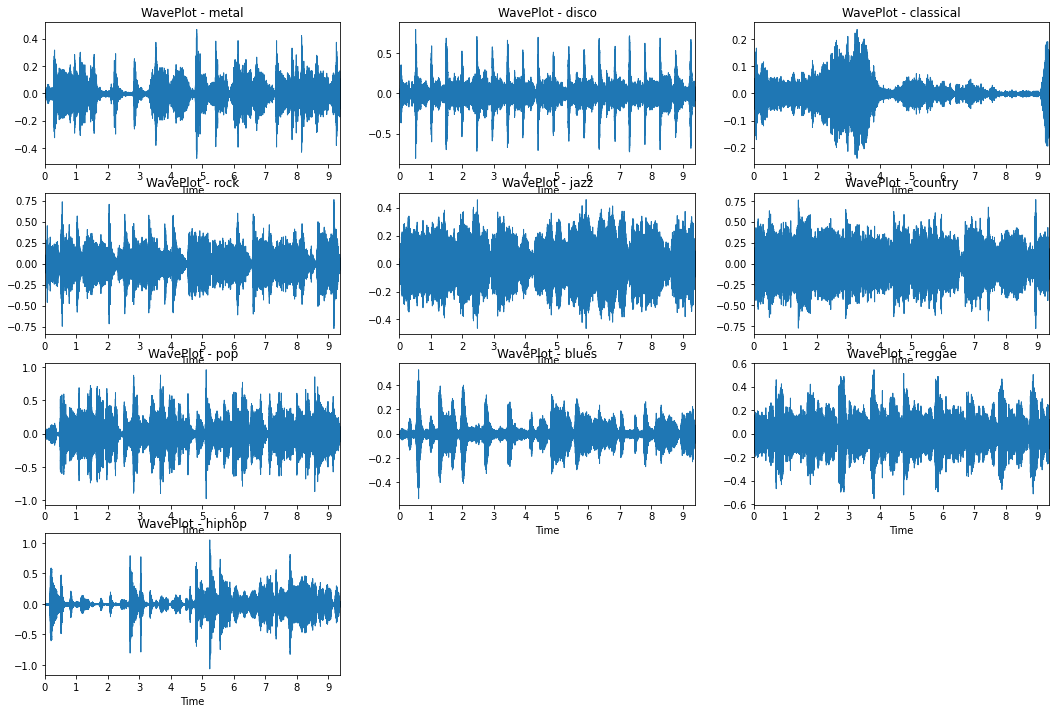

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00799078  0.00089629 -0.00319725 ... -0.01002227 -0.01480666
  0.00239649]
X range: [0.904800295829773, -1.0447494983673096]


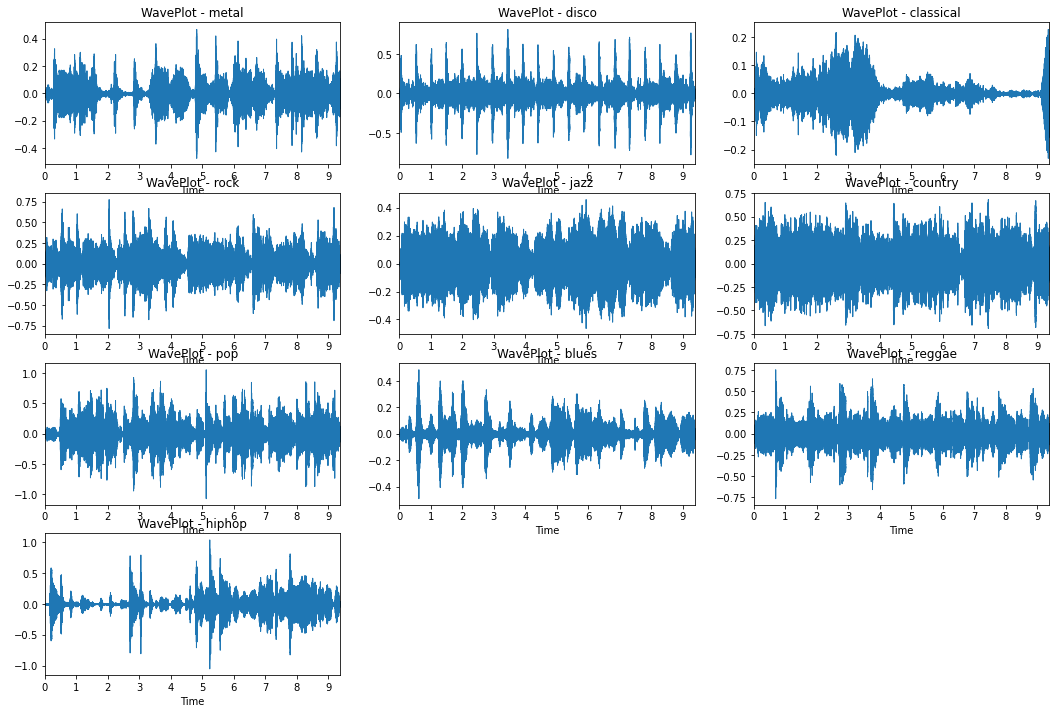

Epoch 112 Loss 1.4181; Perplexity (exp of loss_per_word): 4.12918; Accuracy 0.6153
Time taken for 1 epoch: 17.22 secs

Epoch 113 Loss 1.4022; Perplexity (exp of loss_per_word): 4.06400; Accuracy 0.6185
Time taken for 1 epoch: 17.03 secs

Epoch 114 Loss 1.3833; Perplexity (exp of loss_per_word): 3.98807; Accuracy 0.6227
Time taken for 1 epoch: 17.03 secs

Epoch 115 Loss 1.3759; Perplexity (exp of loss_per_word): 3.95850; Accuracy 0.6235
Time taken for 1 epoch: 17.00 secs

Epoch 116 Loss 1.3562; Perplexity (exp of loss_per_word): 3.88153; Accuracy 0.6291
Time taken for 1 epoch: 17.15 secs

Saving checkpoint for epoch 116 at ./colab_storage/VQVAE/cp/prior/Prior_Bottom_PosEmbed_FactorizedAttn_CAUSALCONV_no-mask-prev-row_HEADS=1_WIDTH=256_DEPTH=18_BLOCKS=_55_DROP-OUT_0.0/ckpt-24
---------------------------Epoch: 115 Validation Rountine...------------------------------
-----------------------------------Training Samples...-----------------------------------
Testing performance: Loss 9.3738; 

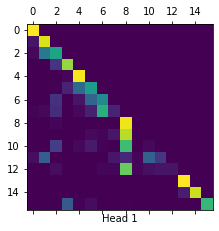

transformer_layer_17_attention
(550, 1, 16, 16)


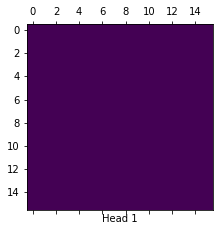

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.903730034828186, -1.0567002296447754]


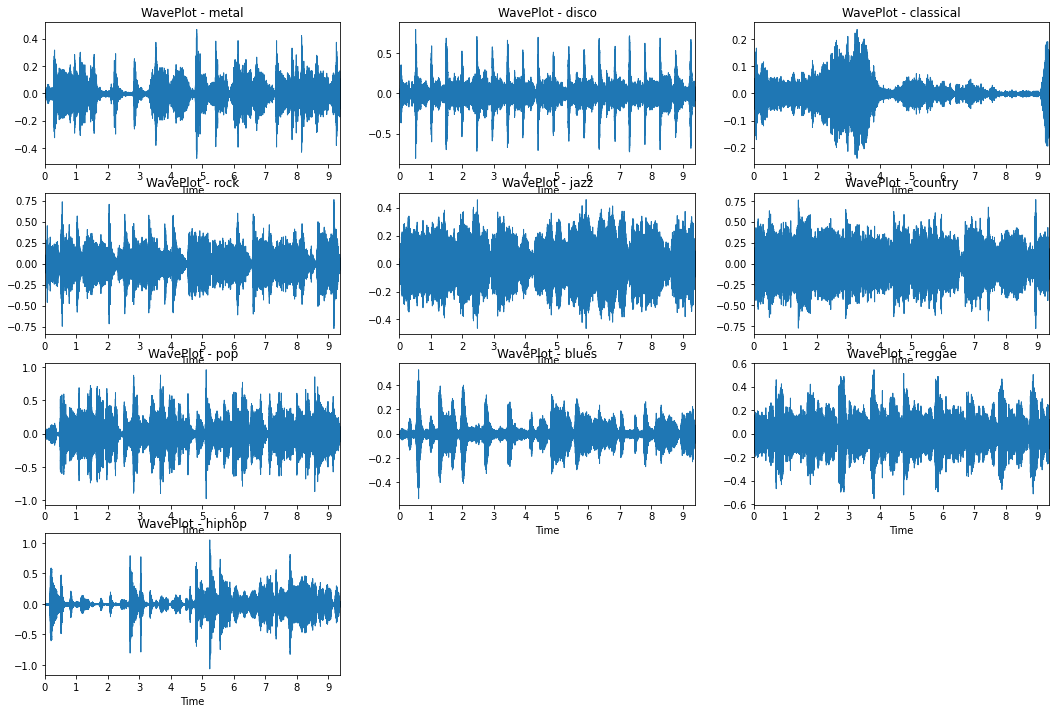

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.00688135  0.00094398 -0.00352715 ... -0.01031878 -0.01480275
  0.00242792]
X range: [0.9037284851074219, -1.0566997528076172]


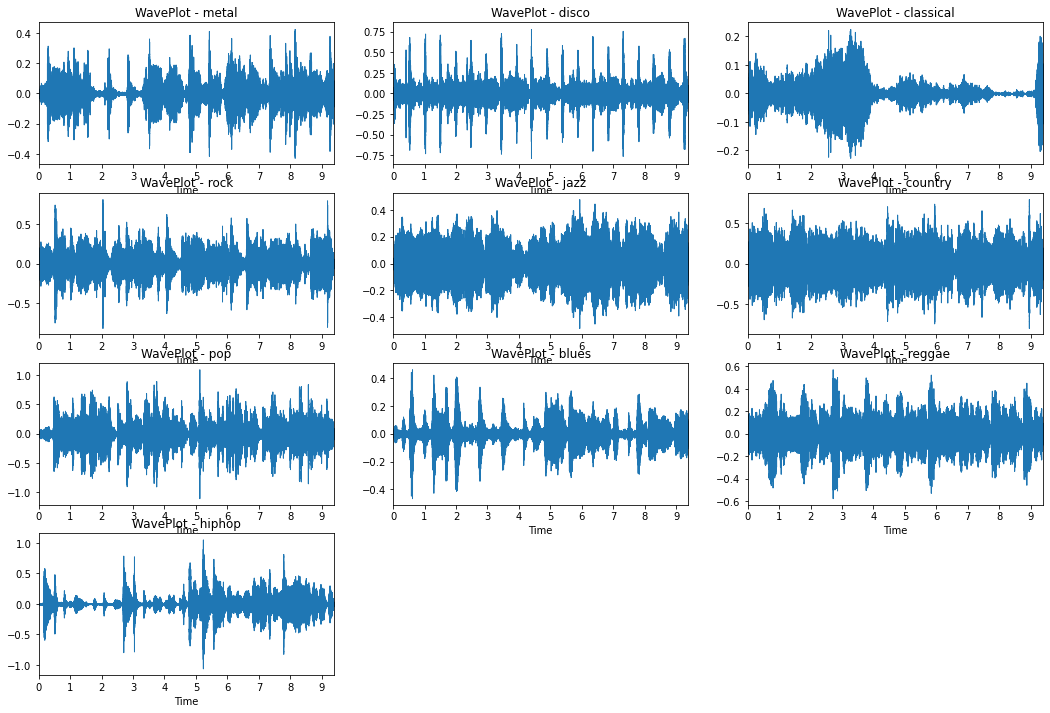

Epoch 117 Loss 1.3488; Perplexity (exp of loss_per_word): 3.85284; Accuracy 0.6295
Time taken for 1 epoch: 17.52 secs



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  # Reset Metrics per Epoch
  train_loss.reset_states()
  train_accuracy.reset_states()

  for (batch, (X, Y)) in enumerate(prior_train_dataset):
    # TODO: Make Y (class label useful...)
    # print("Batch Input Shape: {}".format(X.shape))
    train_step(X)

    # if batch % 50 == 0:
    #   print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(train_loss.result()):.5f}; Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

  if epoch % 5 == 0:
     ckpt_save_path = ckpt_manager.save()
     print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')
     print("---------------------------Epoch: {} Validation Rountine...------------------------------".format(epoch))
     print("-----------------------------------Training Samples...-----------------------------------")
     test_step(train_samples, epoch)

  # print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f}; Perplexity (exp of loss_per_word): {tf.math.exp(train_loss.result()):.5f}; Accuracy {train_accuracy.result():.4f}')

  # print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

0
1
2
3
4
5
6
7
8
9
10
11
12
Testing performance: Loss 4.7256; Perplexity (exp of loss_per_word): 112.79356; Accuracy 0.1243
transformer_layer_0_attention
(550, 1, 16, 16)


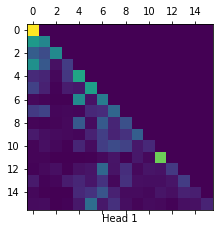

transformer_layer_17_attention
(550, 1, 16, 16)


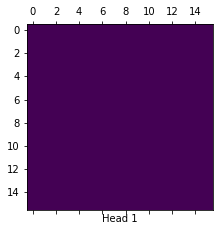

[DEBUG] TOTAL Number of Trainable Weights for model: 302337
Reconstructed Output:  (10, 28160, 1)
X':  [ 0.00643826  0.00171618 -0.00123004 ... -0.01031878 -0.01480274
  0.00242792]
X range: [0.9037297964096069, -1.0567002296447754]


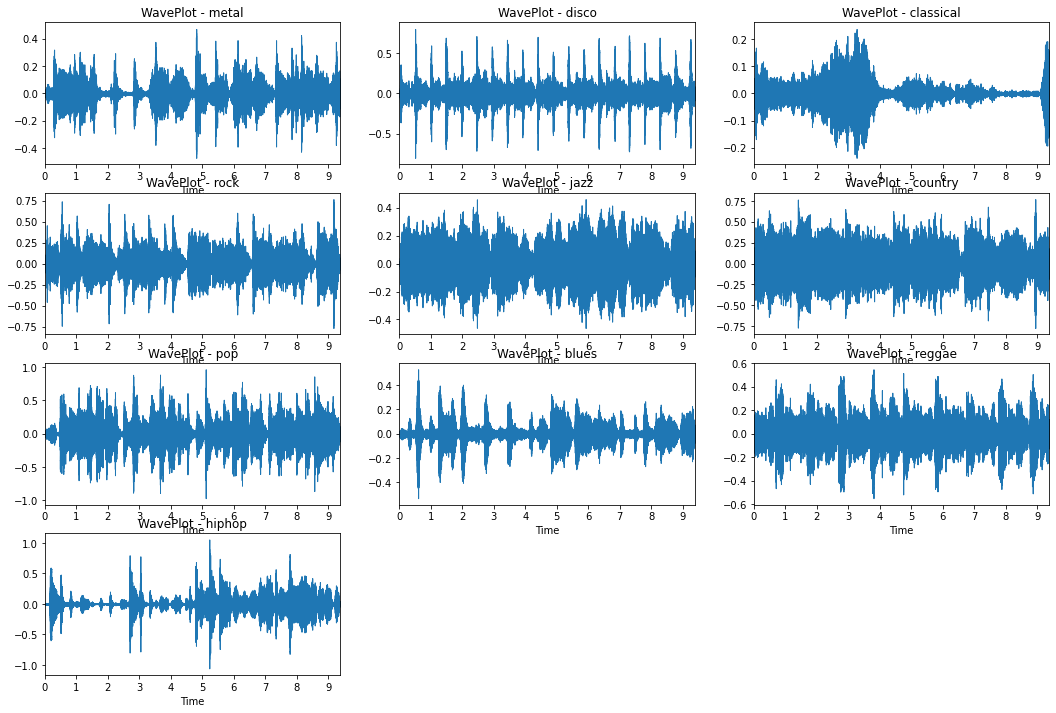

-------------------------------- Reconstruction from latent codes... --------------------------
X':  [ 0.0059394   0.00181533 -0.00154622 ... -0.01039112 -0.01274659
  0.00323586]
X range: [0.9587522149085999, -1.0646157264709473]


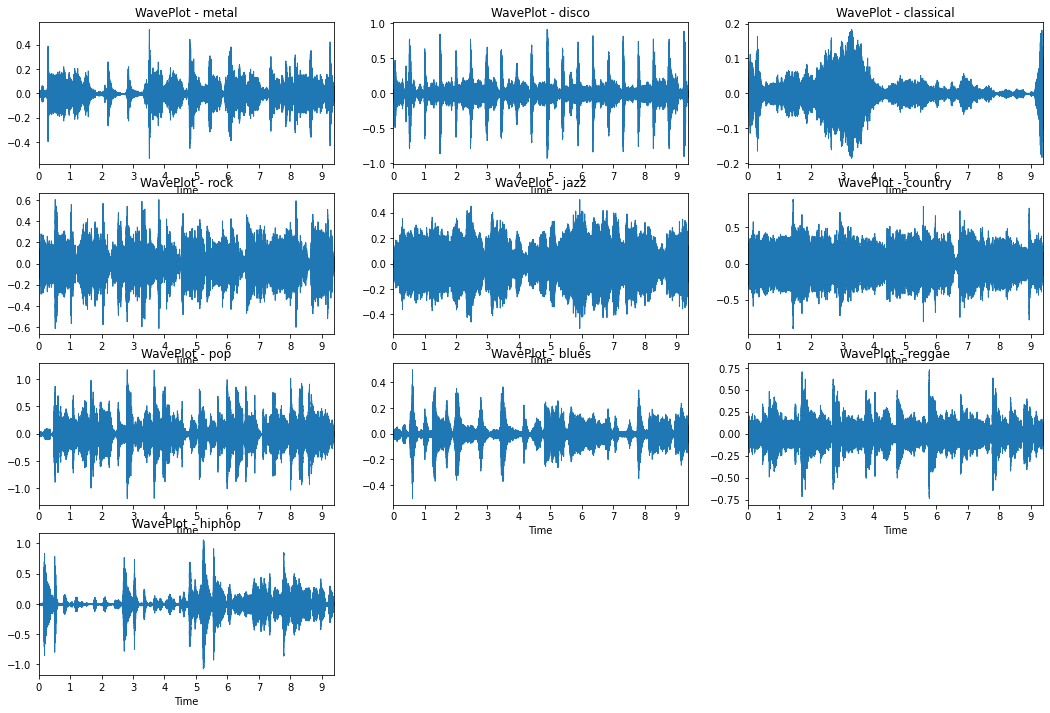

In [163]:
# Inspect the weights
logits, attn_first = test_step(train_samples)

In [161]:
for k, v in attn_first.items():
  print(k)
  print(v.shape)
  print(v[0][0])

transformer_layer_0_attention
(550, 1, 16, 16)
tf.Tensor(
[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.41212499e-01 4.58787441e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.94908971e-01 2.33572617e-01 4.71518487e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.01197755e-01 2.74490386e-01 4.51603979e-02 1.79151446e-01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000

In [ ]:
greedy_sample = tf.argmax(logits, axis=-1)
# print(greedy_sample[0])
print(attn_first[0][0])

tf.Tensor(
[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.5010419  0.49895808 0.         ... 0.         0.         0.        ]
 [0.33593434 0.33337134 0.33069432 ... 0.         0.         0.        ]
 ...
 [0.00113787 0.00114433 0.00114291 ... 0.00113547 0.         0.        ]
 [0.00114928 0.00113585 0.00114567 ... 0.00113969 0.00112858 0.        ]
 [0.00113233 0.00114261 0.00114168 ... 0.00113352 0.00113883 0.00113372]], shape=(880, 880), dtype=float32)


In [ ]:
# DEBUG
for (batch, (X, Y)) in enumerate(train_dataset):
  quantized_output, latent_codes = get_latent_codes(loaded_vqvae_trainer, X, level=0)
  print(tf.reduce_max(latent_codes), tf.reduce_min(latent_codes))
  assert tf.reduce_max(latent_codes).numpy() < 512

#### Prior Model Storage

In [ ]:
PRIOR_VERSION="multiheadAttnBasedPriorForBottom"
model_storage_path = './colab_storage/VQVAE/cp/{}/{}/'.format("prior", PRIOR_VERSION)

In [ ]:
automha.save(model_storage_path)

INFO:tensorflow:Assets written to: ./colab_storage/VQVAE/cp/prior/multiheadAttnBasedPriorForBottom/assets


INFO:tensorflow:Assets written to: ./colab_storage/VQVAE/cp/prior/multiheadAttnBasedPriorForBottom/assets


In [ ]:
### Restore From Saved_Model
# It can be used to reconstruct the model identically.
loaded_automha = keras.models.load_model(model_storage_path)

# Let's check:
np.testing.assert_allclose(
    automha.predict(sample_latent_codes_bottom)[0], loaded_automha.predict(sample_latent_codes_bottom)[0],
    verbose=True
)


In [ ]:
# automha.predict(sample_latent_codes_bottom)[0].shape

(8, 880, 513)